In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score,KFold, StratifiedKFold

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline, make_pipeline

import seaborn as sns
from sklearn.neighbors import NearestNeighbors as nn
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from sklearn.cluster import KMeans

from sklearn.metrics import classification_report, recall_score, roc_auc_score, precision_score, f1_score, auc, balanced_accuracy_score

#from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
#from lightgbm import LGBMClassifier
#from sklearn.metrics import classification_report, recall_score, roc_auc_score, precision_score, f1_score, auc, balanced_accuracy_score


In [2]:
random_state = 123*987*4-1
models_to_average = 50

In [3]:
real_dataset = pd.read_csv("./datasets/real_ds_shortincome.csv")
synt_data_distilgpt2 = pd.read_csv('./datasets/synt_ds_distillgpt2_shortincome_3epochs_temp1.4.csv')
synt_data_gpt2xl = pd.read_csv("./datasets/synt_ds_gpt2xl_shortincome_3epochs_temp1.4.csv")
synt_data_cerebras = pd.read_csv("./datasets/synt_ds_cerebras13_shortincome_3epochs_temp1.4.csv")
synt_data_phi = pd.read_csv("./datasets/synt_ds_phi15_shortincome_3epochs_temp1.4.csv")
control_dataset = pd.read_csv("./datasets/real_ds_shortincome_control.csv")

In [4]:
real_dataset.drop(columns="Unnamed: 0",inplace=True)
synt_data_distilgpt2.drop(columns="Unnamed: 0",inplace=True)
synt_data_gpt2xl.drop(columns="Unnamed: 0",inplace=True)
synt_data_cerebras.drop(columns="Unnamed: 0",inplace=True)
synt_data_phi.drop(columns="Unnamed: 0",inplace=True)
control_dataset.drop(columns="Unnamed: 0",inplace=True)


In [5]:
cols = real_dataset.columns

In [6]:
def strip (x) :
    if isinstance(x,str):
        return x.lstrip()
    else :
        return x

In [7]:
for col in cols :
    real_dataset[col] = real_dataset[col].map(strip) 

In [8]:
for col in cols :
    synt_data_distilgpt2[col] = synt_data_distilgpt2[col].map(strip) 

In [9]:
for col in cols :
    synt_data_gpt2xl[col] = synt_data_gpt2xl[col].map(strip) 

In [10]:
for col in cols :
    synt_data_cerebras[col] = synt_data_cerebras[col].map(strip) 

In [11]:
for col in cols :
    synt_data_phi[col] = synt_data_phi[col].map(strip) 

In [12]:
for col in cols :
    control_dataset[col] = control_dataset[col].map(strip) 

In [13]:
categs = list()
numeric = list()
for col in cols :
    print ('----------------------------------------------------')
    print (col, ':', real_dataset[col].dtype)
    print (len(real_dataset[col].unique()),'uniques values : ' ,real_dataset[col].unique())
    if real_dataset[col].dtype == 'object' :
        if col != 'target' :
            categs.append(col)
    else :
         numeric.append(col)
    

----------------------------------------------------
age : int64
91 uniques values :  [52 39 29 30 15  6 50 21 42 32  8 87 47 45  7  4 17 14 82 19 40 71 49 22
 74 25  2 36 35 18 58 54 24 37 80 73 55  0 62 28 78 41 75 60 69 13 12 61
 44 64  3 43 27 31 46 76 33 23 84 48  1  5 70 16 51 38 72  9 20 56 90 11
 67 26 34 10 57 53 66 77 85 89 68 79 81 65 59 83 88 63 86]
----------------------------------------------------
class_of_worker : object
9 uniques values :  ['Private' 'Self-employed-not incorporated' 'Not in universe'
 'Self-employed-incorporated' 'Local government' 'State government'
 'Federal government' 'Never worked' 'Without pay']
----------------------------------------------------
education : object
17 uniques values :  ['Some college but no degree' 'Bachelors degree(BA AB BS)'
 '7th and 8th grade' 'Children' 'High school graduate' '10th grade'
 'Masters degree(MA MS MEng MEd MSW MBA)'
 'Associates degree-occup /vocational' '11th grade' '5th or 6th grade'
 '9th grade' 'Doctorate

In [14]:
# these features are categorical by definition
numeric.remove('own_business_or_self_employed')
categs.append('own_business_or_self_employed')


In [15]:
numeric

['age',
 'dividends_from_stocks',
 'num_persons_worked_for_employer',
 'weeks_worked_in_year']

In [16]:
categs

['class_of_worker',
 'education',
 'marital_stat',
 'major_occupation_code',
 'race',
 'sex',
 'tax_filer_stat',
 'region_of_previous_residence',
 'detailed_household_summary_in_household',
 'country_of_birth_self',
 'citizenship',
 'own_business_or_self_employed']

In [17]:
target_encoder= {'50000+.': 1, 
                '- 50000.': 0} 

# Data analysis

### Real data 

In [18]:
real_dataset.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000           30000.000000                     30000.000000   
mean      34.438300             188.126267                         1.964933   
std       22.350409            2007.247607                         2.375379   
min        0.000000               0.000000                         0.000000   
25%       15.000000               0.000000                         0.000000   
50%       33.000000               0.000000                         1.000000   
75%       50.000000               0.000000                         4.000000   
max       90.000000           99999.000000                         6.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                   30000.000000          30000.000000  
mean                        0.171133             23.182433  
std                         0.548383             24.424737  
min                         0.000000              0.000000  
25%                         0.000000              0.000000  
50%                         0.000000              8.000000  
75%                         0.000000             52.000000  
max                         2.000000             52.000000

In [19]:
print(real_dataset.isna().sum().sum())

0


In [20]:
real_dataset['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

<AxesSubplot:>

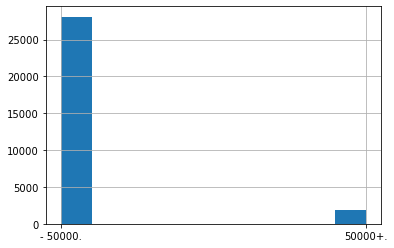

In [21]:
real_dataset['target'].hist()

In [22]:
print(f" Real data for binary classification is imbalanced: {len(real_dataset[real_dataset['target']=='50000+.'])/len(real_dataset)*100:.2f}% and {100-len(real_dataset[real_dataset['target']=='50000+.'])/len(real_dataset)*100:.2f}%")


 Real data for binary classification is imbalanced: 6.30% and 93.70%


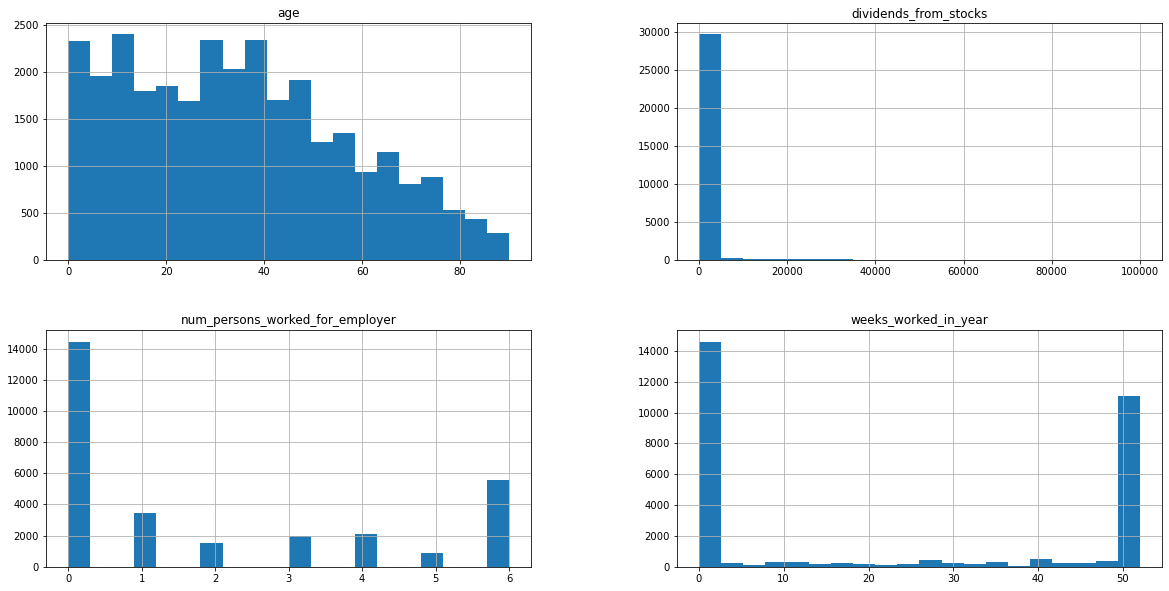

In [23]:
real_dataset[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 2))
plt.show()

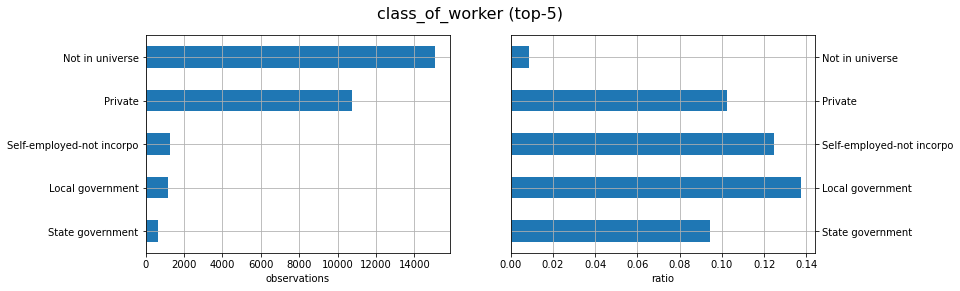

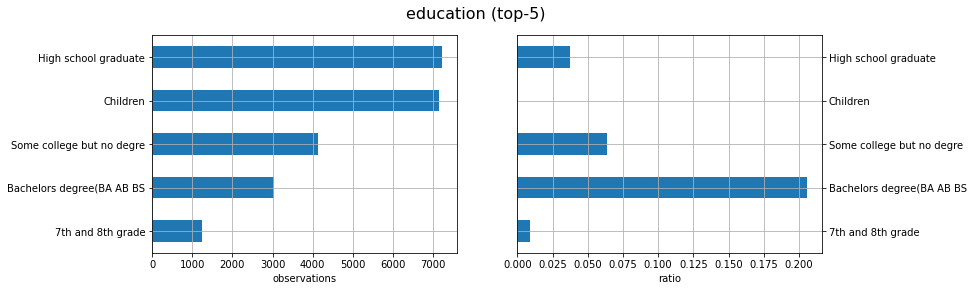

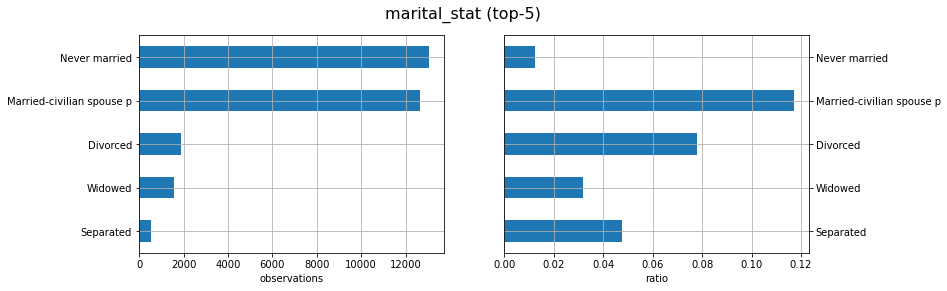

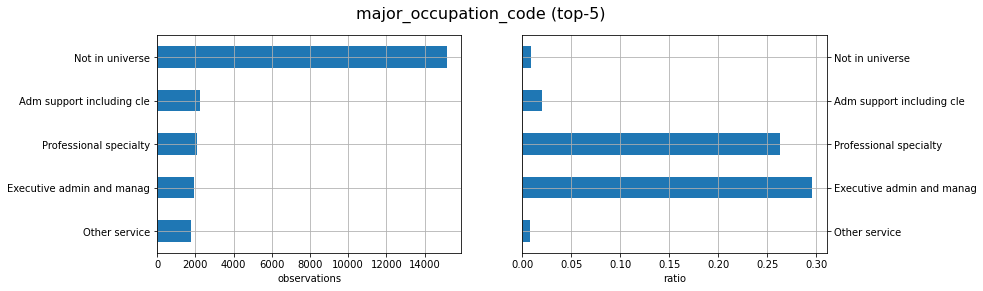

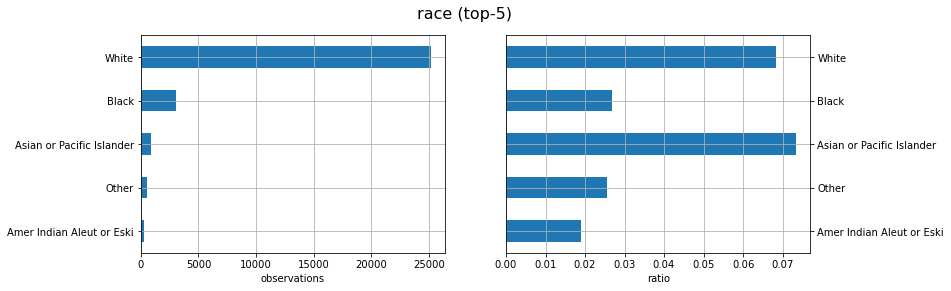

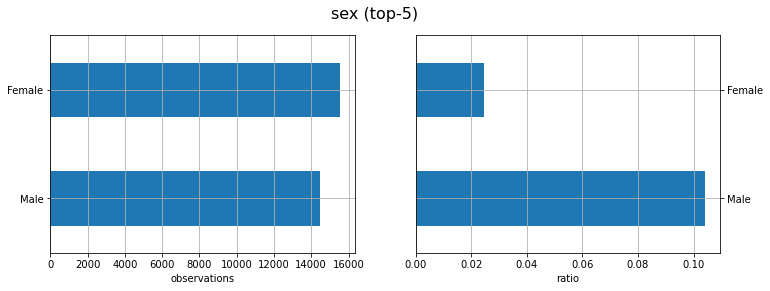

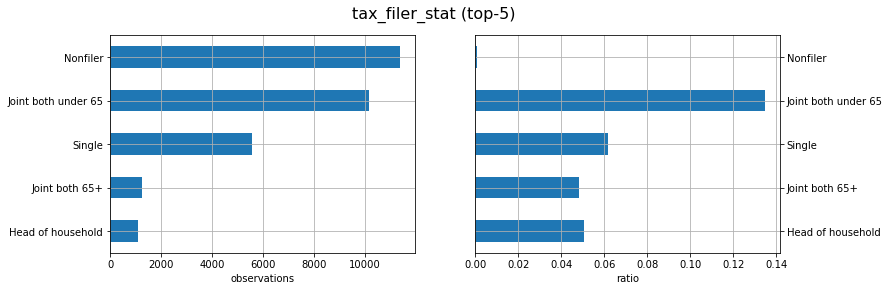

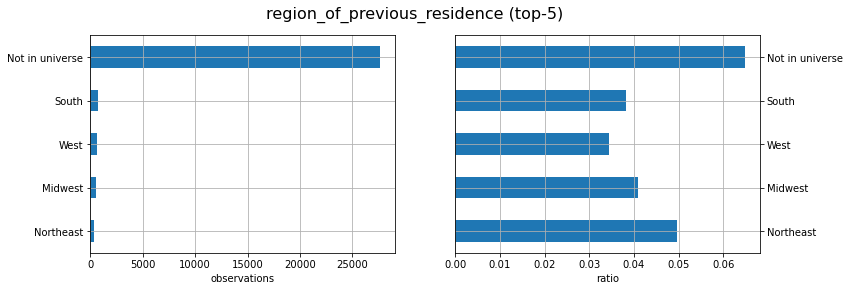

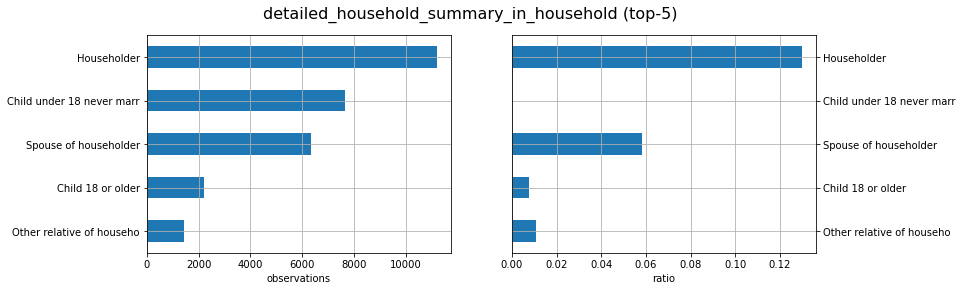

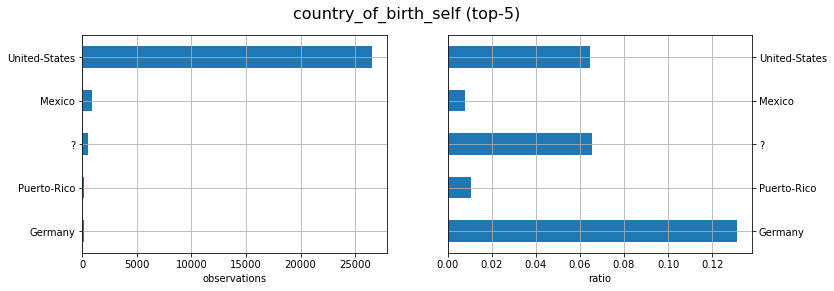

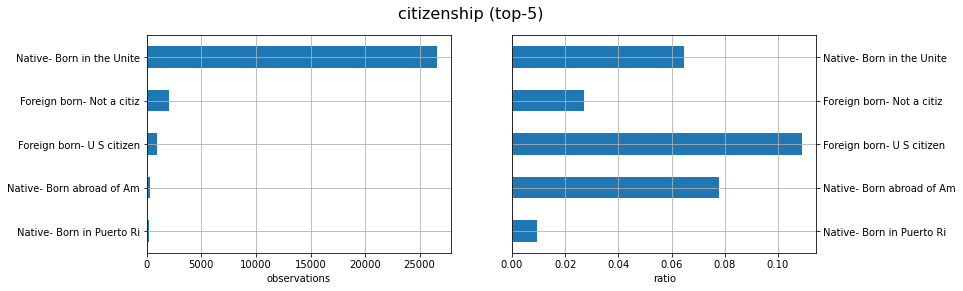

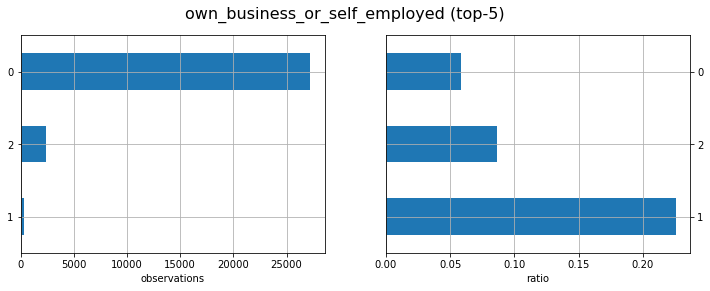

In [24]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = real_dataset.drop(['target'], axis=1).assign(cnt=1, target=real_dataset['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### DistillGPT

In [25]:
synt_data_distilgpt2.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000           3.000000e+04                     30000.000000   
mean      38.977033           2.431710e+04                         3.299233   
std       40.509710           3.471230e+06                        36.739964   
min        0.000000          -3.000000e+00                         0.000000   
25%       24.000000           0.000000e+00                         0.000000   
50%       37.000000           0.000000e+00                         2.000000   
75%       53.000000           5.000000e+01                         5.000000   
max     3600.000000           6.000000e+08                      5000.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                   30000.000000          30000.000000  
mean                        3.078633             25.805900  
std                       312.326115            154.934681  
min                         0.000000              0.000000  
25%                         0.000000              0.000000  
50%                         0.000000             24.000000  
75%                         0.000000             51.000000  
max                     50000.000000          26000.000000

In [26]:
print(synt_data_distilgpt2.isna().sum().sum())
print(synt_data_distilgpt2.isna().sum())

1
age                                        0
class_of_worker                            1
education                                  0
marital_stat                               0
major_occupation_code                      0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    0
num_persons_worked_for_employer            0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
target                                     0
dtype: int64


In [27]:
synt_data_distilgpt2['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

<AxesSubplot:>

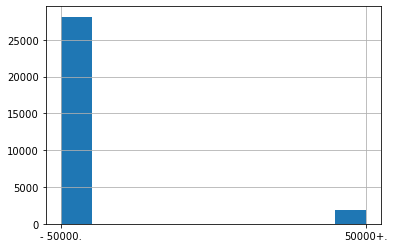

In [28]:
synt_data_distilgpt2['target'].hist()

In [29]:
print(f" Synthetic data for binary classification is imbalanced: {len(synt_data_distilgpt2[synt_data_distilgpt2['target']==' 50000+.'])/len(synt_data_distilgpt2)*100:.2f}% and {100-len(synt_data_distilgpt2[synt_data_distilgpt2['target']==' 50000+.'])/len(synt_data_distilgpt2)*100:.2f}%")


 Synthetic data for binary classification is imbalanced: 0.00% and 100.00%


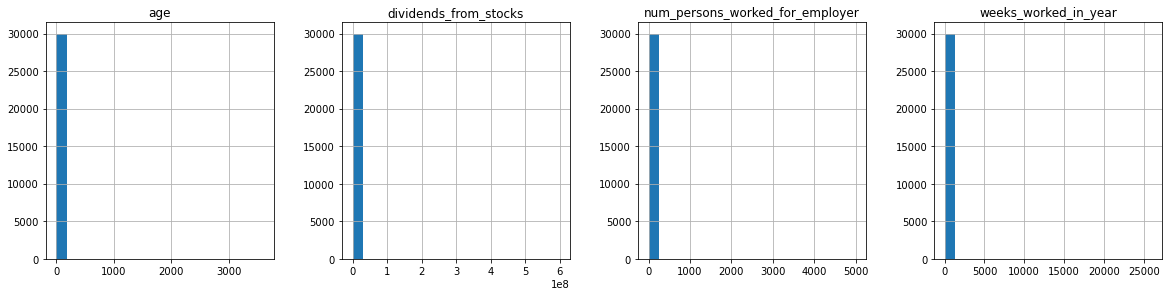

In [30]:
synt_data_distilgpt2[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 4))
plt.show()

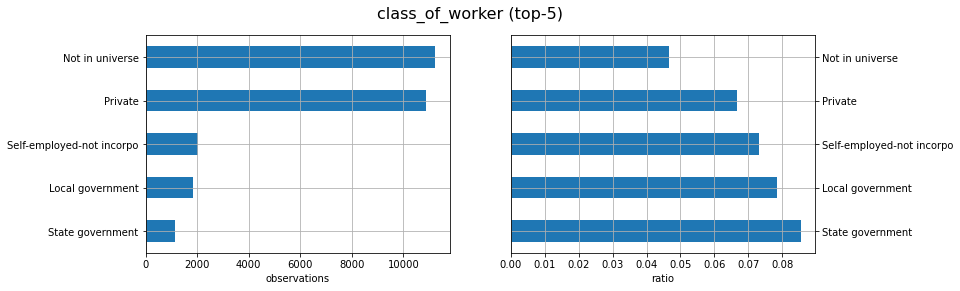

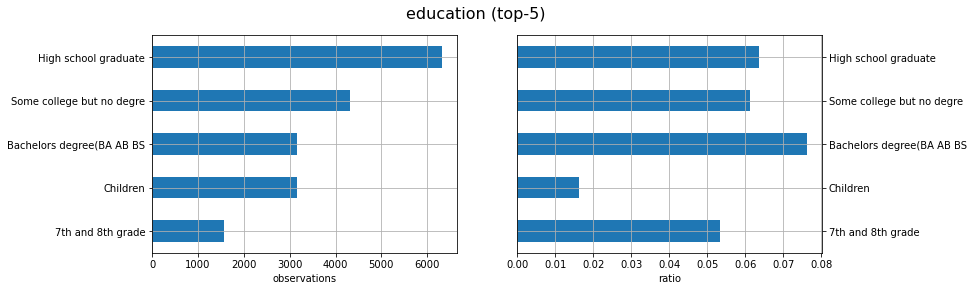

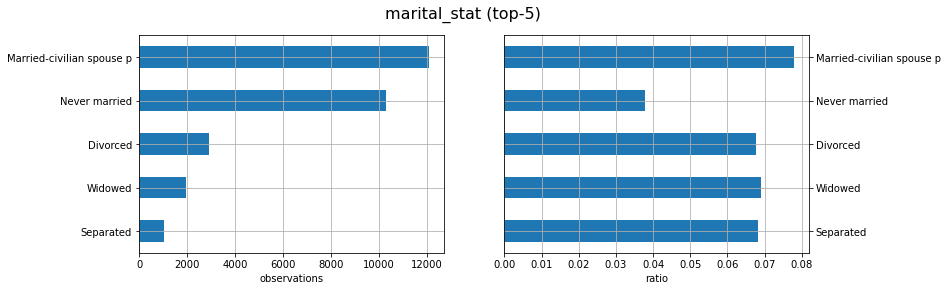

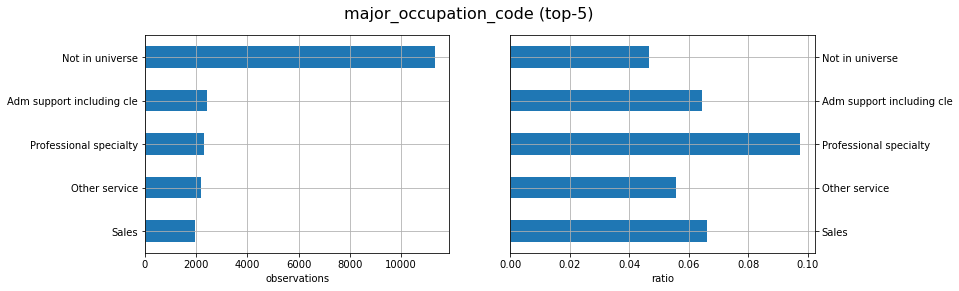

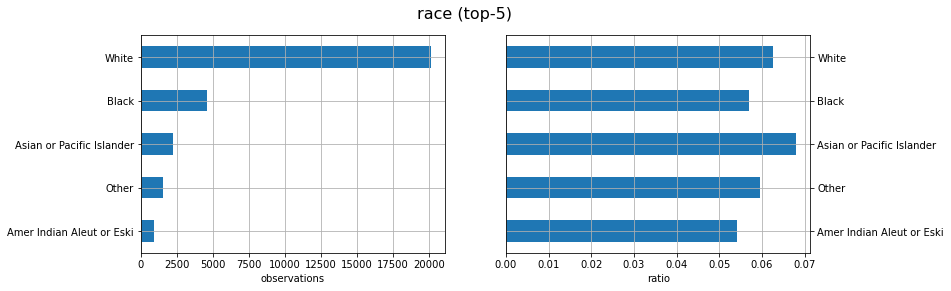

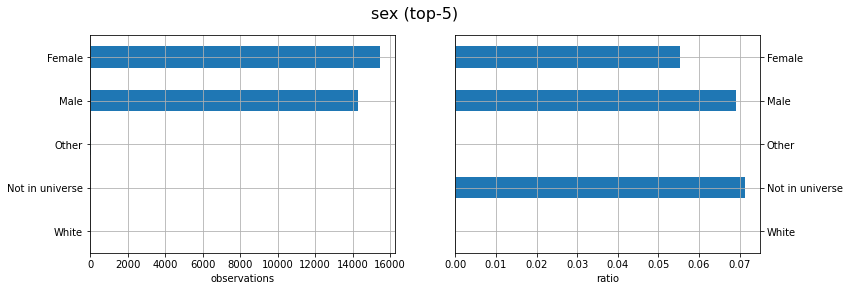

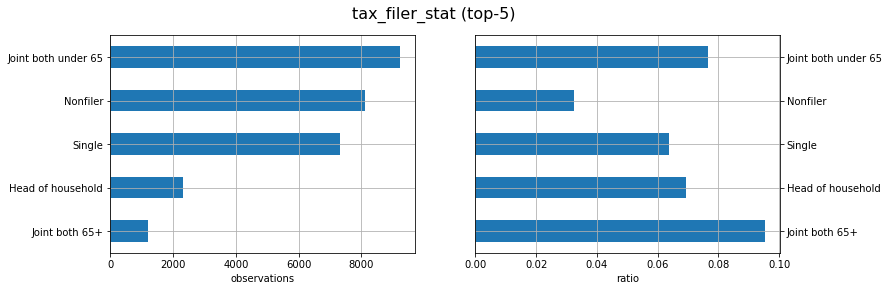

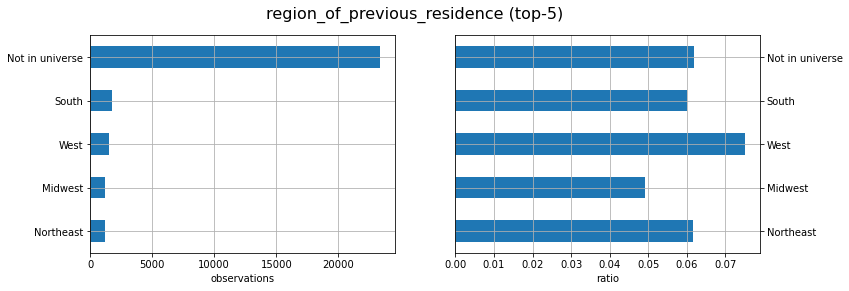

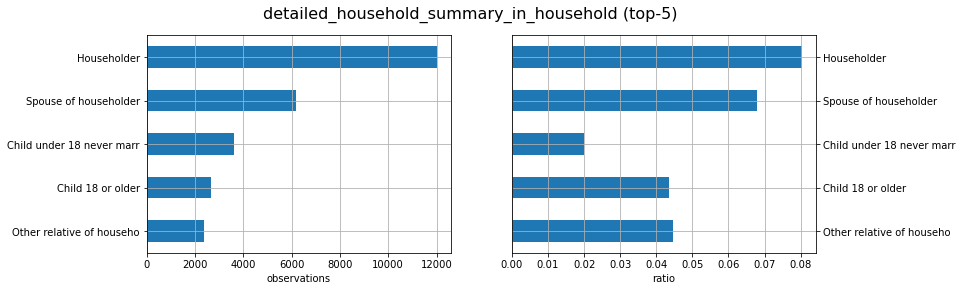

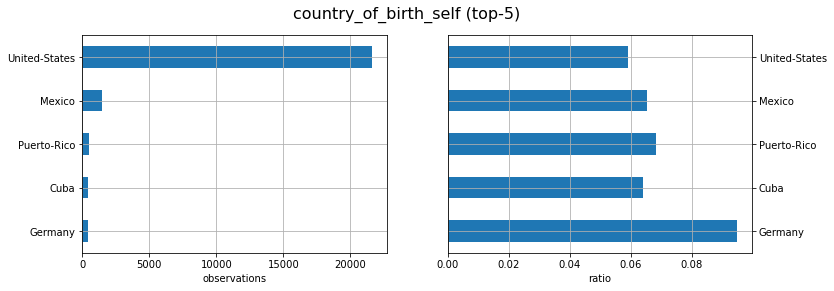

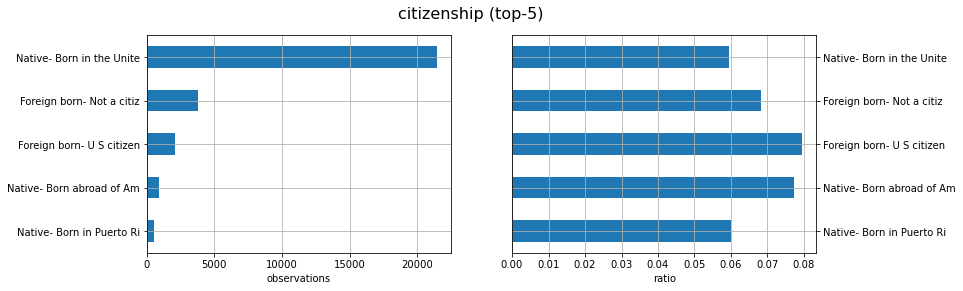

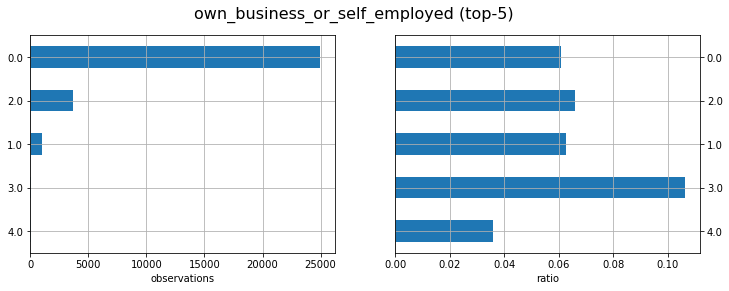

In [31]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = synt_data_distilgpt2.drop(['target'], axis=1).assign(cnt=1, target=synt_data_distilgpt2['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### GPT2XL 

In [32]:
synt_data_gpt2xl.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000           3.000000e+04                     30000.000000   
mean      36.743633           6.388734e+02                         2.815233   
std       34.919902           1.445951e+04                        69.317802   
min        0.000000           0.000000e+00                         0.000000   
25%       21.000000           0.000000e+00                         0.000000   
50%       35.000000           0.000000e+00                         2.000000   
75%       51.000000           1.000000e+00                         4.000000   
max     4950.000000           2.000000e+06                     12000.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                   30000.000000          30000.000000  
mean                        7.721633             24.491567  
std                       817.869465             49.141834  
min                         0.000000              0.000000  
25%                         0.000000              0.000000  
50%                         0.000000             22.000000  
75%                         0.000000             51.000000  
max                     99999.000000           7500.000000

In [33]:
print(synt_data_gpt2xl.isna().sum().sum())

0


In [34]:
synt_data_gpt2xl['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

<AxesSubplot:>

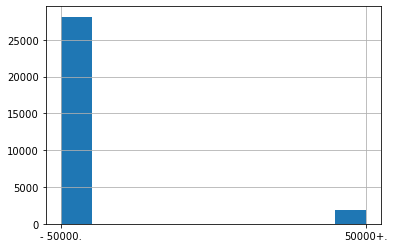

In [35]:
synt_data_gpt2xl['target'].hist()

In [36]:
print(f" Synthetic data for binary classification is imbalanced: {len(synt_data_cerebras[synt_data_gpt2xl['target']=='50000+.'])/len(synt_data_gpt2xl)*100:.2f}% and {100-len(synt_data_gpt2xl[synt_data_gpt2xl['target']=='50000+.'])/len(synt_data_gpt2xl)*100:.2f}%")

 Synthetic data for binary classification is imbalanced: 6.27% and 93.73%


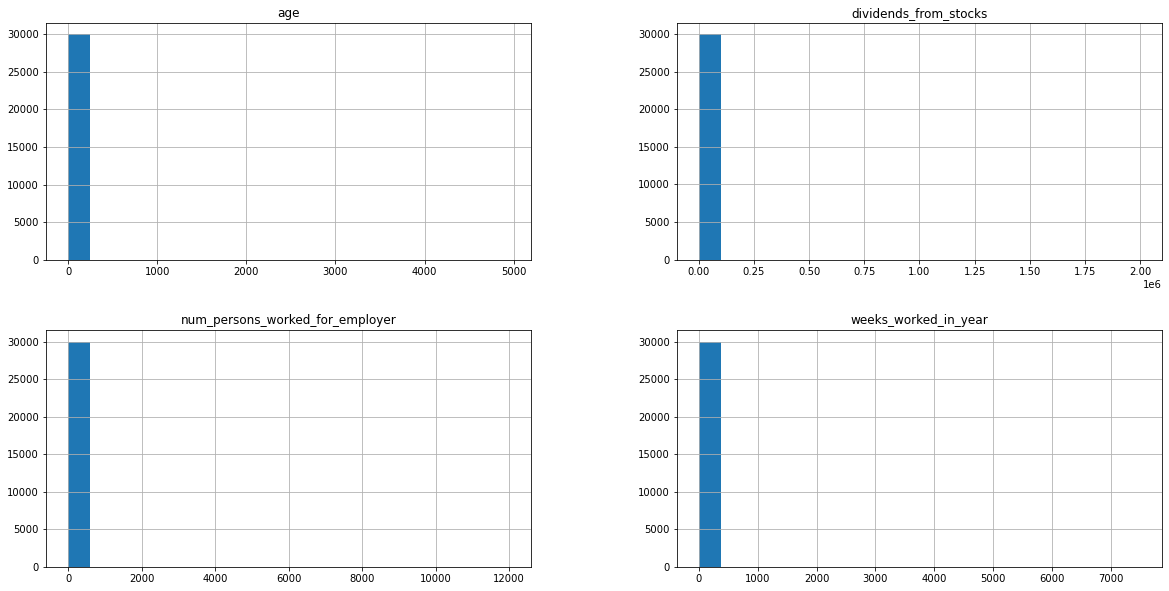

In [37]:
synt_data_gpt2xl[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 2))
plt.show()

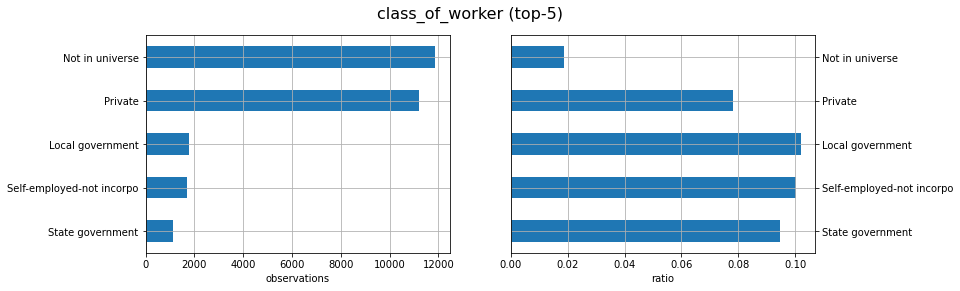

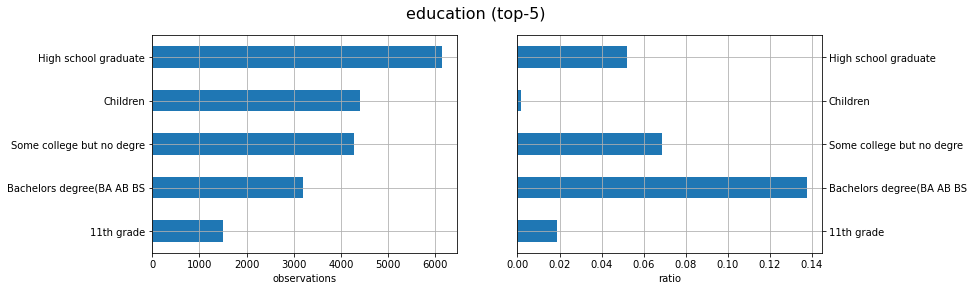

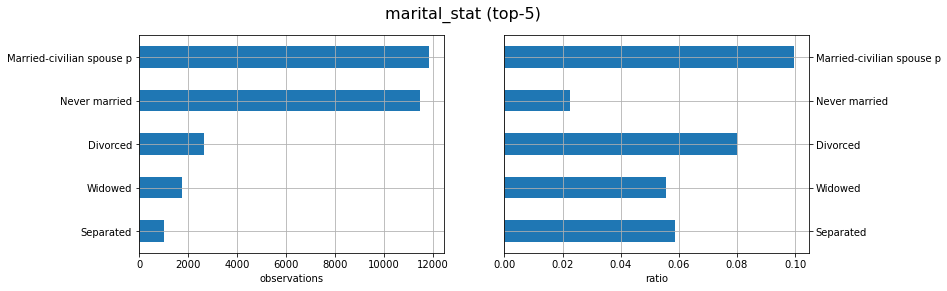

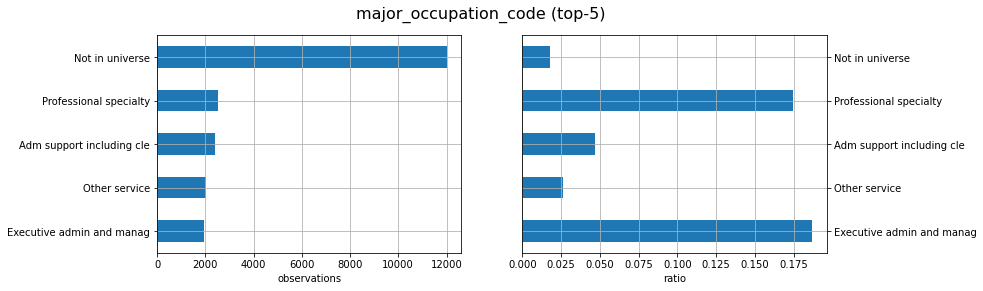

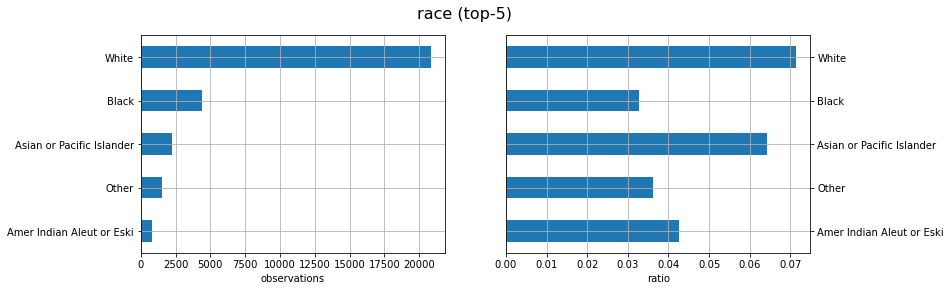

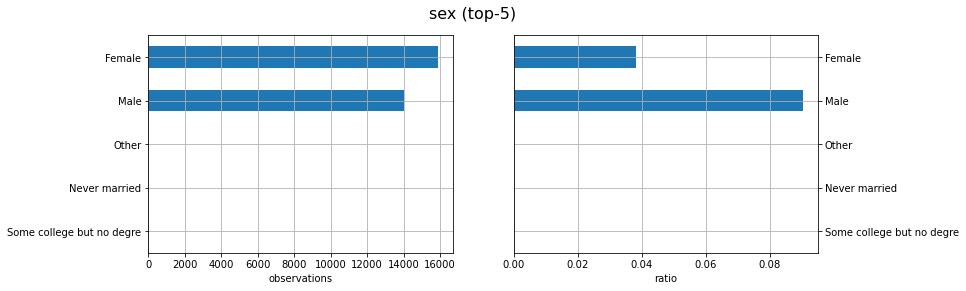

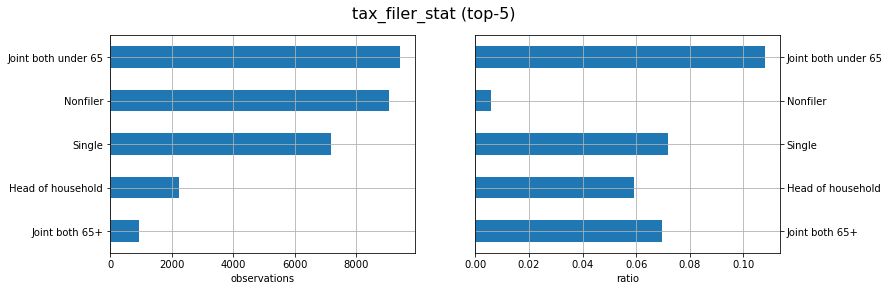

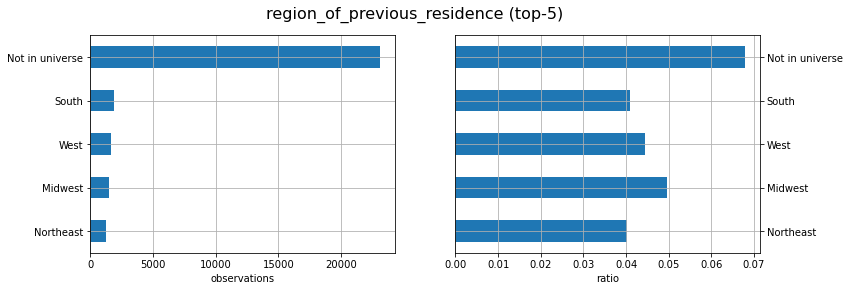

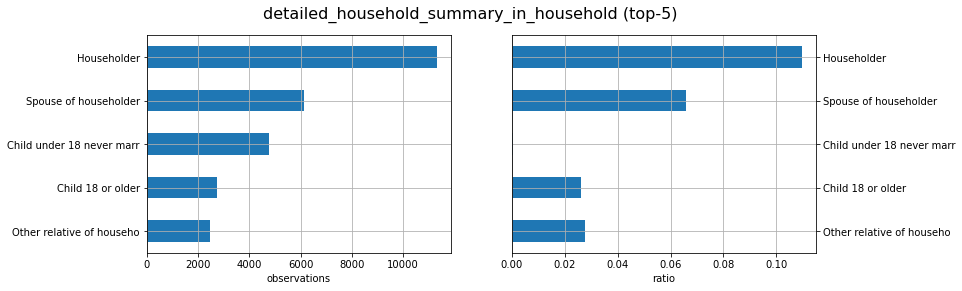

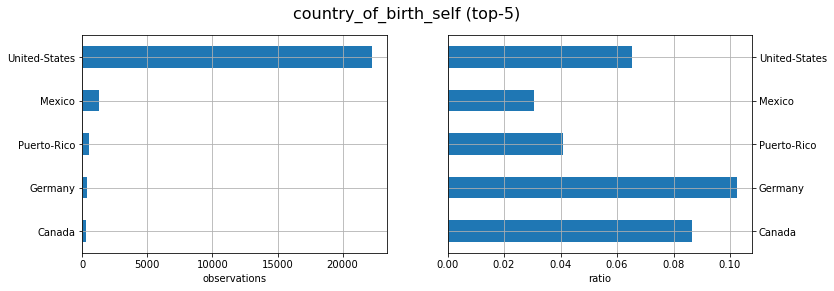

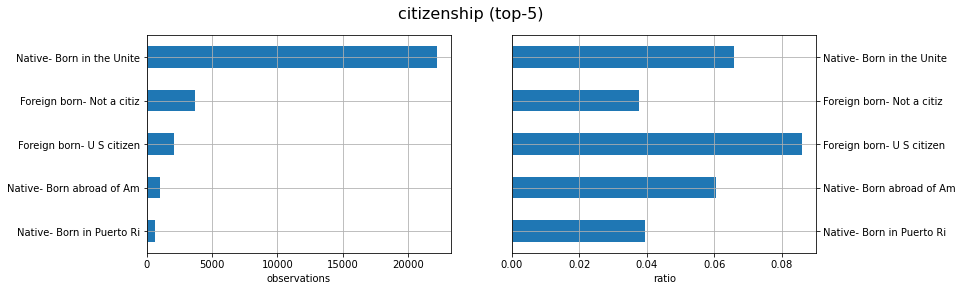

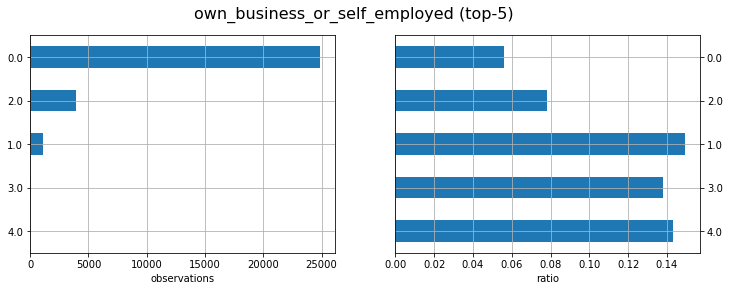

In [38]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = synt_data_gpt2xl.drop(['target'], axis=1).assign(cnt=1, target=synt_data_gpt2xl['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### Cerebras 

In [39]:
synt_data_cerebras.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000           30000.000000                      30000.00000   
mean      36.669833             544.424067                          2.65600   
std       26.218139            4382.022099                         31.99791   
min        0.000000               0.000000                          0.00000   
25%       21.000000               0.000000                          0.00000   
50%       35.000000               0.000000                          2.00000   
75%       51.000000               3.000000                          4.00000   
max     2900.000000          200500.000000                       5500.00000   

       own_business_or_self_employed  weeks_worked_in_year  
count                   30000.000000          30000.000000  
mean                        4.193433             24.631167  
std                       410.473433             40.511224  
min                         0.000000              0.000000  
25%                         0.000000              0.000000  
50%                         0.000000             24.000000  
75%                         0.000000             51.000000  
max                     50000.000000           5250.000000

In [40]:
print(synt_data_cerebras.isna().sum().sum())

0


In [41]:
synt_data_cerebras['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

<AxesSubplot:>

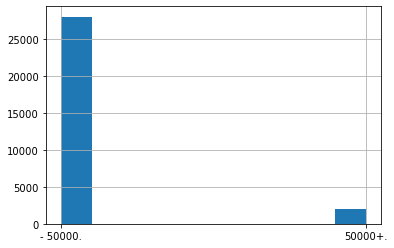

In [42]:
synt_data_cerebras['target'].hist()

In [43]:
print(f" Synthetic data for binary classification is imbalanced: {len(synt_data_cerebras[synt_data_cerebras['target']=='50000+.'])/len(synt_data_cerebras)*100:.2f}% and {100-len(synt_data_cerebras[synt_data_cerebras['target']=='50000+.'])/len(synt_data_cerebras)*100:.2f}%")

 Synthetic data for binary classification is imbalanced: 6.49% and 93.51%


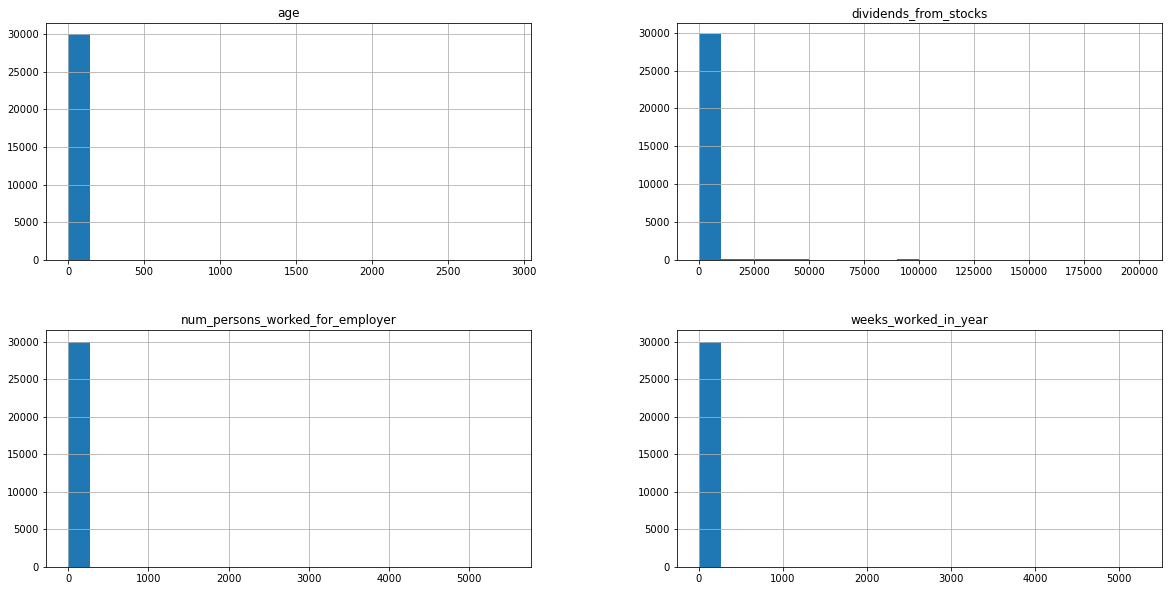

In [44]:
synt_data_cerebras[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 2))
plt.show()

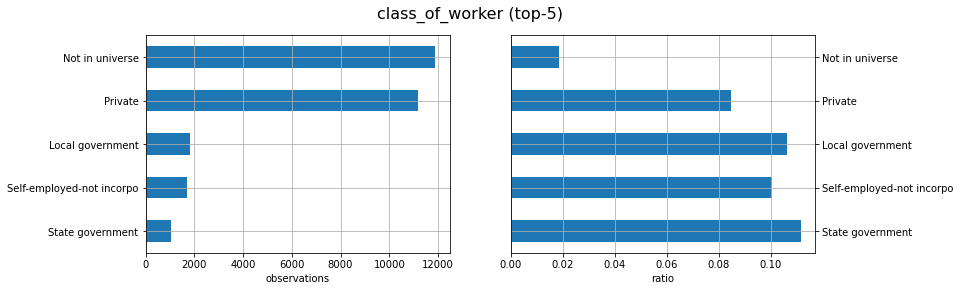

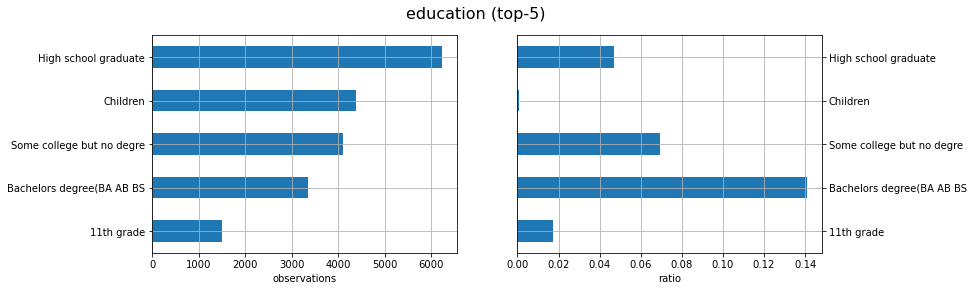

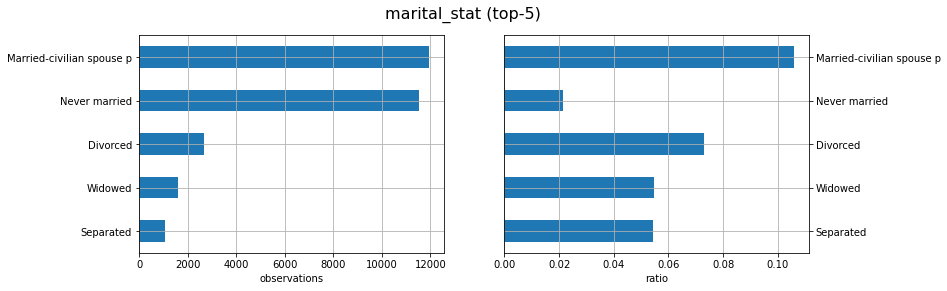

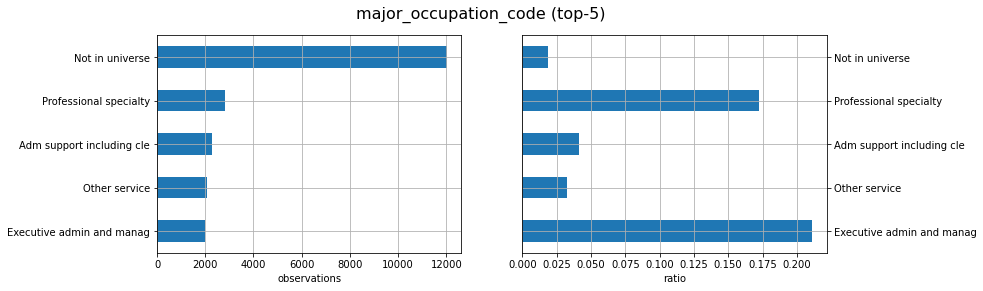

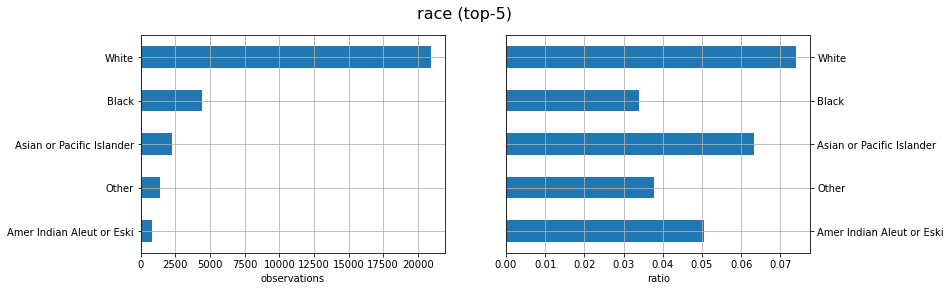

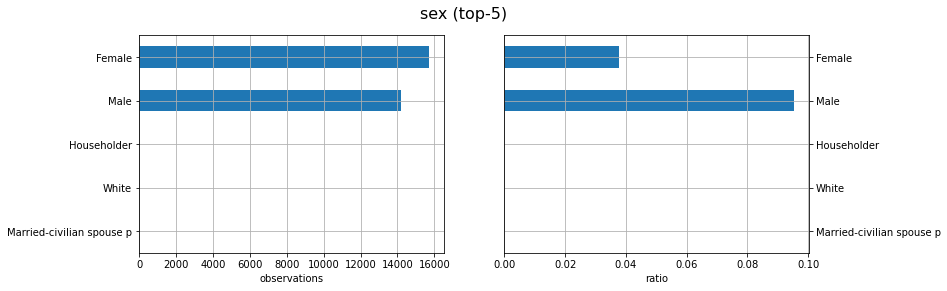

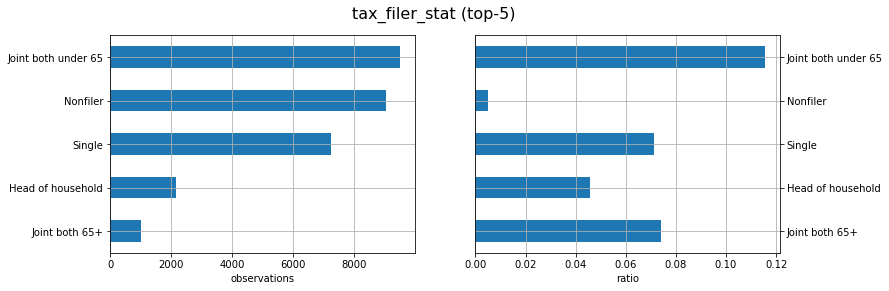

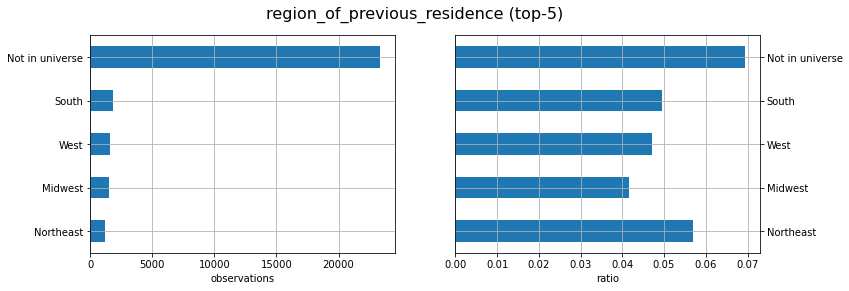

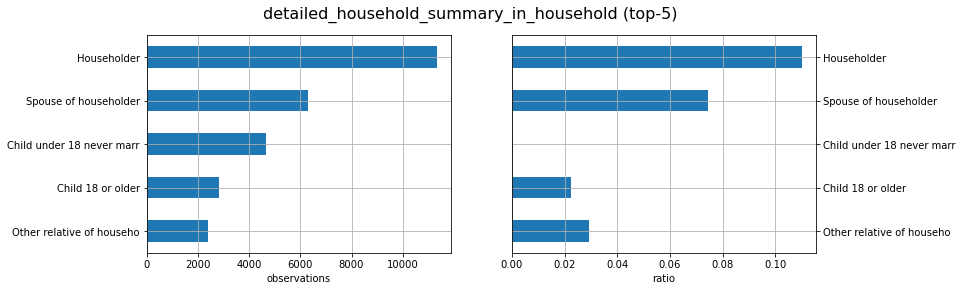

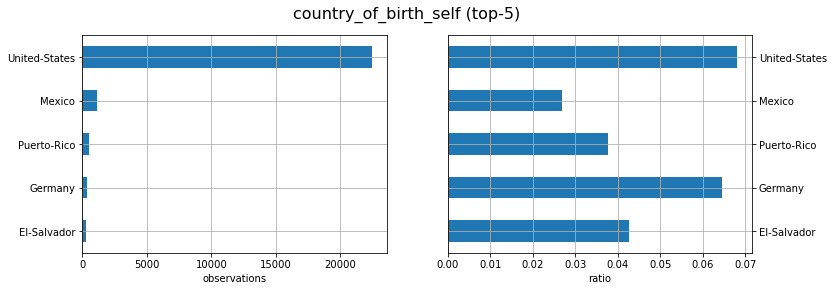

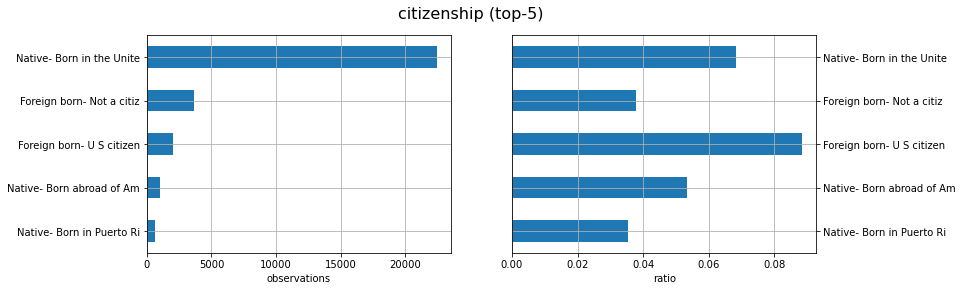

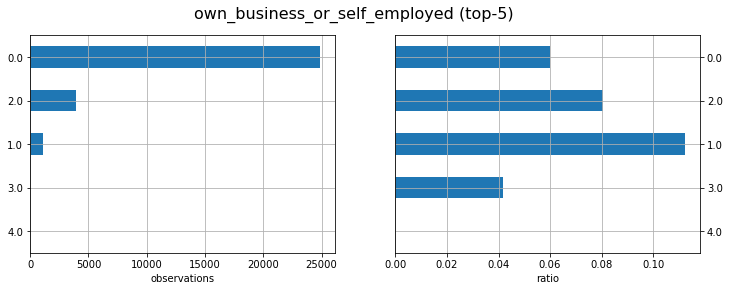

In [45]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = synt_data_cerebras.drop(['target'], axis=1).assign(cnt=1, target=synt_data_cerebras['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### Phi1.5 

In [46]:
synt_data_phi.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000           30000.000000                     30000.000000   
mean      36.622100             556.401400                         2.553700   
std       32.247844            5392.132742                        11.817762   
min        0.000000               0.000000                         0.000000   
25%       22.000000               0.000000                         0.000000   
50%       35.000000               0.000000                         1.000000   
75%       50.000000               0.000000                         4.000000   
max     3300.000000          409999.000000                      1000.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                   30000.000000          30000.000000  
mean                        0.387333             24.110233  
std                        11.605947             22.239753  
min                         0.000000              0.000000  
25%                         0.000000              0.000000  
50%                         0.000000             22.000000  
75%                         0.000000             51.000000  
max                      2000.000000             56.000000

In [47]:
print(synt_data_phi.isna().sum().sum())

0


In [48]:
synt_data_phi['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

<AxesSubplot:>

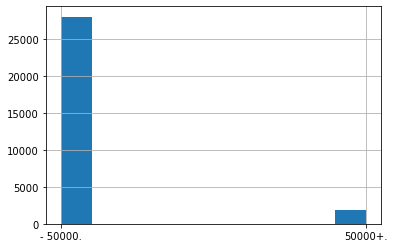

In [49]:
synt_data_phi['target'].hist()

In [50]:
print(f" Synthetic data for binary classification is imbalanced: {len(synt_data_phi[synt_data_phi['target']=='50000+.'])/len(synt_data_phi)*100:.2f}% and {100-len(synt_data_phi[synt_data_phi['target']=='50000+.'])/len(synt_data_phi)*100:.2f}%")

 Synthetic data for binary classification is imbalanced: 6.40% and 93.60%


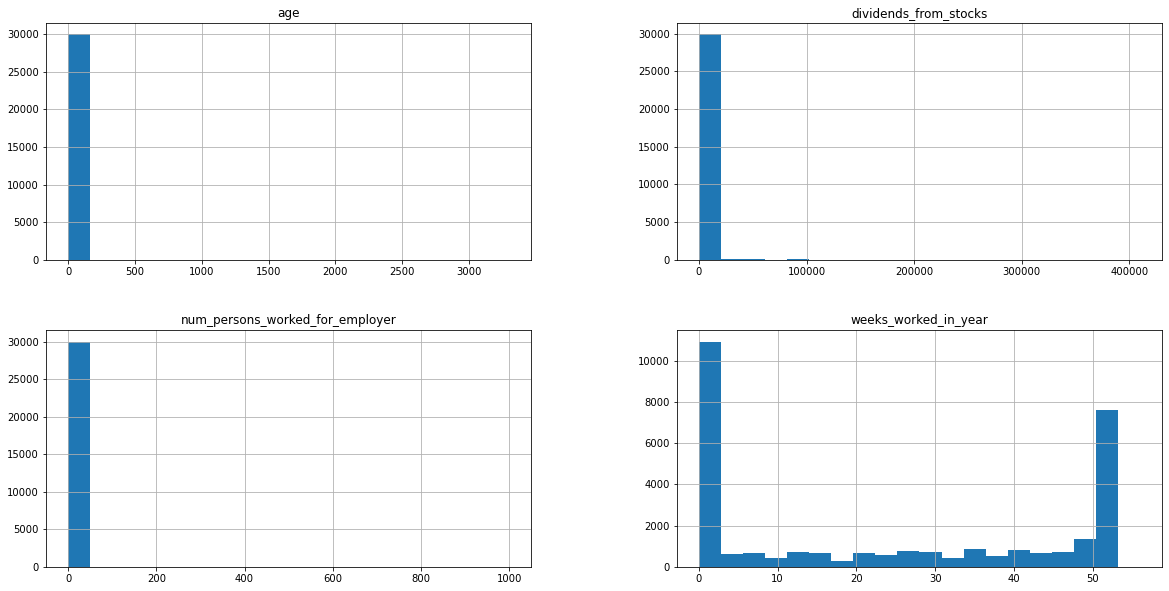

In [51]:
synt_data_phi[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 2))
plt.show()

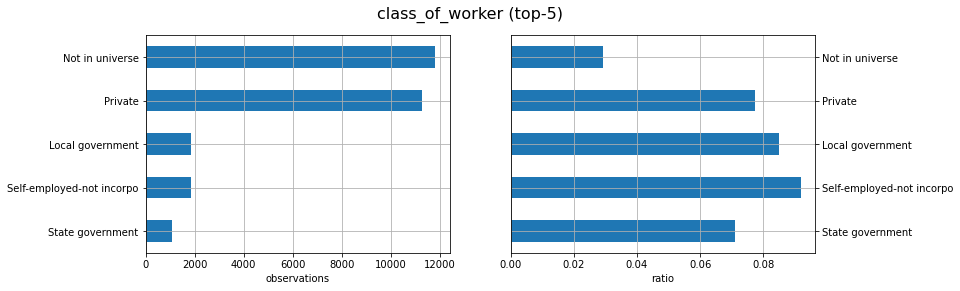

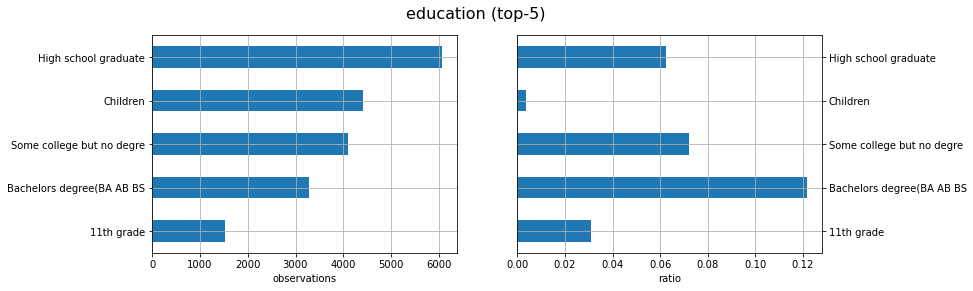

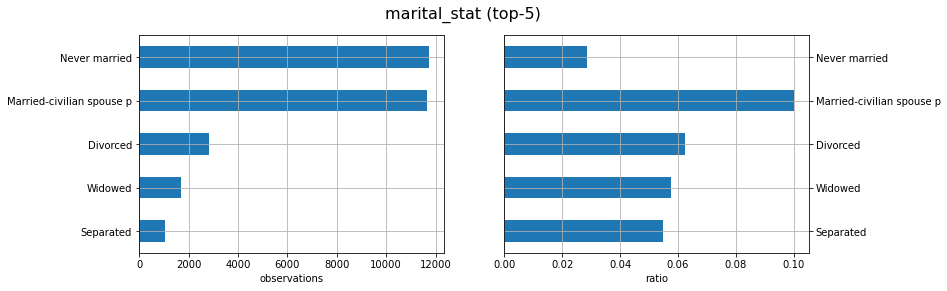

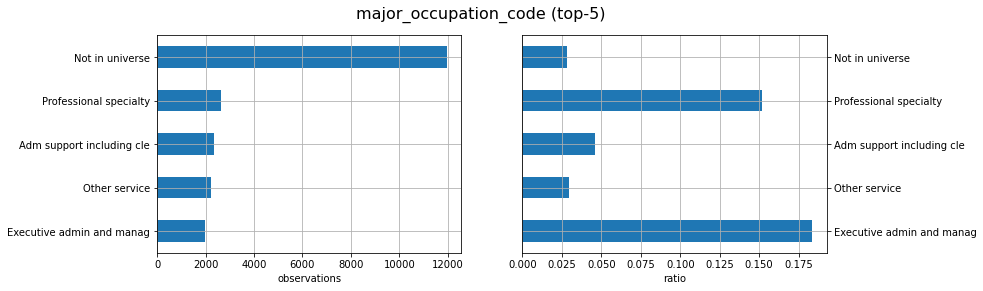

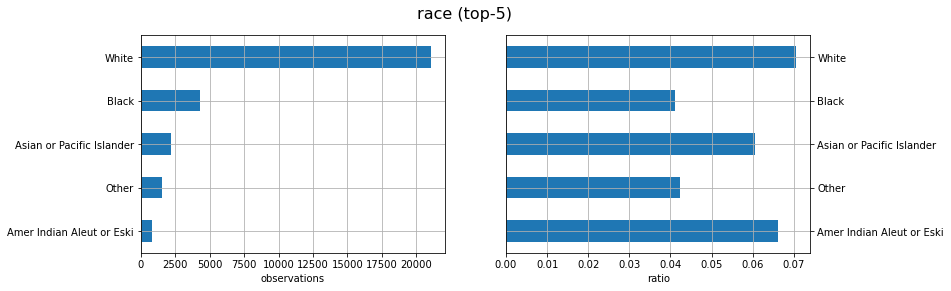

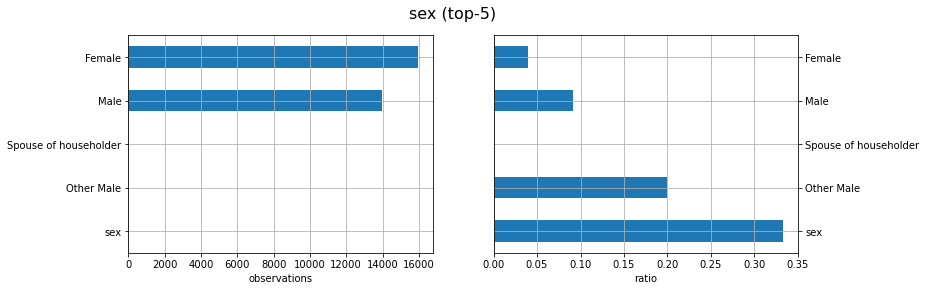

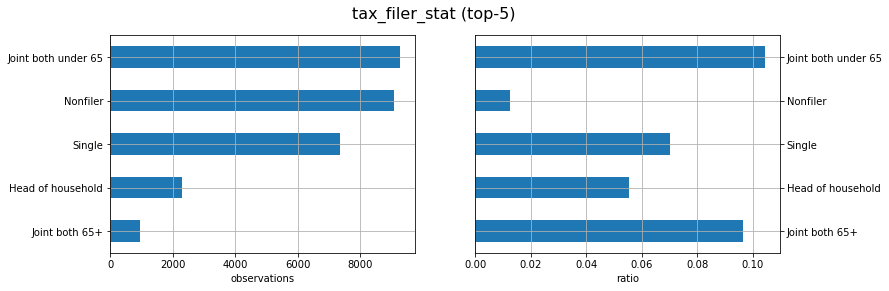

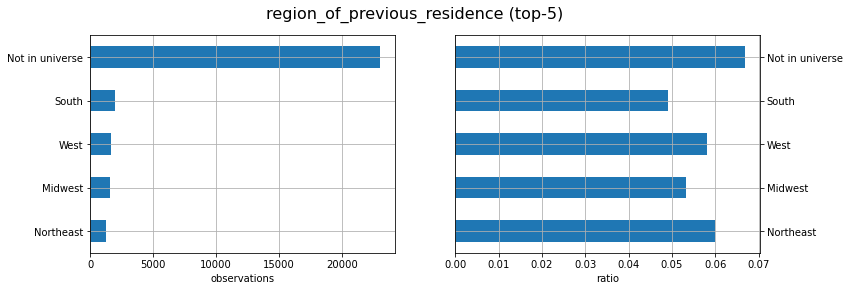

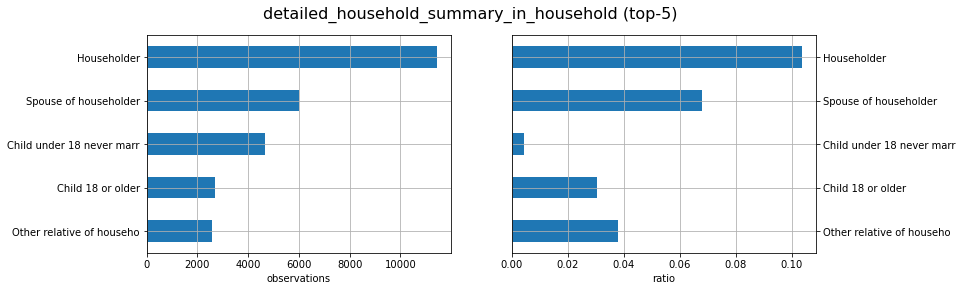

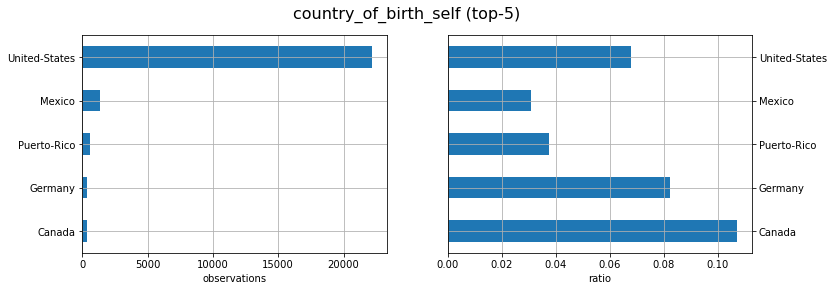

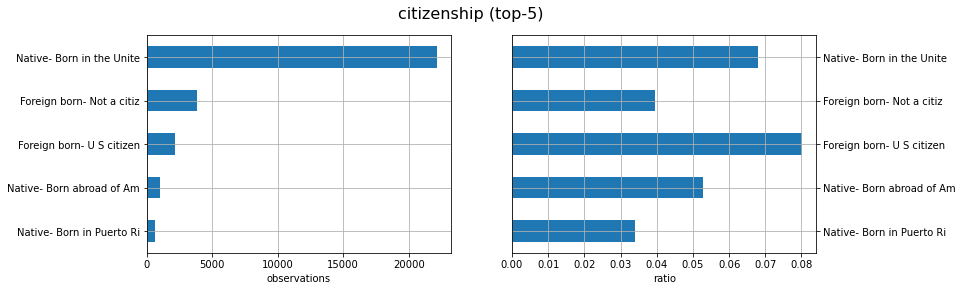

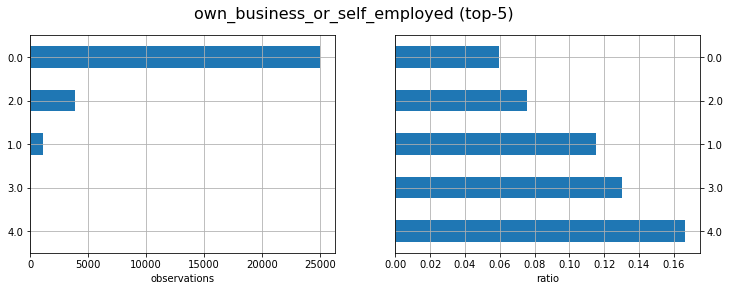

In [52]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = synt_data_phi.drop(['target'], axis=1).assign(cnt=1, target=synt_data_phi['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### Dataset comparsion

In [53]:
synt_datasets = dict()
synt_datasets['distilgpt2'] = synt_data_distilgpt2
synt_datasets['gpt2xl'] = synt_data_gpt2xl
synt_datasets['cerebras'] = synt_data_cerebras
synt_datasets['phi'] = synt_data_phi

In [54]:
cols_compare = dict()
for col in cols:
    cols_compare[col] = {}
    cols_compare[col]['real'] = real_dataset[col].to_numpy()
    for synt in synt_datasets:
        cols_compare[col][synt] = synt_datasets[synt][col].to_numpy()


In [55]:
all_data = list()
for col in cols :
    all_data.append((col,[x for x in [(i,cols_compare[col][i]) for i in cols_compare[col]]]))

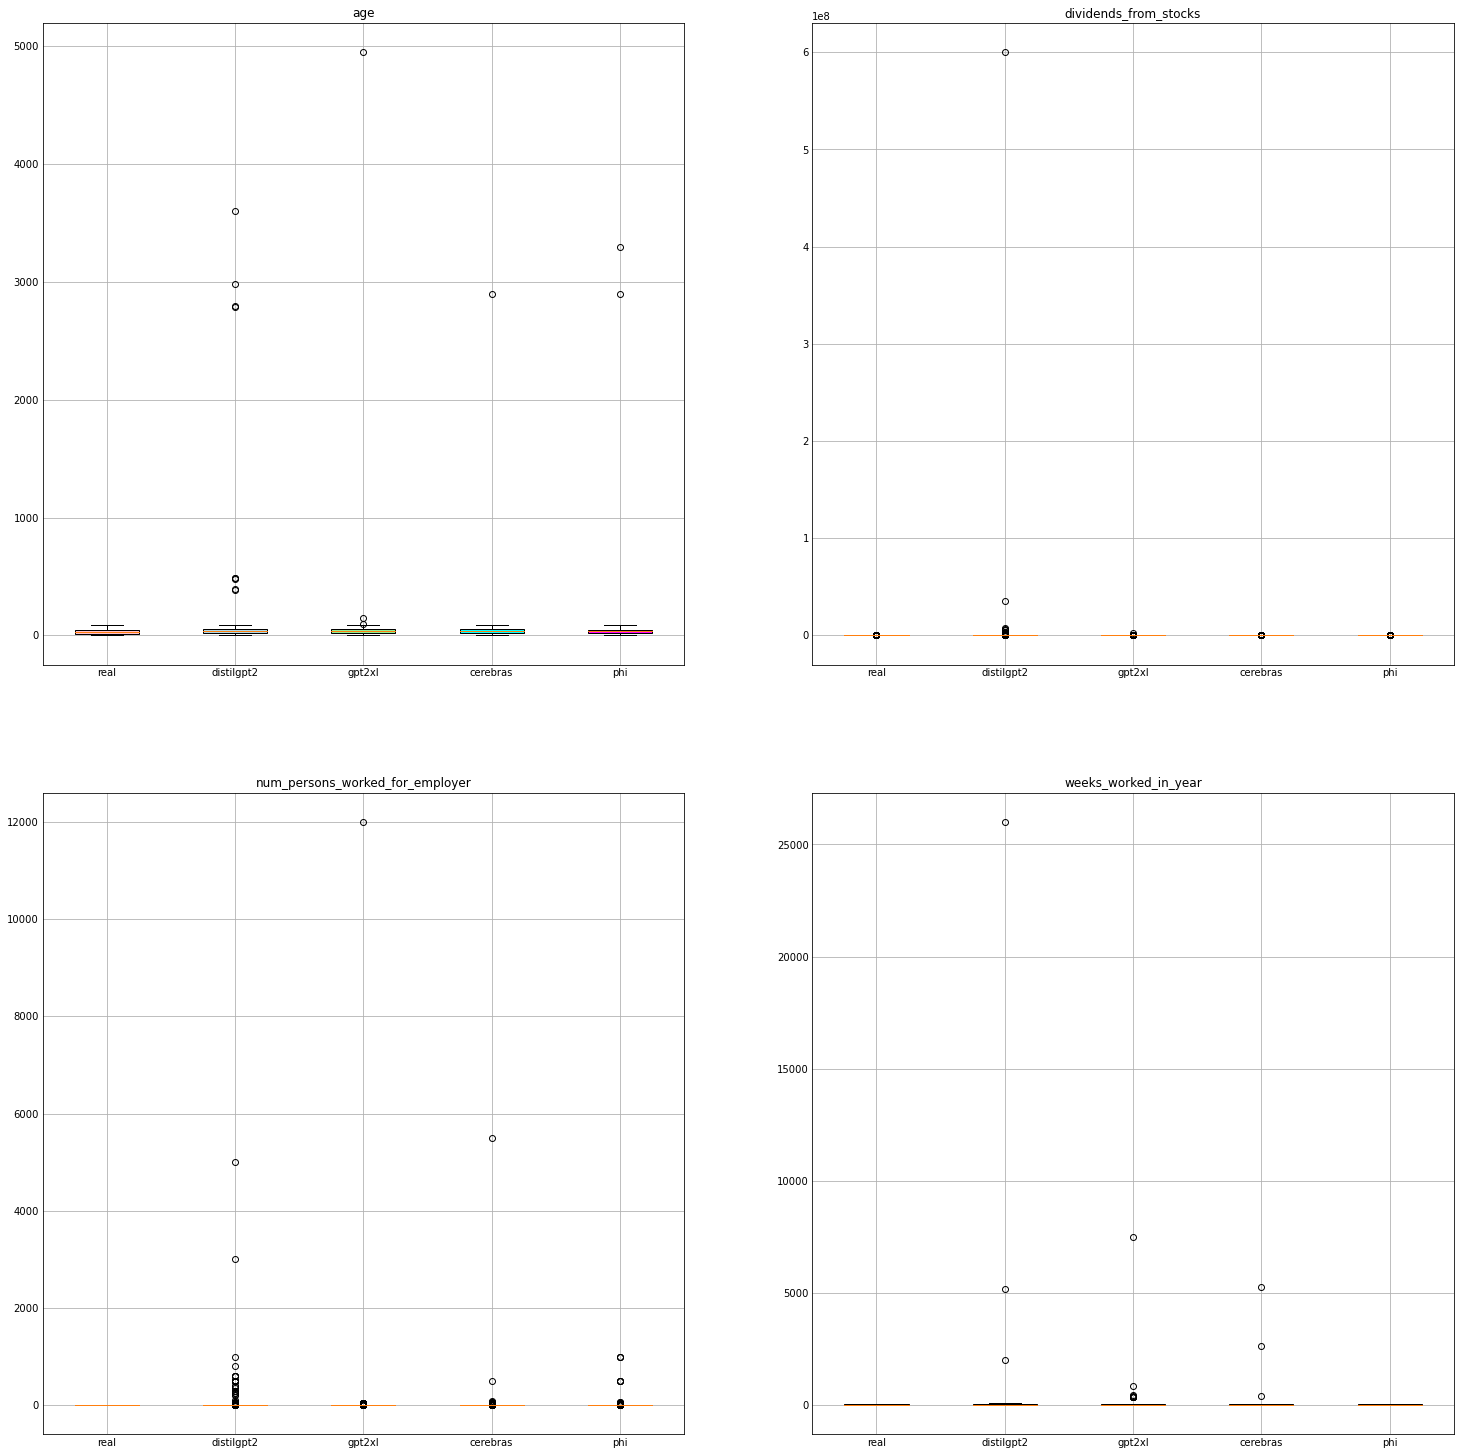

In [56]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery')

# make data:
ncols=2
nrows=2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
bplots = list()

i=0
for _, col in enumerate(all_data) :
    col_name = col[0]
    if not(col_name in numeric):
        continue
    col_data = col[1]
    rw = i//ncols
    cl = i%ncols
    i+=1
    axs[rw,cl].set_title(col_name)
     
    bplots.append(axs[rw,cl].boxplot([x[1] for x in col_data],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=[x[0] for x in col_data]))  # will be used to label x-ticks
           
#fill with colors
colors = ['pink', 'lightblue', 'lightgreen','cyan','magenta','yellow',]
for bplot in bplots:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

plt.show()

# Binary classification task on rough data

## General data preprocessing

In [57]:
to_encode = [i for i in categs]

In [58]:
to_encode

['class_of_worker',
 'education',
 'marital_stat',
 'major_occupation_code',
 'race',
 'sex',
 'tax_filer_stat',
 'region_of_previous_residence',
 'detailed_household_summary_in_household',
 'country_of_birth_self',
 'citizenship',
 'own_business_or_self_employed']

In [59]:
target_encoder= {' 50000+.': 1, 
                ' - 50000.': 0,
                '50000+.': 1, 
                '- 50000.': 0} 

In [60]:
edu_encoder= {' Children': 1, 
            ' Less than 1st grade': 2, 
            ' 1st 2nd 3rd or 4th grade': 3, 
            ' 5th or 6th grade': 4,
            ' 7th and 8th grade': 5, 
            ' 9th grade': 6, 
            ' 10th grade': 7, 
            ' 11th grade': 8 , 
            ' 12th grade no diploma': 9,
            ' High school graduate': 10, 
            ' Some college but no degree': 11, 
            ' Associates degree-occup /vocational': 12,
            ' Associates degree-academic program': 13, 
            ' Bachelors degree(BA AB BS)' : 14,
            ' Masters degree(MA MS MEng MEd MSW MBA)': 15,
            ' Doctorate degree(PhD EdD)': 16,
            ' Prof school degree (MD DDS DVM LLB JD)': 17,
            'Children': 1, 
            'Less than 1st grade': 2, 
            '1st 2nd 3rd or 4th grade': 3, 
            '5th or 6th grade': 4,
            '7th and 8th grade': 5, 
            '9th grade': 6, 
            '10th grade': 7, 
            '11th grade': 8 , 
            '12th grade no diploma': 9,
            'High school graduate': 10, 
            'Some college but no degree': 11, 
            'Associates degree-occup /vocational': 12,
            'Associates degree-academic program': 13, 
            'Bachelors degree(BA AB BS)' : 14,
            'Masters degree(MA MS MEng MEd MSW MBA)': 15,
            'Doctorate degree(PhD EdD)': 16,
            'Prof school degree (MD DDS DVM LLB JD)': 17}
to_encode.remove('education')

## Real data preprocessing and classification modeling

### Data preprocessing

In [61]:
real_data = real_dataset.copy()

In [62]:
X_tr, X_te, y_tr, y_te = train_test_split(real_data.drop(columns = ['target']),real_data['target'],test_size=0.2, random_state=random_state,stratify=real_data['target'])

In [63]:
X_te_real_validate = X_te.copy()
y_te_real_validate = y_te.copy()

In [64]:
print(real_data['target'].unique(), len(real_data['target'].unique()))

['- 50000.' '50000+.'] 2


In [65]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)

In [66]:
print(y_tr.unique(), len(y_tr.unique()))

[0 1] 2


In [67]:
print(real_data['education'].unique(), len(real_data['education'].unique()))

['Some college but no degree' 'Bachelors degree(BA AB BS)'
 '7th and 8th grade' 'Children' 'High school graduate' '10th grade'
 'Masters degree(MA MS MEng MEd MSW MBA)'
 'Associates degree-occup /vocational' '11th grade' '5th or 6th grade'
 '9th grade' 'Doctorate degree(PhD EdD)' '1st 2nd 3rd or 4th grade'
 'Associates degree-academic program' 'Less than 1st grade'
 '12th grade no diploma' 'Prof school degree (MD DDS DVM LLB JD)'] 17


In [68]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)

In [69]:
print(X_tr['education'].unique(), len(X_tr['education'].unique()))

[ 5 11  1 15 10 14  9 12  6  2 13  7  3  8  4 17 16] 17


In [70]:
to_encode_real = to_encode.copy() 

In [71]:
# mean target encoding
for i in to_encode_real.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes[x])
        to_encode_real.remove(i)

+ marital_stat
+ race
+ sex
+ tax_filer_stat
+ region_of_previous_residence
+ citizenship
+ own_business_or_self_employed


In [72]:
#frequency encoding 
for i in to_encode_real.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    to_encode_real.remove(i)

+ class_of_worker
+ major_occupation_code
+ detailed_household_summary_in_household
+ country_of_birth_self


In [73]:
to_encode_real

[]

In [74]:
print(X_tr.isna().sum().sum())
print(X_te.isna().sum().sum())

0
0


In [75]:
X_tr.dtypes

age                                          int64
class_of_worker                            float64
education                                    int64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                        int64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer              int64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                         int64
dtype: object

### Features selection

In [76]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix


age  class_of_worker  education  \
age                                      1.000000        -0.273832   0.554347   
class_of_worker                         -0.273832         1.000000  -0.586404   
education                                0.554347        -0.586404   1.000000   
marital_stat                             0.680123        -0.380808   0.535738   
major_occupation_code                   -0.235530         0.860999  -0.485680   
race                                     0.068959        -0.053021   0.100718   
sex                                     -0.038577        -0.094046   0.005064   
dividends_from_stocks                    0.256355        -0.134686   0.309286   
tax_filer_stat                           0.471370        -0.632230   0.660937   
region_of_previous_residence             0.090736         0.014371   0.001013   
detailed_household_summary_in_household  0.252836        -0.083663   0.108197   
num_persons_worked_for_employer          0.245655        -0.764200   0.587607   
country_of_birth_self                   -0.072291         0.035267  -0.025496   
citizenship                              0.046291        -0.014168   0.065853   
own_business_or_self_employed            0.030568        -0.269053   0.216898   
weeks_worked_in_year                     0.286815        -0.835988   0.604476   
target                                   0.169496        -0.241753   0.304604   

                                         marital_stat  major_occupation_code  \
age                                          0.680123              -0.235530   
class_of_worker                             -0.380808               0.860999   
education                                    0.535738              -0.485680   
marital_stat                                 1.000000              -0.337805   
major_occupation_code                       -0.337805               1.000000   
race                                         0.109519              -0.045462   
sex                                         -0.007314              -0.175800   
dividends_from_stocks                        0.230006              -0.079366   
tax_filer_stat                               0.760664              -0.601035   
region_of_previous_residence                 0.049349               0.022531   
detailed_household_summary_in_household      0.178682              -0.087470   
num_persons_worked_for_employer              0.359423              -0.736346   
country_of_birth_self                       -0.078488               0.064963   
citizenship                                  0.017042               0.017550   
own_business_or_self_employed                0.084303              -0.258446   
weeks_worked_in_year                         0.413837              -0.807133   
target                                       0.200576              -0.180488   

                                             race       sex  \
age                                      0.068959 -0.038577   
class_of_worker                         -0.053021 -0.094046   
education                                0.100718  0.005064   
marital_stat                             0.109519 -0.007314   
major_occupation_code                   -0.045462 -0.175800   
race                                     1.000000  0.022378   
sex                                      0.022378  1.000000   
dividends_from_stocks                    0.081465  0.031495   
tax_filer_stat                           0.114606  0.037119   
region_of_previous_residence             0.022446  0.001121   
detailed_household_summary_in_household  0.012262  0.242139   
num_persons_worked_for_employer          0.036247  0.072372   
country_of_birth_self                   -0.120298  0.014380   
citizenship                              0.001725  0.010086   
own_business_or_self_employed            0.030773  0.036088   
weeks_worked_in_year                     0.062989  0.110199   
target                                   0.056979  0.168318   

           

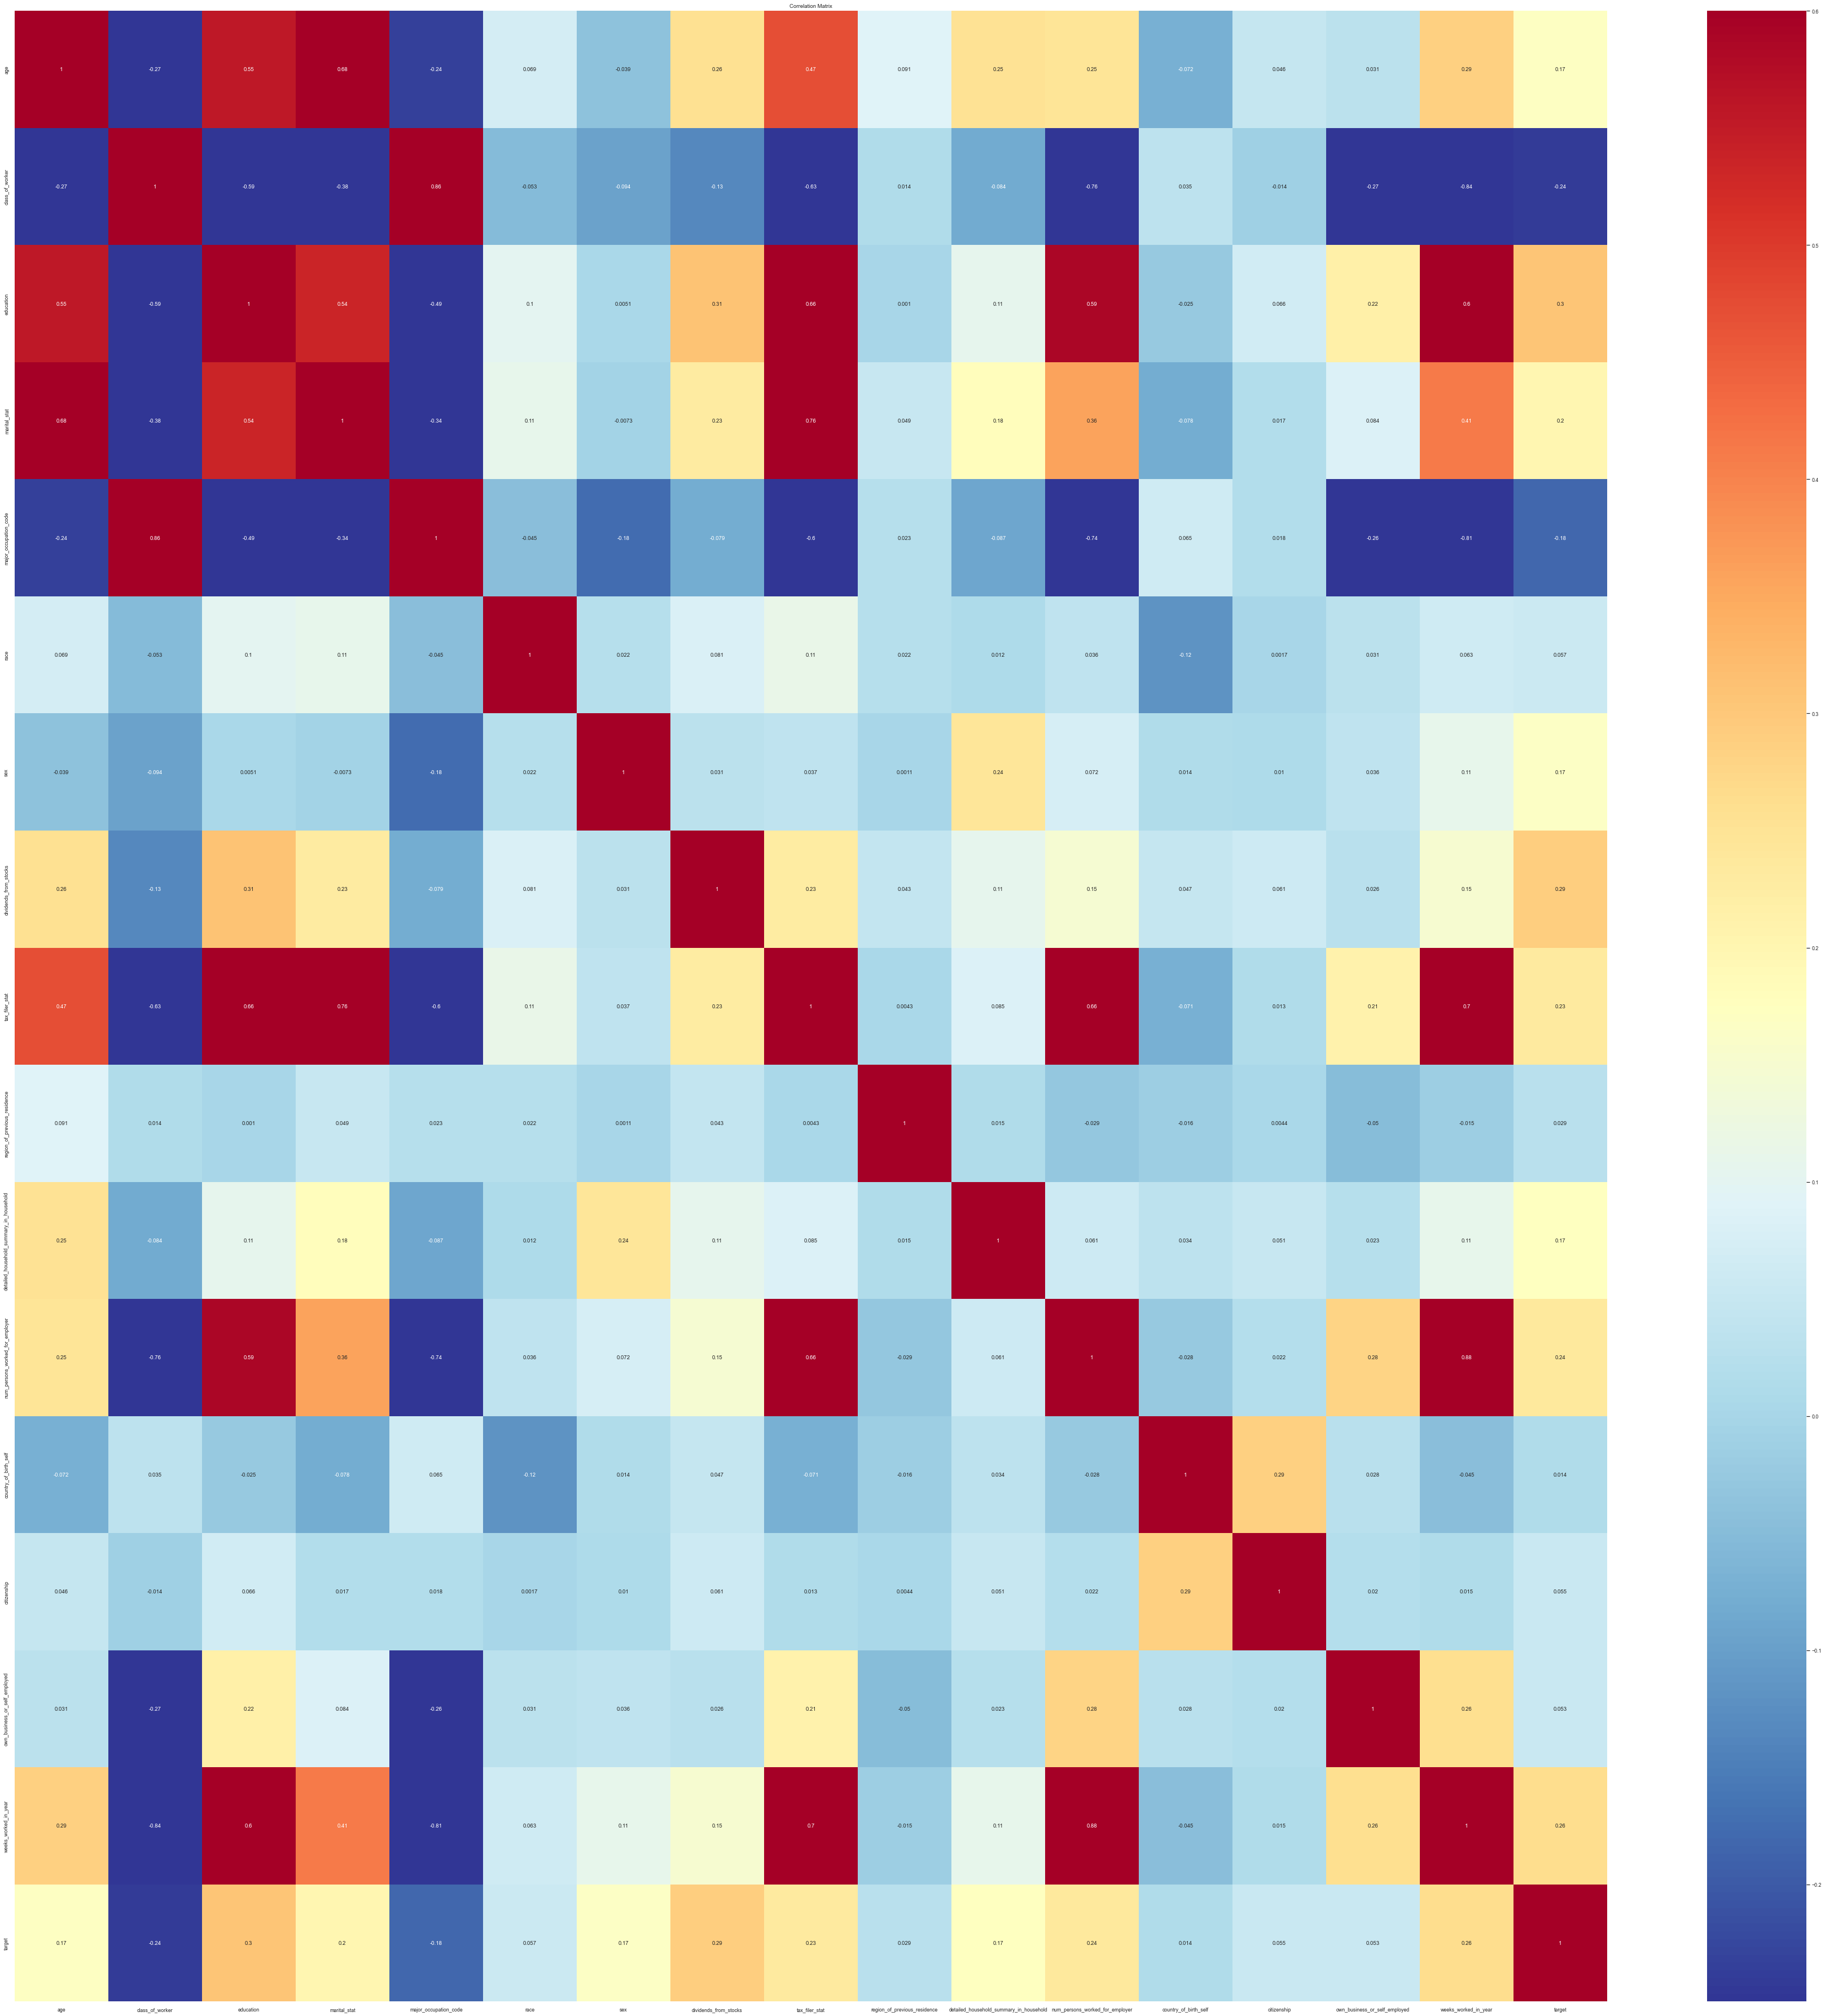

In [77]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [78]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.8:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 3
The number of features remaining: 13


In [79]:
del_features

array(['class_of_worker', 'major_occupation_code',
       'num_persons_worked_for_employer'], dtype='<U31')

In [80]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 13


In [81]:
real_model_features = count_features.copy()
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic Regression

In [82]:
#X_tr, X_te_real, y_tr, y_te_real = train_test_split(real_data[count_features],real_data['target'],test_size=0.2, random_state=random_state,stratify=real_data['target'])

In [83]:
X_tr = X_tr[count_features]
X_te = X_te[count_features]

In [84]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr, y_tr)

CPU times: total: 359 ms
Wall time: 393 ms


In [85]:
log_pipe = Pipeline([
    ('Scaler', StandardScaler()),
    ('LR', LogisticRegression())
])

log_parameters = {
    'LR__solver': ['saga'],
    'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
}


In [86]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.838 total time=   0.3s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.823 total time=   0.3s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.830 total time=   0.3s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.839 total time=   0.3s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.825 total time=   0.3s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.848 total time=   0.3s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.845 total time=   0.4s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.840 total time=   0.3s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.854 total time=   0.3s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.835 total time=   0.3s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.852 total time=   0.3s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [87]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.8464060619430963
LogisticRegression(C=0.1, solver='saga')


In [88]:
y_pred_test = grid_pipe_log.best_estimator_.predict(X_te)

In [89]:
model_results = pd.DataFrame(columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test = pd.DataFrame([['LogRegression Real data','Real test',
                        balanced_accuracy_score(y_te, y_pred_test),
                        recall_score(y_te, y_pred_test),
                        precision_score(y_te, y_pred_test),
                        roc_auc_score(y_te, y_pred_test)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test],axis=0)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_7460\616206078.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_results = pd.concat([model_results, res_test],axis=0)


In [90]:
res_test

Model    Dataset  Balanced_accuracy    Recall  Precision  \
0  LogRegression Real data  Real test            0.84528  0.888889   0.231564   

   ROC_AUC  
0  0.84528

In [91]:
model_results

Model    Dataset  Balanced_accuracy    Recall  Precision  \
0  LogRegression Real data  Real test            0.84528  0.888889   0.231564   

   ROC_AUC  
0  0.84528

## DistillGPT2 classification

### Data preprocessing 

In [92]:
synt_data = synt_data_distilgpt2.copy()

In [93]:
X_tr, X_te, y_tr, y_te = train_test_split(synt_data.drop(columns = ['target']),synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [94]:
X_te_real = X_te_real_validate.copy()
y_te_real = y_te_real_validate.copy()

In [95]:
print(synt_data['target'].unique(), len(synt_data['target'].unique()))

['- 50000.' '50000+.'] 2


In [96]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)
y_te_real = y_te_real.map(target_encoder) 

In [97]:
print(y_tr.unique(), len(y_tr.unique()))

[0 1] 2


In [98]:
print(synt_data['education'].unique(), len(synt_data['education'].unique()))

['12th grade no diploma' 'High school graduate' '10th grade'
 'Some college but no degree' 'Bachelors degree(BA AB BS)' 'Children'
 '5th or 6th grade' 'Associates degree-occup /vocational'
 'Prof school degree' '9th grade' '11th grade'
 'Masters degree(MA MS MEng MEd MSW MBA)' '7th and 8th grade'
 'Doctorate degree(PhD EdD)' 'Prof school degree (MD DDS DVM LLB JD)'
 '6th and 8th grade no degree' '1st 2nd 3rd or 4th grade'
 'Associates degree-academic program' '3rd or fourth grade'
 '6th and 7th grade' '7th and 4th grade' 'Prof school degree (BA AB BS)'
 '40th grade' 'Less than 1st grade'
 'Bachelors degree(BA AB Bachelors degree(BA AB BS)'
 'Prof school degree (MD DVM LLB JD)' 'Widowed' '16th grade no diploma'
 'Associates degree-occup 40000+.' 'Adm support including clerical'
 'Never married' 'Associates degree- 11th grade'
 'Less than grade school graduate' 'Bachelors degree(BA AB Doctor)'
 'Self-employed-incorporated' 'Associates degree-eks_in_year'
 '1st 2nd 3rd or 6th grade' '0' '

In [99]:
for edu in synt_data['education'].unique():
    if edu in edu_encoder.keys() :
        continue
    else :
        edu_encoder[edu] = 0
        print (edu)
edu_encoder

Prof school degree
6th and 8th grade no degree
3rd or fourth grade
6th and 7th grade
7th and 4th grade
Prof school degree (BA AB BS)
40th grade
Bachelors degree(BA AB Bachelors degree(BA AB BS)
Prof school degree (MD DVM LLB JD)
Widowed
16th grade no diploma
Associates degree-occup 40000+.
Adm support including clerical
Never married
Associates degree- 11th grade
Less than grade school graduate
Bachelors degree(BA AB Doctor)
Self-employed-incorporated
Associates degree-eks_in_year
1st 2nd 3rd or 6th grade
0
Spouse of householder
Native- Born in the United States
10 Children
Associates degree-and_occup /vocational
15th grade
1st 2nd or 4th grade
17th and 8th grade
Prof school degree (MD DDS DVM AB BS)
Householder
Foreign born- Not a citizen of U S
1225+
Divorced
Other
Associates degree-enrollment degree-occup /vocational
Masters degree(MA MS MSE MS MND DVM LLB JD)
education
Private
1st 1st 2nd 2nd 3rd or 4th grade
MBA school graduate
6th and 8th grade
Federal government
Prof school degr

{' Children': 1,
 ' Less than 1st grade': 2,
 ' 1st 2nd 3rd or 4th grade': 3,
 ' 5th or 6th grade': 4,
 ' 7th and 8th grade': 5,
 ' 9th grade': 6,
 ' 10th grade': 7,
 ' 11th grade': 8,
 ' 12th grade no diploma': 9,
 ' High school graduate': 10,
 ' Some college but no degree': 11,
 ' Associates degree-occup /vocational': 12,
 ' Associates degree-academic program': 13,
 ' Bachelors degree(BA AB BS)': 14,
 ' Masters degree(MA MS MEng MEd MSW MBA)': 15,
 ' Doctorate degree(PhD EdD)': 16,
 ' Prof school degree (MD DDS DVM LLB JD)': 17,
 'Children': 1,
 'Less than 1st grade': 2,
 '1st 2nd 3rd or 4th grade': 3,
 '5th or 6th grade': 4,
 '7th and 8th grade': 5,
 '9th grade': 6,
 '10th grade': 7,
 '11th grade': 8,
 '12th grade no diploma': 9,
 'High school graduate': 10,
 'Some college but no degree': 11,
 'Associates degree-occup /vocational': 12,
 'Associates degree-academic program': 13,
 'Bachelors degree(BA AB BS)': 14,
 'Masters degree(MA MS MEng MEd MSW MBA)': 15,
 'Doctorate degree(PhD E

In [100]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)
X_te_real['education'] = X_te_real['education'].map(edu_encoder)

In [101]:
to_encode_synt = to_encode.copy() 

In [102]:
# mean target encoding
for i in to_encode_synt.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    codes_ext = codes.copy()
    for t in X_te[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    for t in X_te_real[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes_ext[x])
        X_te_real[i] = X_te_real[i].map(lambda x: codes_ext[x])
        to_encode_synt.remove(i)

In [103]:
#frequency encoding 
for i in to_encode_synt.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    X_te_real[i] = X_te_real[i].map(codes)
    to_encode_synt.remove(i)

+ class_of_worker
+ marital_stat
+ major_occupation_code
+ race
+ sex
+ tax_filer_stat
+ region_of_previous_residence
+ detailed_household_summary_in_household
+ country_of_birth_self
+ citizenship
+ own_business_or_self_employed


In [104]:
print(X_tr.isna().sum())

age                                        0
class_of_worker                            1
education                                  0
marital_stat                               0
major_occupation_code                      0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    0
num_persons_worked_for_employer            0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64


In [105]:
X_tr.dtypes

age                                        float64
class_of_worker                            float64
education                                    int64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                      float64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer            float64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                       float64
dtype: object

### Features selection 

In [106]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix


age  class_of_worker  education  \
age                                      1.000000        -0.128400   0.269479   
class_of_worker                         -0.128400         1.000000  -0.322672   
education                                0.269479        -0.322672   1.000000   
marital_stat                             0.099613        -0.097140   0.115547   
major_occupation_code                   -0.101057         0.679884  -0.255185   
race                                     0.040268        -0.008943   0.028764   
sex                                      0.033401         0.032132  -0.001810   
dividends_from_stocks                    0.221572        -0.135385   0.226268   
tax_filer_stat                          -0.107970        -0.038009   0.015017   
region_of_previous_residence             0.046377         0.012980  -0.003674   
detailed_household_summary_in_household  0.356607        -0.140689   0.178341   
num_persons_worked_for_employer          0.085083        -0.483327   0.323101   
country_of_birth_self                   -0.041646         0.022401   0.011821   
citizenship                             -0.035657         0.019352   0.020181   
own_business_or_self_employed           -0.008848         0.186564  -0.121191   
weeks_worked_in_year                     0.133631        -0.573333   0.339223   
target                                   0.093577        -0.058547   0.058434   

                                         marital_stat  major_occupation_code  \
age                                          0.099613              -0.101057   
class_of_worker                             -0.097140               0.679884   
education                                    0.115547              -0.255185   
marital_stat                                 1.000000              -0.071645   
major_occupation_code                       -0.071645               1.000000   
race                                         0.034465              -0.013304   
sex                                         -0.012337               0.062427   
dividends_from_stocks                        0.107466              -0.103335   
tax_filer_stat                               0.425844              -0.017043   
region_of_previous_residence                 0.015841               0.014611   
detailed_household_summary_in_household      0.111368              -0.133004   
num_persons_worked_for_employer              0.081566              -0.481357   
country_of_birth_self                        0.004416               0.031805   
citizenship                                  0.000802               0.029643   
own_business_or_self_employed               -0.019866               0.180427   
weeks_worked_in_year                         0.101790              -0.554447   
target                                       0.026090              -0.044181   

                                             race       sex  \
age                                      0.040268  0.033401   
class_of_worker                         -0.008943  0.032132   
education                                0.028764 -0.001810   
marital_stat                             0.034465 -0.012337   
major_occupation_code                   -0.013304  0.062427   
race                                     1.000000  0.003165   
sex                                      0.003165  1.000000   
dividends_from_stocks                    0.022976 -0.002239   
tax_filer_stat                           0.013929 -0.004303   
region_of_previous_residence             0.023993  0.000218   
detailed_household_summary_in_household  0.034863 -0.076083   
num_persons_worked_for_employer          0.017944 -0.016393   
country_of_birth_self                    0.156184 -0.000839   
citizenship                              0.143145  0.001822   
own_business_or_self_employed           -0.001482  0.026143   
weeks_worked_in_year                     0.013797 -0.024201   
target                                   0.001585 -0.034039   

           

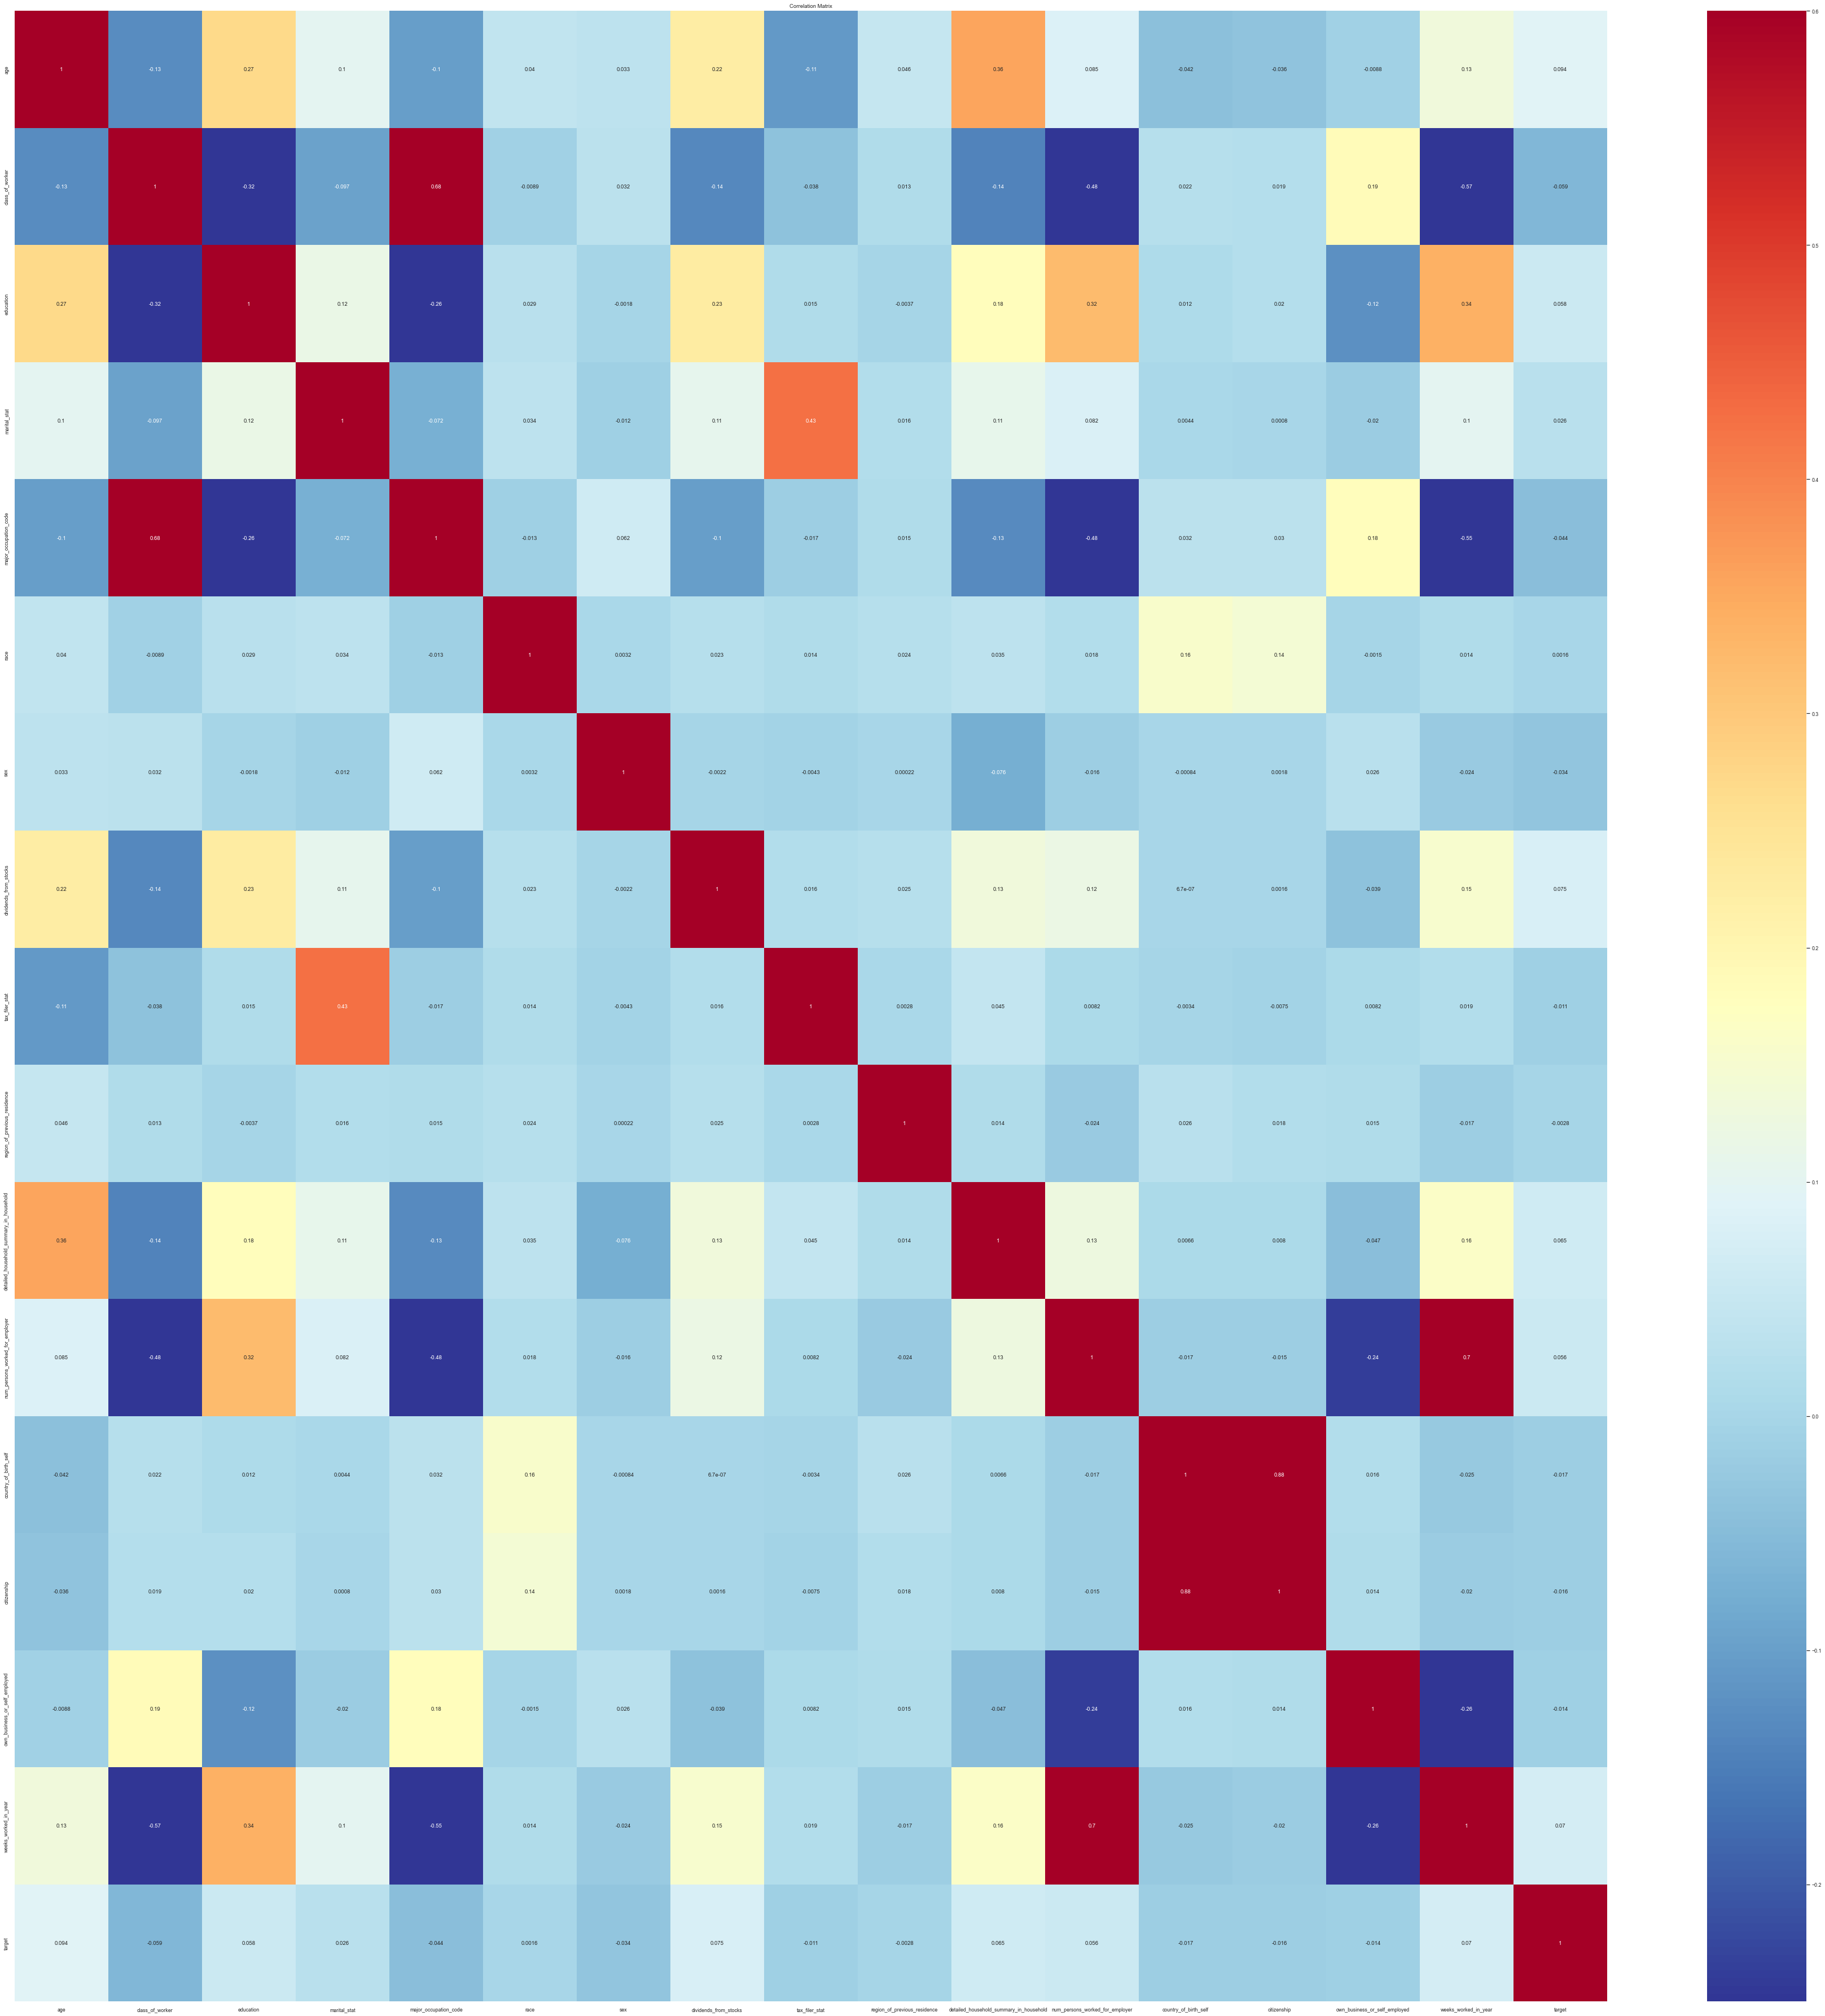

In [107]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [108]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.8:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 1
The number of features remaining: 15


In [109]:
del_features

array(['citizenship'], dtype='<U11')

In [110]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 15


In [111]:
sorted(count_features)

['age',
 'class_of_worker',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'major_occupation_code',
 'marital_stat',
 'num_persons_worked_for_employer',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

In [112]:
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic regression 

In [113]:
#X_tr, X_te, y_tr, y_te = train_test_split(synt_data[real_model_features],synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [114]:
X_tr1 = X_tr[count_features]
X_te1 = X_te[count_features]
X_te_real1 = X_te_real[count_features]

X_tr2 = X_tr[real_model_features]
X_te2 = X_te[real_model_features]
X_te_real2 = X_te_real[real_model_features]


In [115]:
X_te1.isna().sum()

age                                         0
class_of_worker                            41
education                                   0
marital_stat                               31
major_occupation_code                      55
race                                       26
sex                                        17
dividends_from_stocks                       0
tax_filer_stat                             54
region_of_previous_residence               28
detailed_household_summary_in_household    57
num_persons_worked_for_employer             0
country_of_birth_self                      39
own_business_or_self_employed               1
weeks_worked_in_year                        0
dtype: int64

In [116]:
X_te2.isna().sum()

age                                         0
education                                   0
marital_stat                               31
race                                       26
sex                                        17
dividends_from_stocks                       0
tax_filer_stat                             54
region_of_previous_residence               28
detailed_household_summary_in_household    57
country_of_birth_self                      39
citizenship                                85
own_business_or_self_employed               1
weeks_worked_in_year                        0
dtype: int64

In [117]:
X_te_real1.isna().sum()

age                                          0
class_of_worker                              0
education                                    0
marital_stat                                 0
major_occupation_code                      120
race                                         0
sex                                          0
dividends_from_stocks                        0
tax_filer_stat                               0
region_of_previous_residence                 0
detailed_household_summary_in_household      0
num_persons_worked_for_employer              0
country_of_birth_self                       96
own_business_or_self_employed                0
weeks_worked_in_year                         0
dtype: int64

In [118]:
X_te_real2.isna().sum()

age                                          0
education                                    0
marital_stat                                 0
race                                         0
sex                                          0
dividends_from_stocks                        0
tax_filer_stat                               0
region_of_previous_residence                 0
detailed_household_summary_in_household      0
country_of_birth_self                       96
citizenship                                412
own_business_or_self_employed                0
weeks_worked_in_year                         0
dtype: int64

In [119]:
sorted(synt_data['citizenship'].unique()) 


['10',
 '10th grade',
 '12th grade no diploma',
 '18 or older',
 '1st 5th or 6th grade',
 'Abroad',
 'Abroad- Born in the United States',
 'Adm support',
 'Adm support including clerical',
 'Amer Indian Aleut or Eskimo',
 'American',
 'American Columbia',
 'American Indian Aleut or Eskimo',
 'Armed Forces',
 'Armed Forces personnel of the State government',
 'Asian or Pacific Islander',
 'Asian- Pacific Islander',
 'Bachelors degree(BA AB BS)',
 'Bailed- Not a citizen of U S',
 'Bailed-not incorporated',
 'Bailed_for_employer',
 'Black',
 'Born abroad of American Parent(s)',
 'Born in Jamaica',
 'Born in the United States',
 'Canada',
 'Child 18',
 'Child 18 or older',
 'Child under 18 never married',
 'Child under Native- Born in the United States',
 'Children',
 'Columbia',
 'Divorced',
 'Doctorate degree(PhD EdD)',
 'Dominican-Republic',
 'Dominican-speaking',
 'Ecuador',
 'El-Guerilla region',
 'El-Salvador',
 'Eligible',
 'England',
 'Executive admin and managerial',
 'Federal cit

In [120]:
sorted(real_data['citizenship'].unique())

['Foreign born- Not a citizen of U S ',
 'Foreign born- U S citizen by naturalization',
 'Native- Born abroad of American Parent(s)',
 'Native- Born in Puerto Rico or U S Outlying',
 'Native- Born in the United States']

In [121]:
X_te1.fillna(0, inplace=True)
X_te_real1.fillna(0, inplace=True)
X_te2.fillna(0, inplace=True)
X_te_real2.fillna(0, inplace=True)
X_tr1.fillna(0, inplace=True)
X_tr2.fillna(0, inplace=True)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_7460\3402496439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_7460\3402496439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_7460\3402496439.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te2.fillna(0, i

In [122]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr1, y_tr)

CPU times: total: 500 ms
Wall time: 481 ms


In [123]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.578 total time=   0.4s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.601 total time=   0.4s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.598 total time=   0.4s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.593 total time=   0.3s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.597 total time=   0.4s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.580 total time=   1.0s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.597 total time=   1.2s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.599 total time=   1.0s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.599 total time=   1.0s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.606 total time=   1.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.583 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .......LR__C=0.01, LR__solver=saga;, score=0.596 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .......LR__C=0.01, LR__solver=saga;, score=0.599 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .......LR__C=0.01, LR__solver=saga;, score=0.602 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .......LR__C=0.01, LR__solver=saga;, score=0.609 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.583 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.594 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.598 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.602 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.609 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.583 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.594 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.599 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.602 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.610 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.583 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.594 total time=   2.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.599 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.602 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.610 total time=   2.1s
CPU times: total: 59.8 s
Wall time: 1min


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [124]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.597779739922052
LogisticRegression(C=0.01, solver='saga')


In [125]:
y_pred_test1 = grid_pipe_log.best_estimator_.predict(X_te1)


In [126]:
y_pred_test_real1 = grid_pipe_log.best_estimator_.predict(X_te_real1)

In [127]:
res_test11 = pd.DataFrame([['LogRegression DistillGPT synthetic features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test1),
                        recall_score(y_te, y_pred_test1),
                        precision_score(y_te, y_pred_test1),
                        roc_auc_score(y_te, y_pred_test1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real11 = pd.DataFrame([['LogRegression DistillGPT synthetic features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real1),
                        recall_score(y_te_real, y_pred_test_real1),
                        precision_score(y_te_real, y_pred_test_real1),
                        roc_auc_score(y_te_real, y_pred_test_real1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test11, res_test_real11],axis=0)

In [128]:
res_test11

Model     Dataset  Balanced_accuracy  \
0  LogRegression DistillGPT synthetic features  Synth test           0.566551   

     Recall  Precision   ROC_AUC  
0  0.592493    0.07876  0.566551

In [129]:
res_test_real11

Model    Dataset  Balanced_accuracy  \
0  LogRegression DistillGPT synthetic features  Real test           0.740727   

     Recall  Precision   ROC_AUC  
0  0.859788   0.132545  0.740727

In [130]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr2, y_tr)

CPU times: total: 312 ms
Wall time: 320 ms


In [131]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.568 total time=   0.3s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.595 total time=   0.3s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.578 total time=   0.3s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.591 total time=   0.3s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.582 total time=   0.3s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.570 total time=   1.9s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.598 total time=   1.1s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.584 total time=   1.8s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.595 total time=   1.9s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.593 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.575 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .......LR__C=0.01, LR__solver=saga;, score=0.602 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .......LR__C=0.01, LR__solver=saga;, score=0.587 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .......LR__C=0.01, LR__solver=saga;, score=0.597 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .......LR__C=0.01, LR__solver=saga;, score=0.597 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.576 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.602 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.588 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.597 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.597 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.576 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.602 total time=   3.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.588 total time=   2.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.597 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.597 total time=   3.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.576 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.602 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.587 total time=   2.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.596 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.598 total time=   2.3s
CPU times: total: 1min 2s
Wall time: 1min 4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [132]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.591872027662471
LogisticRegression(C=1, solver='saga')


In [133]:
y_pred_test2 = grid_pipe_log.best_estimator_.predict(X_te2)


In [134]:
y_pred_test_real2 = grid_pipe_log.best_estimator_.predict(X_te_real2)

In [135]:
res_test12 = pd.DataFrame([['LogRegression DistillGPT real features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test2),
                        recall_score(y_te, y_pred_test2),
                        precision_score(y_te, y_pred_test2),
                        roc_auc_score(y_te, y_pred_test2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real12 = pd.DataFrame([['LogRegression DistillGPT real features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real2),
                        recall_score(y_te_real, y_pred_test_real2),
                        precision_score(y_te_real, y_pred_test_real2),
                        roc_auc_score(y_te_real, y_pred_test_real2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
model_results = pd.concat([model_results, res_test12, res_test_real12],axis=0)

In [136]:
res_test12

Model     Dataset  Balanced_accuracy  \
0  LogRegression DistillGPT real features  Synth test           0.575157   

     Recall  Precision   ROC_AUC  
0  0.619303   0.080488  0.575157

In [137]:
res_test_real12

Model    Dataset  Balanced_accuracy  \
0  LogRegression DistillGPT real features  Real test           0.742058   

     Recall  Precision   ROC_AUC  
0  0.902116   0.126719  0.742058

## GPT2XL classification

### Data preprocessing 

In [138]:
synt_data = synt_data_gpt2xl.copy()

In [139]:
X_tr, X_te, y_tr, y_te = train_test_split(synt_data.drop(columns = ['target']),synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [140]:
X_te_real = X_te_real_validate.copy()
y_te_real = y_te_real_validate.copy()

In [141]:
print(synt_data['target'].unique(), len(synt_data['target'].unique()))

['- 50000.' '50000+.'] 2


In [142]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)
y_te_real = y_te_real.map(target_encoder) 

In [143]:
print(synt_data['education'].unique(), len(synt_data['education'].unique()))

['Children' 'Bachelors degree(BA AB BS)' '7th and 8th grade' '10th grade'
 '12th grade no diploma' 'Some college but no degree'
 'High school graduate' 'Masters degree(MA MS MEng MEd MSW MBA)'
 'Associates degree-academic program' '5th or 6th grade'
 'Associates degree-occup /vocational' '11th grade' '9th grade' '- 50000.'
 'Doctorate degree(PhD EdD)' 'Less than 1st grade'
 '1st 2nd 3rd or 4th grade' 'Prof school degree (MD DDS DVM LLB JD)' '0'
 '2' 'Other 10th grade' 'Associates degree (occup /vocational'
 'Spouse of householder' 'Married-civilian spouse present'
 '9th 10th grade' 'Householder' '- 10th grade' 'Sp 10th grade'
 'Local government' '2nd 3rd or 4th grade' 'Single'
 'Associates degree-incorporated' 'Not in universe' 'Black'
 'Masters degree(PhD U S JD)' 'Divorced' '- 7th and 8th grade' 'Sales'
 'Associates degree-inacademic program' 'the 10th grade'
 '6th or 7th grade' '3rd or 4th grade' '13th and 14th grade'
 '14th and 15th grade' '4' '17th grade' 'Professional college gra

In [144]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)
X_te_real['education'] = X_te_real['education'].map(edu_encoder)

In [145]:
to_encode_synt = to_encode.copy() 

In [146]:
# mean target encoding
for i in to_encode_synt.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    codes_ext = codes.copy()
    for t in X_te[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    for t in X_te_real[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes_ext[x])
        X_te_real[i] = X_te_real[i].map(lambda x: codes_ext[x])
        to_encode_synt.remove(i)

In [147]:
#frequency encoding 
for i in to_encode_synt.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    X_te_real[i] = X_te_real[i].map(codes)
    to_encode_synt.remove(i)

+ class_of_worker
+ marital_stat
+ major_occupation_code
+ race
+ sex
+ tax_filer_stat
+ region_of_previous_residence
+ detailed_household_summary_in_household
+ country_of_birth_self
+ citizenship
+ own_business_or_self_employed


In [148]:
print(X_tr.isna().sum())

age                                          0
class_of_worker                              0
education                                  143
marital_stat                                 0
major_occupation_code                        0
race                                         0
sex                                          0
dividends_from_stocks                        0
tax_filer_stat                               0
region_of_previous_residence                 0
detailed_household_summary_in_household      0
num_persons_worked_for_employer              0
country_of_birth_self                        0
citizenship                                  0
own_business_or_self_employed                0
weeks_worked_in_year                         0
dtype: int64


In [149]:
X_tr.fillna(0,inplace=True)

In [150]:
X_tr.dtypes

age                                        float64
class_of_worker                            float64
education                                  float64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                      float64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer            float64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                       float64
dtype: object

### Features selection 

In [151]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix

age  class_of_worker  education  \
age                                      1.000000        -0.217098   0.392989   
class_of_worker                         -0.217098         1.000000  -0.434415   
education                                0.392989        -0.434415   1.000000   
marital_stat                             0.135881        -0.138096   0.168834   
major_occupation_code                   -0.176021         0.725070  -0.311698   
race                                     0.093138        -0.039993   0.067022   
sex                                      0.013806         0.062153   0.008757   
dividends_from_stocks                    0.303111        -0.165318   0.351946   
tax_filer_stat                          -0.090502        -0.057887   0.022869   
region_of_previous_residence             0.102962        -0.006505   0.008757   
detailed_household_summary_in_household  0.435984        -0.197577   0.273202   
num_persons_worked_for_employer          0.187298        -0.539906   0.440959   
country_of_birth_self                   -0.047003         0.020862   0.009661   
citizenship                             -0.049463         0.020847   0.014342   
own_business_or_self_employed           -0.035200         0.243760  -0.205685   
weeks_worked_in_year                     0.237234        -0.647084   0.464617   
target                                   0.140794        -0.160029   0.219666   

                                         marital_stat  major_occupation_code  \
age                                          0.135881              -0.176021   
class_of_worker                             -0.138096               0.725070   
education                                    0.168834              -0.311698   
marital_stat                                 1.000000              -0.113708   
major_occupation_code                       -0.113708               1.000000   
race                                         0.058235              -0.025082   
sex                                         -0.074189               0.134968   
dividends_from_stocks                        0.142765              -0.092878   
tax_filer_stat                               0.536839              -0.037469   
region_of_previous_residence                 0.055708               0.006690   
detailed_household_summary_in_household      0.189007              -0.165499   
num_persons_worked_for_employer              0.122520              -0.529545   
country_of_birth_self                       -0.012960               0.059773   
citizenship                                 -0.013608               0.060133   
own_business_or_self_employed               -0.046498               0.233065   
weeks_worked_in_year                         0.160488              -0.624552   
target                                       0.083384              -0.104667   

                                             race       sex  \
age                                      0.093138  0.013806   
class_of_worker                         -0.039993  0.062153   
education                                0.067022  0.008757   
marital_stat                             0.058235 -0.074189   
major_occupation_code                   -0.025082  0.134968   
race                                     1.000000 -0.012113   
sex                                     -0.012113  1.000000   
dividends_from_stocks                    0.111260 -0.023812   
tax_filer_stat                           0.001216 -0.026497   
region_of_previous_residence             0.034517 -0.015062   
detailed_household_summary_in_household  0.072701 -0.079429   
num_persons_worked_for_employer          0.029927 -0.028867   
country_of_birth_self                    0.167147 -0.007090   
citizenship                              0.145307 -0.010455   
own_business_or_self_employed           -0.041433  0.019926   
weeks_worked_in_year                     0.053995 -0.080719   
target                                   0.051183 -0.110379   

           

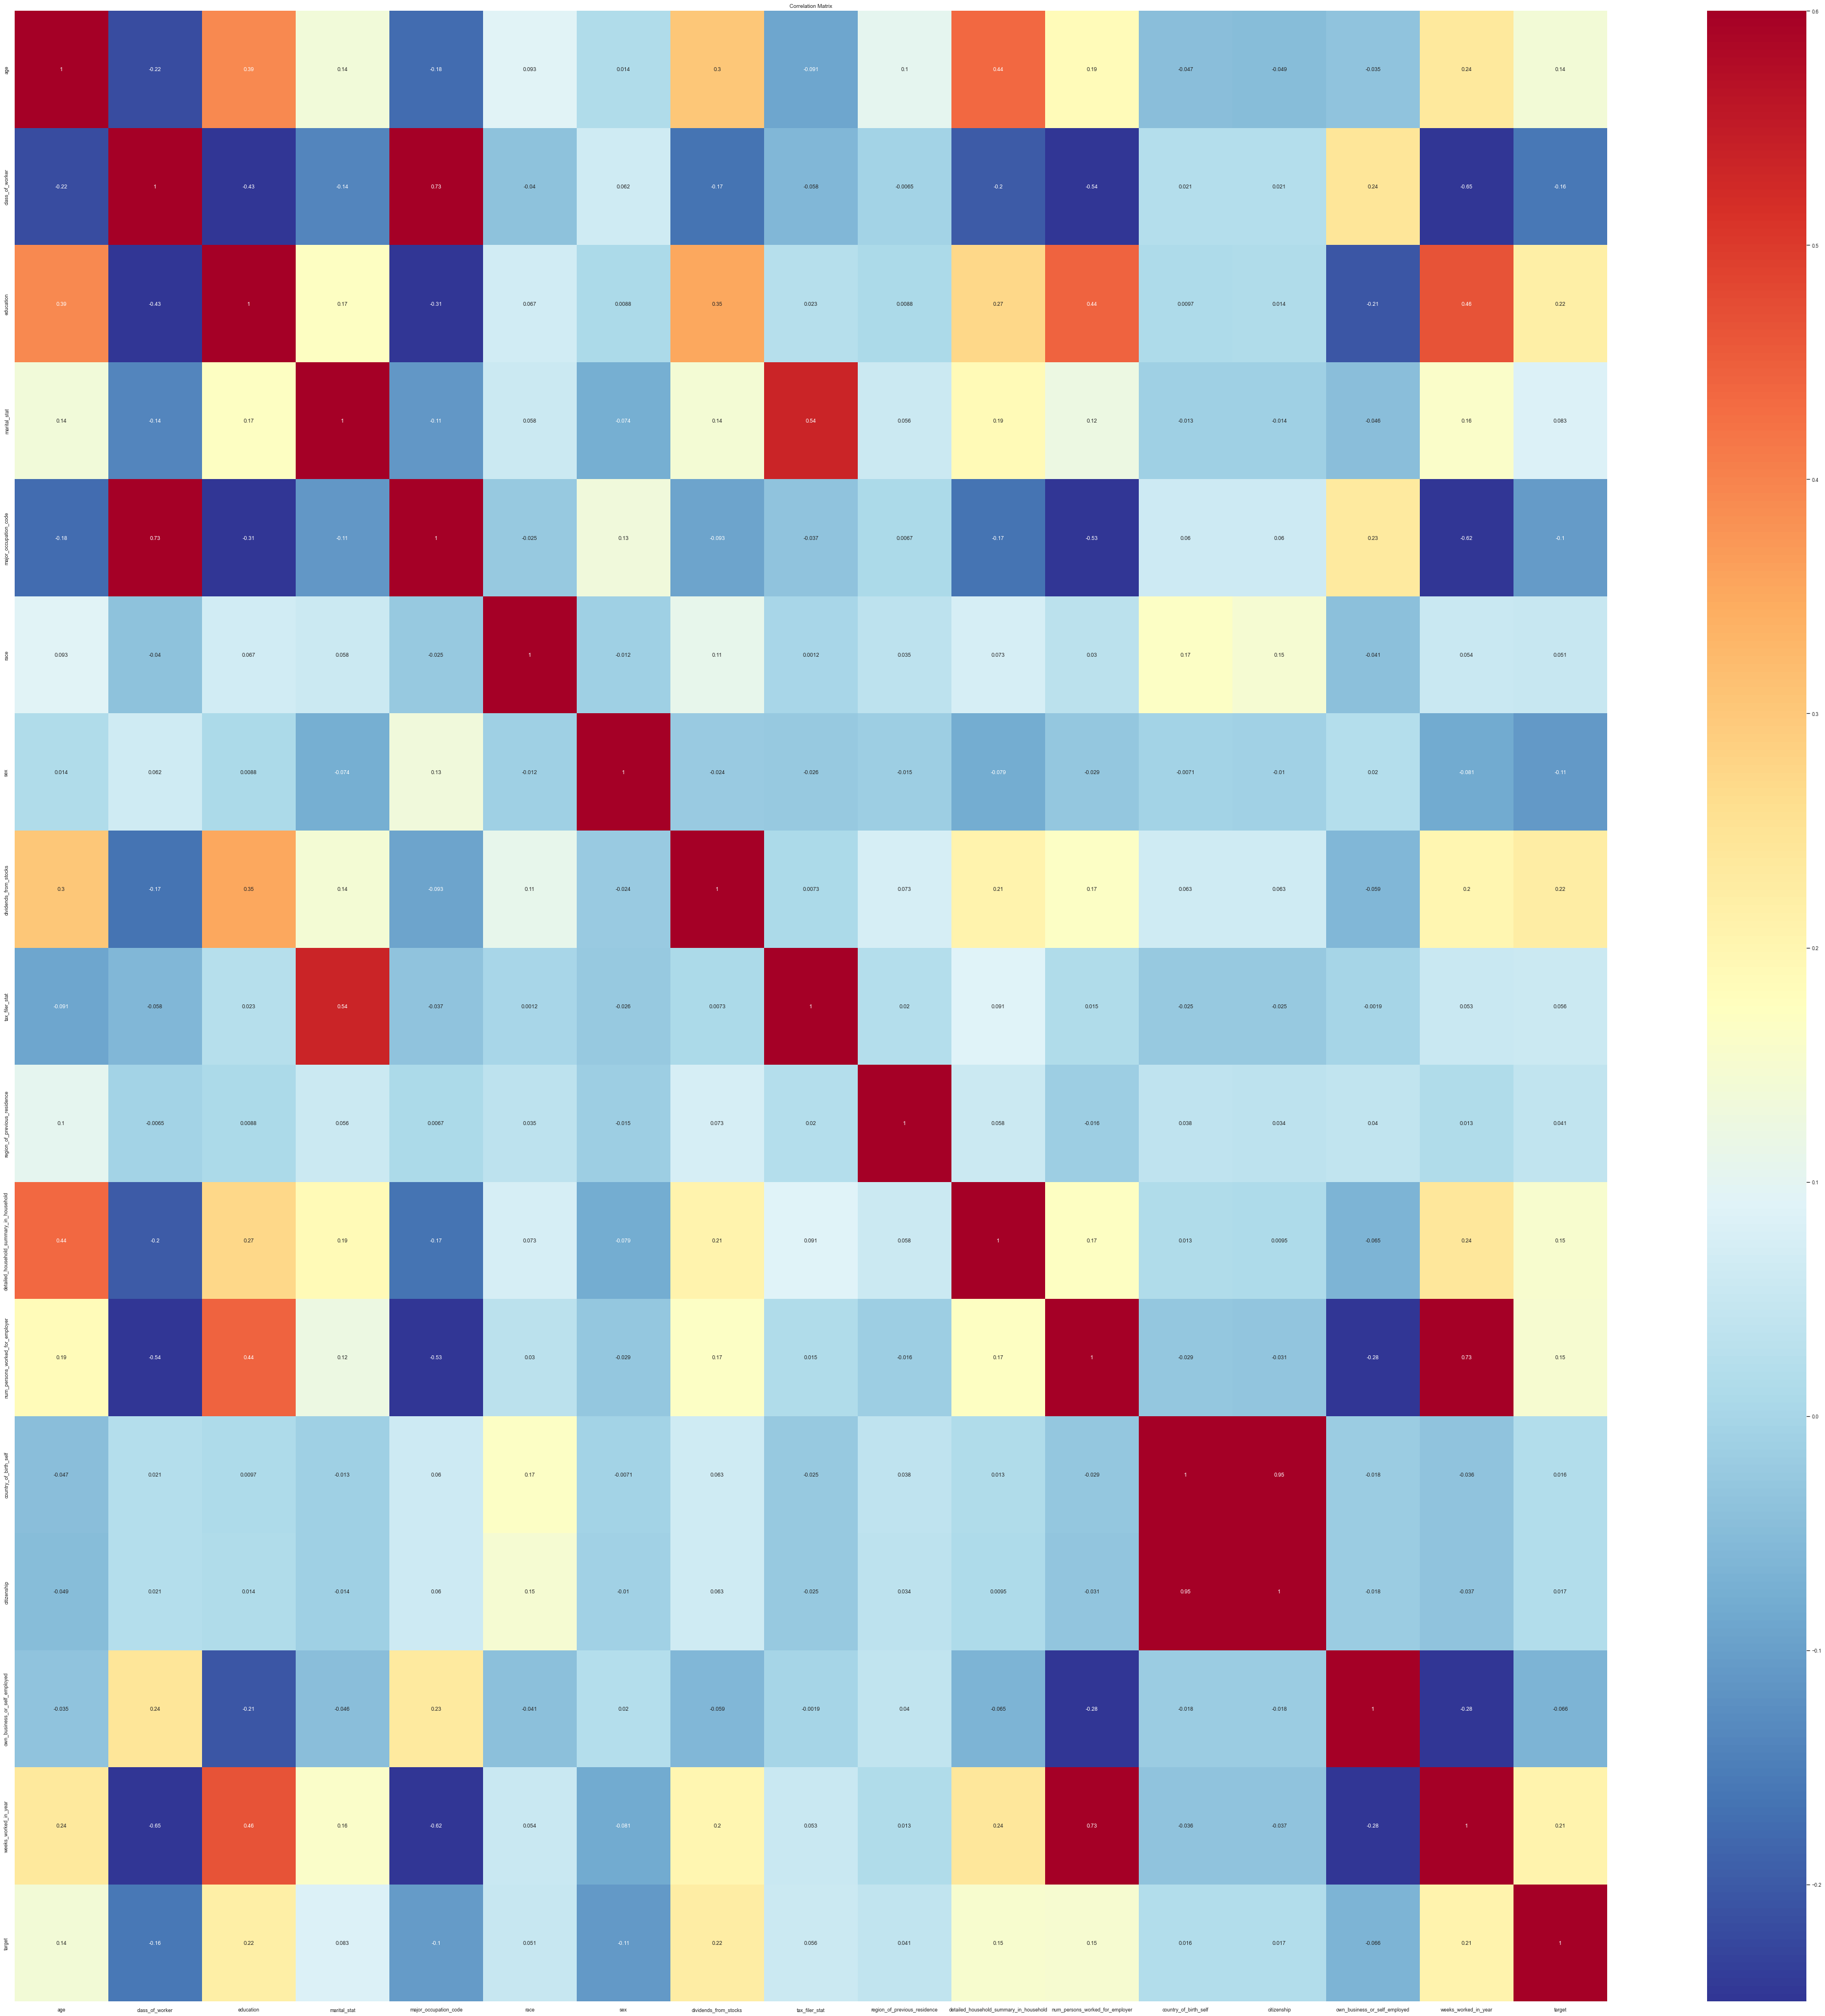

In [152]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [153]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.8:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 1
The number of features remaining: 15


In [154]:
del_features

array(['country_of_birth_self'], dtype='<U21')

In [155]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 15


In [156]:
sorted(count_features)

['age',
 'citizenship',
 'class_of_worker',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'major_occupation_code',
 'marital_stat',
 'num_persons_worked_for_employer',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

In [157]:
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic regression 

In [158]:
X_tr1 = X_tr[count_features]
X_te1 = X_te[count_features]
X_te_real1 = X_te_real[count_features]

X_tr2 = X_tr[real_model_features]
X_te2 = X_te[real_model_features]
X_te_real2 = X_te_real[real_model_features]


In [159]:
X_te2.isna().sum()

age                                         0
education                                  36
marital_stat                               26
race                                       17
sex                                         4
dividends_from_stocks                       0
tax_filer_stat                             21
region_of_previous_residence                7
detailed_household_summary_in_household    20
country_of_birth_self                      10
citizenship                                39
own_business_or_self_employed               6
weeks_worked_in_year                        0
dtype: int64

In [160]:
sorted(synt_data['country_of_birth_self'].unique()) 

['Abroad',
 'Adm support including clerical',
 'Amer Indian Aleut or Eskimo',
 'Asian or Pacific Islander',
 'B&Netherlands',
 'Bali',
 'Black',
 'Cambodia',
 'Canada',
 'China',
 'Columbia',
 'Cuba',
 'Dominican Rico or U S',
 'Dominican-Republic',
 'Ecuador',
 'El - 50000.',
 'El+ 50000.',
 'El-Rico',
 'El-Salvador',
 'England',
 'Federal government',
 'France',
 'Germany',
 'Greece',
 'Guatemala',
 'Haiti',
 'Head of household',
 'Holand-Netherlands',
 'Honduras',
 'Hong Kong',
 'Householder',
 'Hungary',
 'India',
 'Iran',
 'Ireland',
 'Italy',
 'Italy Germany',
 'Jamaica',
 'Japan',
 'Korea',
 'Laos',
 'Mexico',
 'Native- Born abroad of American Parent(s)',
 'Native- Born in the United States',
 'Nicaragua',
 'Not South Korea',
 'Not United-States',
 'Not a citizen of U S',
 'Not abroad',
 'Not in universe',
 'Not married-civilian spouse present',
 'Other',
 'Other Outlying-U S (Guam USVI etc)',
 'Other relative of householder',
 'Other-States',
 'Outlying',
 'Outlying-U S (Guam U

In [161]:
sorted(real_data['country_of_birth_self'].unique()) 

['?',
 'Cambodia',
 'Canada',
 'China',
 'Columbia',
 'Cuba',
 'Dominican-Republic',
 'Ecuador',
 'El-Salvador',
 'England',
 'France',
 'Germany',
 'Greece',
 'Guatemala',
 'Haiti',
 'Holand-Netherlands',
 'Honduras',
 'Hong Kong',
 'Hungary',
 'India',
 'Iran',
 'Ireland',
 'Italy',
 'Jamaica',
 'Japan',
 'Laos',
 'Mexico',
 'Nicaragua',
 'Outlying-U S (Guam USVI etc)',
 'Panama',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Puerto-Rico',
 'Scotland',
 'South Korea',
 'Taiwan',
 'Thailand',
 'Trinadad&Tobago',
 'United-States',
 'Vietnam',
 'Yugoslavia']

In [162]:
X_te1.fillna(0, inplace=True)
X_te_real1.fillna(0, inplace=True)
X_te2.fillna(0, inplace=True)
X_te_real2.fillna(0, inplace=True)
X_tr1.fillna(0, inplace=True)
X_tr2.fillna(0, inplace=True)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_7460\3402496439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_7460\3402496439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_7460\3402496439.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te2.fillna(0, i

In [163]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr1, y_tr)

CPU times: total: 422 ms
Wall time: 424 ms


In [164]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.737 total time=   0.3s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.755 total time=   0.3s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.758 total time=   0.2s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.752 total time=   0.3s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.751 total time=   0.2s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.747 total time=   1.3s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.758 total time=   0.9s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.773 total time=   1.2s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.766 total time=   1.3s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.757 total time=   1.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.752 total time=   2.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .......LR__C=0.01, LR__solver=saga;, score=0.764 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .......LR__C=0.01, LR__solver=saga;, score=0.774 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .......LR__C=0.01, LR__solver=saga;, score=0.769 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .......LR__C=0.01, LR__solver=saga;, score=0.760 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.753 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.766 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.775 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.769 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.761 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.753 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.766 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.774 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.769 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.761 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.753 total time=   2.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.766 total time=   2.8s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.774 total time=   2.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.769 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.761 total time=   2.5s
CPU times: total: 1min 1s
Wall time: 1min 3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [165]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.7647054343166472
LogisticRegression(C=1, solver='saga')


In [166]:
y_pred_test1 = grid_pipe_log.best_estimator_.predict(X_te1)
y_pred_test_real1 = grid_pipe_log.best_estimator_.predict(X_te_real1)

In [167]:
res_test21 = pd.DataFrame([['LogRegression GPT2xl synthetic features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test1),
                        recall_score(y_te, y_pred_test1),
                        precision_score(y_te, y_pred_test1),
                        roc_auc_score(y_te, y_pred_test1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real21 = pd.DataFrame([['LogRegression GPT2xl synthetic features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real1),
                        recall_score(y_te_real, y_pred_test_real1),
                        precision_score(y_te_real, y_pred_test_real1),
                        roc_auc_score(y_te_real, y_pred_test_real1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test21, res_test_real21],axis=0)

In [168]:
res_test21

Model     Dataset  Balanced_accuracy  \
0  LogRegression GPT2xl synthetic features  Synth test            0.73905   

     Recall  Precision  ROC_AUC  
0  0.760638   0.152533  0.73905

In [169]:
res_test_real21

Model    Dataset  Balanced_accuracy  \
0  LogRegression GPT2xl synthetic features  Real test           0.818296   

     Recall  Precision   ROC_AUC  
0  0.939153   0.172665  0.818296

In [170]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr2, y_tr)

CPU times: total: 297 ms
Wall time: 309 ms


In [171]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.744 total time=   0.2s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.750 total time=   0.2s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.764 total time=   0.2s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.759 total time=   0.2s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.740 total time=   0.2s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.756 total time=   1.0s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.755 total time=   0.8s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.777 total time=   1.0s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.773 total time=   0.9s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.752 total time=   1.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.755 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .......LR__C=0.01, LR__solver=saga;, score=0.757 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .......LR__C=0.01, LR__solver=saga;, score=0.777 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .......LR__C=0.01, LR__solver=saga;, score=0.771 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .......LR__C=0.01, LR__solver=saga;, score=0.755 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.756 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.757 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.777 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.771 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.753 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.755 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.757 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.777 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.771 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.753 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.755 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.757 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.777 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.771 total time=   2.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.753 total time=   2.2s
CPU times: total: 56 s
Wall time: 57.9 s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [172]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.7630249163508631
LogisticRegression(C=0.01, solver='saga')


In [173]:
y_pred_test2 = grid_pipe_log.best_estimator_.predict(X_te2)
y_pred_test_real2 = grid_pipe_log.best_estimator_.predict(X_te_real2)

In [174]:
res_test22 = pd.DataFrame([['LogRegression GPT2xl real features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test2),
                        recall_score(y_te, y_pred_test2),
                        precision_score(y_te, y_pred_test2),
                        roc_auc_score(y_te, y_pred_test2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real22 = pd.DataFrame([['LogRegression GPT2xl real features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real2),
                        recall_score(y_te_real, y_pred_test_real2),
                        precision_score(y_te_real, y_pred_test_real2),
                        roc_auc_score(y_te_real, y_pred_test_real2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
model_results = pd.concat([model_results, res_test22, res_test_real22],axis=0)

In [175]:
res_test22

Model     Dataset  Balanced_accuracy  \
0  LogRegression GPT2xl real features  Synth test           0.738079   

     Recall  Precision   ROC_AUC  
0  0.755319   0.153182  0.738079

In [176]:
res_test_real22

Model    Dataset  Balanced_accuracy   Recall  \
0  LogRegression GPT2xl real features  Real test           0.811414  0.94709   

   Precision   ROC_AUC  
0   0.164145  0.811414

## Cerebras classification

### Data preprocessing 

In [177]:
synt_data = synt_data_cerebras.copy()

In [178]:
X_tr, X_te, y_tr, y_te = train_test_split(synt_data.drop(columns = ['target']),synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [179]:
X_te_real = X_te_real_validate.copy()
y_te_real = y_te_real_validate.copy()

In [180]:
print(synt_data['target'].unique(), len(synt_data['target'].unique()))

['- 50000.' '50000+.'] 2


In [181]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)
y_te_real = y_te_real.map(target_encoder) 

In [182]:
print(synt_data['education'].unique(), len(synt_data['education'].unique()))

['Children' 'Some college but no degree' '11th grade'
 'High school graduate' 'Bachelors degree(BA AB BS)' '9th grade'
 'Doctorate degree(PhD EdD)' 'Associates degree-occup /vocational'
 'Prof school degree (MD DDS DVM LLB JD)' '5th or 6th grade'
 'Masters degree(MA MS MEng MEd MSW MBA)' '10th grade'
 'Less than 1st grade' 'Associates degree-academic program'
 '7th and 8th grade' '1st 2nd 3rd or 4th grade' '12th grade no diploma'
 '25 Some college but no degree' 'U S citizen by naturalization'
 'Private 9th grade' 'Federal government' '6th or 6th grade'
 '13th 12th grade no diploma' '2nd 3rd or 4th grade' '8th grade'
 '3rd or 4th grade' '50' 'Technicians and related support' '0'
 'Self-employed-incorporated' '6th grade no diploma'
 'Never Bachelors degree(BA AB BS)' 'Not in universe'
 '9th grade 8th grade' '- Children' 'Native- Born in the United States'
 'Divorced' '1st 2nd 3rd or 6th grade' 'Bachelors degree(BA AB AB BS)'
 'Professional specialty' 'Joint one under 65 & one 65+' 'Sale

In [183]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)
X_te_real['education'] = X_te_real['education'].map(edu_encoder)

In [184]:
to_encode_synt = to_encode.copy() 

In [185]:
# mean target encoding
for i in to_encode_synt.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    codes_ext = codes.copy()
    for t in X_te[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    for t in X_te_real[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes_ext[x])
        X_te_real[i] = X_te_real[i].map(lambda x: codes_ext[x])
        to_encode_synt.remove(i)

In [186]:
#frequency encoding 
for i in to_encode_synt.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    X_te_real[i] = X_te_real[i].map(codes)
    to_encode_synt.remove(i)

+ class_of_worker
+ marital_stat
+ major_occupation_code
+ race
+ sex
+ tax_filer_stat
+ region_of_previous_residence
+ detailed_household_summary_in_household
+ country_of_birth_self
+ citizenship
+ own_business_or_self_employed


In [187]:
print(X_tr.isna().sum())

age                                         0
class_of_worker                             0
education                                  79
marital_stat                                0
major_occupation_code                       0
race                                        0
sex                                         0
dividends_from_stocks                       0
tax_filer_stat                              0
region_of_previous_residence                0
detailed_household_summary_in_household     0
num_persons_worked_for_employer             0
country_of_birth_self                       0
citizenship                                 0
own_business_or_self_employed               0
weeks_worked_in_year                        0
dtype: int64


In [188]:
X_tr.dtypes

age                                        float64
class_of_worker                            float64
education                                  float64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                      float64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer            float64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                       float64
dtype: object

### Features selection 

In [189]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix

age  class_of_worker  education  \
age                                      1.000000        -0.199307   0.399793   
class_of_worker                         -0.199307         1.000000  -0.441594   
education                                0.399793        -0.441594   1.000000   
marital_stat                             0.146908        -0.147774   0.176891   
major_occupation_code                   -0.148200         0.736494  -0.306381   
race                                     0.103222        -0.059050   0.080061   
sex                                      0.022761         0.060711   0.000506   
dividends_from_stocks                    0.296770        -0.176473   0.348397   
tax_filer_stat                          -0.079447        -0.054725   0.028471   
region_of_previous_residence             0.109164        -0.005277   0.009505   
detailed_household_summary_in_household  0.446560        -0.193481   0.274461   
num_persons_worked_for_employer          0.164472        -0.538481   0.450361   
country_of_birth_self                   -0.040484         0.019953   0.006337   
citizenship                             -0.043072         0.020891   0.008863   
own_business_or_self_employed           -0.024199         0.247378  -0.193910   
weeks_worked_in_year                     0.220622        -0.652430   0.477428   
target                                   0.142483        -0.160585   0.232303   

                                         marital_stat  major_occupation_code  \
age                                          0.146908              -0.148200   
class_of_worker                             -0.147774               0.736494   
education                                    0.176891              -0.306381   
marital_stat                                 1.000000              -0.116553   
major_occupation_code                       -0.116553               1.000000   
race                                         0.069968              -0.045340   
sex                                         -0.068578               0.126848   
dividends_from_stocks                        0.145168              -0.094624   
tax_filer_stat                               0.537924              -0.034706   
region_of_previous_residence                 0.043933               0.010131   
detailed_household_summary_in_household      0.189213              -0.157553   
num_persons_worked_for_employer              0.126384              -0.526613   
country_of_birth_self                        0.001628               0.056706   
citizenship                                  0.002446               0.055548   
own_business_or_self_employed               -0.039718               0.242273   
weeks_worked_in_year                         0.157917              -0.626525   
target                                       0.097612              -0.106620   

                                             race       sex  \
age                                      0.103222  0.022761   
class_of_worker                         -0.059050  0.060711   
education                                0.080061  0.000506   
marital_stat                             0.069968 -0.068578   
major_occupation_code                   -0.045340  0.126848   
race                                     1.000000 -0.017478   
sex                                     -0.017478  1.000000   
dividends_from_stocks                    0.120321 -0.009054   
tax_filer_stat                           0.014063 -0.028929   
region_of_previous_residence             0.050073 -0.011831   
detailed_household_summary_in_household  0.098561 -0.081656   
num_persons_worked_for_employer          0.023840 -0.036808   
country_of_birth_self                    0.184602 -0.011968   
citizenship                              0.167192 -0.013295   
own_business_or_self_employed           -0.039678  0.023147   
weeks_worked_in_year                     0.060514 -0.079606   
target                                   0.052249 -0.116620   

           

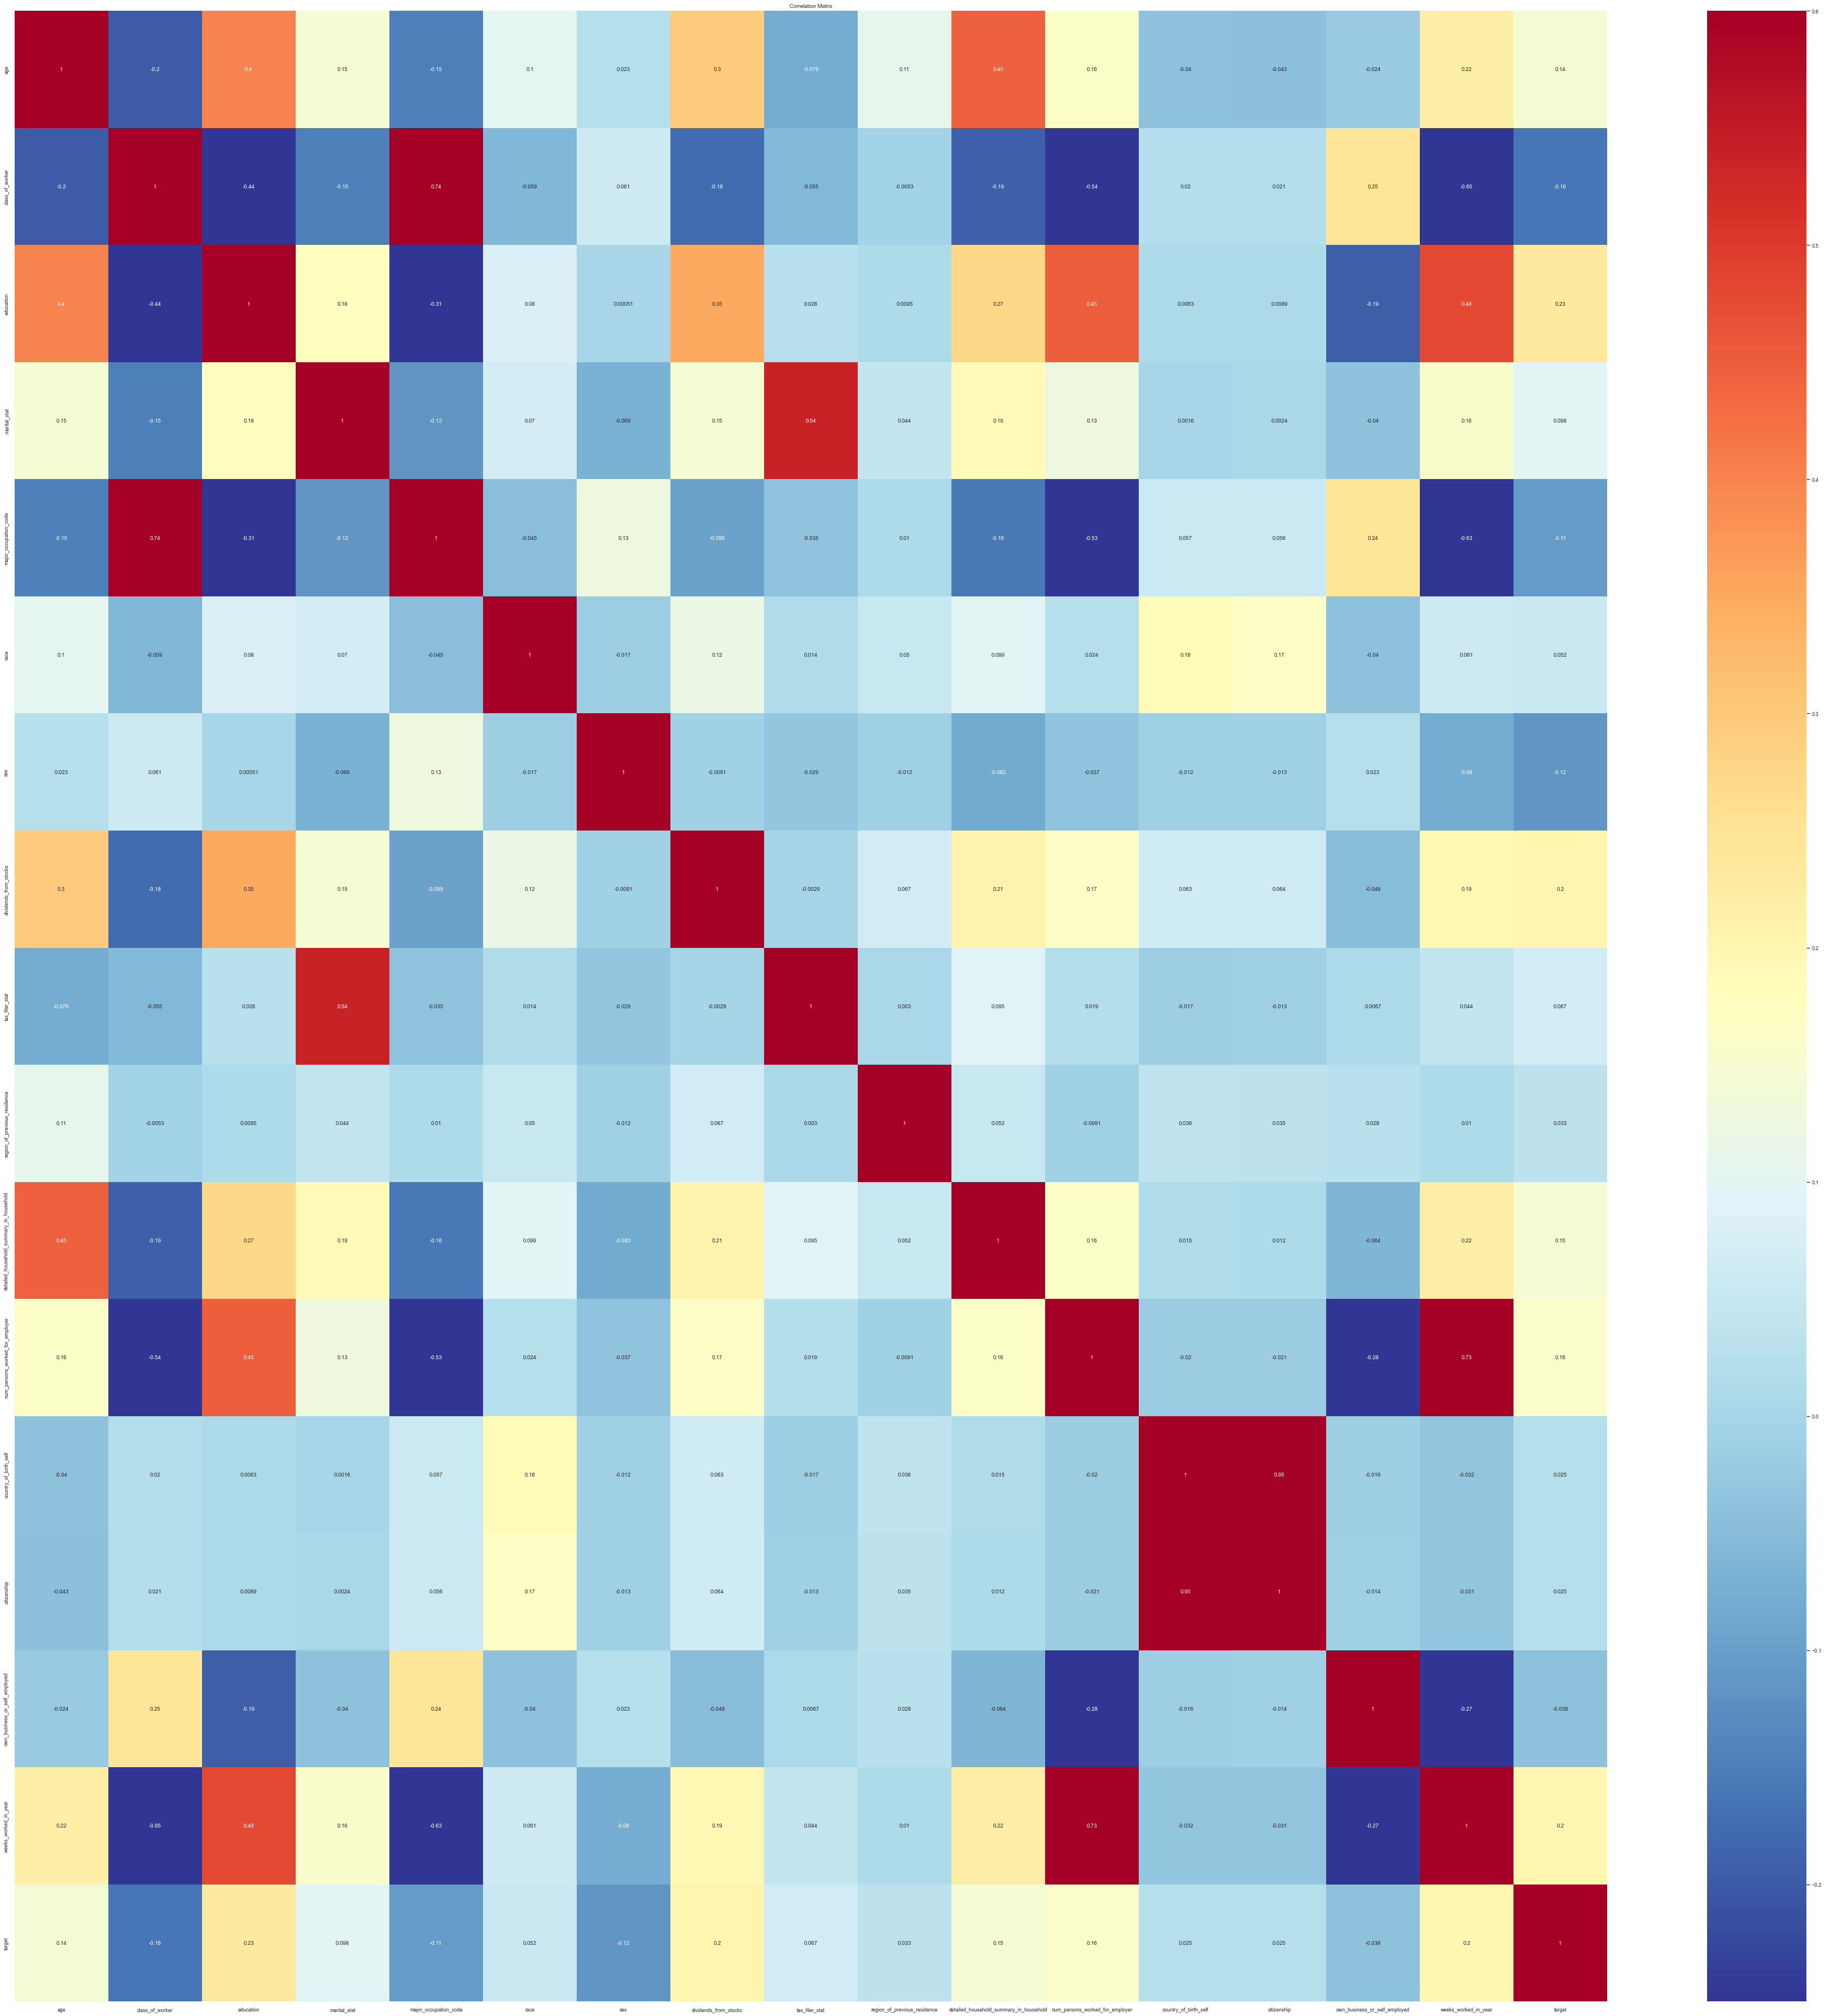

In [190]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [191]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.8:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 1
The number of features remaining: 15


In [192]:
del_features

array(['country_of_birth_self'], dtype='<U21')

In [193]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 15


In [194]:
sorted(count_features)

['age',
 'citizenship',
 'class_of_worker',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'major_occupation_code',
 'marital_stat',
 'num_persons_worked_for_employer',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

In [195]:
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic regression 

In [196]:
X_tr1 = X_tr[count_features]
X_te1 = X_te[count_features]
X_te_real1 = X_te_real[count_features]

X_tr2 = X_tr[real_model_features]
X_te2 = X_te[real_model_features]
X_te_real2 = X_te_real[real_model_features]


In [197]:
X_te_real2.isna().sum()

age                                          0
education                                    0
marital_stat                                 0
race                                         0
sex                                          0
dividends_from_stocks                        0
tax_filer_stat                               0
region_of_previous_residence                 0
detailed_household_summary_in_household      0
country_of_birth_self                       93
citizenship                                412
own_business_or_self_employed                0
weeks_worked_in_year                         0
dtype: int64

In [198]:
sorted(synt_data['citizenship'].unique()) 

['0',
 '16 born in the United States',
 '1st 2nd 3rd or 4th grade',
 '7th and 8th grade',
 'Adm support including clerical',
 'Asian or Pacific Islander',
 'Associates degree-occup /vocational',
 'Bachelors degree(BA AB BS)',
 'Black',
 'Born in the United States',
 'Canada',
 'Child under 18 never married',
 'Children',
 'Cuba',
 'Divorced',
 'Dominican- Born abroad of American Parent(s)',
 'Dominican-Republic',
 'El-Salvador',
 'Federal government',
 'Foreign born in the United States',
 'Foreign born- Abroad',
 'Foreign born- Abroad of American Parent(s)',
 'Foreign born- Adm support including clerical',
 'Foreign born- Amer Indian Aleut or Eskimo',
 'Foreign born- Bachelors degree(BA AB BS)',
 'Foreign born- Children',
 'Foreign born- Divorced',
 'Foreign born- Federal government',
 'Foreign born- Federal officer by naturalization',
 'Foreign born- Foreign born- Not a citizen of U S',
 'Foreign born- Foreign born- U S citizen by naturalization',
 'Foreign born- Handlers equip clean

In [199]:
sorted(real_data['citizenship'].unique()) 

['Foreign born- Not a citizen of U S ',
 'Foreign born- U S citizen by naturalization',
 'Native- Born abroad of American Parent(s)',
 'Native- Born in Puerto Rico or U S Outlying',
 'Native- Born in the United States']

In [200]:
X_te1.fillna(0, inplace=True)
X_te_real1.fillna(0, inplace=True)
X_te2.fillna(0, inplace=True)
X_te_real2.fillna(0, inplace=True)
X_tr1.fillna(0, inplace=True)
X_tr2.fillna(0, inplace=True)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_7460\3402496439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_7460\3402496439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_7460\3402496439.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te2.fillna(0, i

In [201]:
len(X_tr1.columns)

15

In [202]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr1, y_tr)

CPU times: total: 359 ms
Wall time: 359 ms


In [203]:
len(X_smt.columns)

15

In [204]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.752 total time=   0.2s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.741 total time=   0.2s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.757 total time=   0.2s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.740 total time=   0.2s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.760 total time=   0.3s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.758 total time=   0.8s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.754 total time=   1.8s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.768 total time=   1.7s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.747 total time=   1.7s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.768 total time=   1.5s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.765 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .......LR__C=0.01, LR__solver=saga;, score=0.750 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .......LR__C=0.01, LR__solver=saga;, score=0.765 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .......LR__C=0.01, LR__solver=saga;, score=0.752 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .......LR__C=0.01, LR__solver=saga;, score=0.769 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.764 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.747 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.762 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.753 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.771 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.764 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.748 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.761 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.753 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.771 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.764 total time=   2.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.748 total time=   2.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.761 total time=   2.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.753 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.771 total time=   2.4s
CPU times: total: 59.1 s
Wall time: 1min 1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [205]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.7603539258334614
LogisticRegression(C=0.01, solver='saga')


In [206]:
y_pred_test1 = grid_pipe_log.best_estimator_.predict(X_te1)
y_pred_test_real1 = grid_pipe_log.best_estimator_.predict(X_te_real1)

In [207]:
res_test31 = pd.DataFrame([['LogRegression Cerebras synthetic features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test1),
                        recall_score(y_te, y_pred_test1),
                        precision_score(y_te, y_pred_test1),
                        roc_auc_score(y_te, y_pred_test1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real31 = pd.DataFrame([['LogRegression Cerebras synthetic features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real1),
                        recall_score(y_te_real, y_pred_test_real1),
                        precision_score(y_te_real, y_pred_test_real1),
                        roc_auc_score(y_te_real, y_pred_test_real1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test31, res_test_real31],axis=0)

In [208]:
res_test31

Model     Dataset  Balanced_accuracy  \
0  LogRegression Cerebras synthetic features  Synth test           0.756237   

     Recall  Precision   ROC_AUC  
0  0.796915   0.162644  0.756237

In [209]:
res_test_real31

Model    Dataset  Balanced_accuracy  \
0  LogRegression Cerebras synthetic features  Real test           0.814449   

     Recall  Precision   ROC_AUC  
0  0.944444   0.167527  0.814449

In [210]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr2, y_tr)

CPU times: total: 344 ms
Wall time: 333 ms


In [211]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.748 total time=   0.2s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.741 total time=   0.2s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.758 total time=   0.2s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.742 total time=   0.1s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.749 total time=   0.2s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.759 total time=   0.7s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.753 total time=   0.8s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.766 total time=   0.8s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.756 total time=   0.8s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.762 total time=   0.6s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.759 total time=   1.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .......LR__C=0.01, LR__solver=saga;, score=0.747 total time=   2.3s
[CV 3/5] END .......LR__C=0.01, LR__solver=saga;, score=0.768 total time=   1.6s
[CV 4/5] END .......LR__C=0.01, LR__solver=saga;, score=0.760 total time=   1.5s
[CV 5/5] END .......LR__C=0.01, LR__solver=saga;, score=0.761 total time=   1.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.758 total time=   1.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.743 total time=   1.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.763 total time=   2.2s
[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.757 total time=   1.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.761 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.758 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.743 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.762 total time=   2.3s
[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.756 total time=   1.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.761 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.758 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.743 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.762 total time=   2.0s
[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.756 total time=   1.8s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.761 total time=   1.9s
CPU times: total: 45 s
Wall time: 47 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [212]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.7592502607008511
LogisticRegression(C=0.001, solver='saga')


In [213]:
y_pred_test2 = grid_pipe_log.best_estimator_.predict(X_te2)
y_pred_test_real2 = grid_pipe_log.best_estimator_.predict(X_te_real2)

In [214]:
res_test32 = pd.DataFrame([['LogRegression Cerebras real features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test2),
                        recall_score(y_te, y_pred_test2),
                        precision_score(y_te, y_pred_test2),
                        roc_auc_score(y_te, y_pred_test2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real32 = pd.DataFrame([['LogRegression Cerebras real features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real2),
                        recall_score(y_te_real, y_pred_test_real2),
                        precision_score(y_te_real, y_pred_test_real2),
                        roc_auc_score(y_te_real, y_pred_test_real2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
model_results = pd.concat([model_results, res_test32, res_test_real32],axis=0)

In [215]:
res_test32

Model     Dataset  Balanced_accuracy  \
0  LogRegression Cerebras real features  Synth test           0.756083   

     Recall  Precision   ROC_AUC  
0  0.804627   0.160184  0.756083

In [216]:
res_test_real32

Model    Dataset  Balanced_accuracy  \
0  LogRegression Cerebras real features  Real test           0.808924   

    Recall  Precision   ROC_AUC  
0  0.94709   0.162064  0.808924

## Phi1.5 classification

### Data preprocessing 

In [217]:
synt_data = synt_data_phi.copy()

In [218]:
X_tr, X_te, y_tr, y_te = train_test_split(synt_data.drop(columns = ['target']),synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [219]:
X_te_real = X_te_real_validate.copy()
y_te_real = y_te_real_validate.copy()

In [220]:
print(synt_data['target'].unique(), len(synt_data['target'].unique()))

['- 50000.' '50000+.'] 2


In [221]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)
y_te_real = y_te_real.map(target_encoder) 

In [222]:
print(synt_data['education'].unique(), len(synt_data['education'].unique()))

['Some college but no degree' 'High school graduate' '9th grade'
 '7th and 8th grade' 'Children' 'Less than 1st grade'
 'Masters degree(MA MS MEng MEd MSW MBA)'
 'Associates degree-academic program' '1st 2nd 3rd or 4th grade'
 'Associates degree-occup /vocational' '5th or 6th grade' '10th grade'
 '12th grade no diploma' '11th grade' 'Doctorate degree(PhD EdD)'
 'Bachelors degree(BA AB BS)' 'Prof school degree (MD DDS DVM LLB JD)'
 '8th grade' 'Child 18 or older' '14th grade' 'Private'
 '2nd 3rd or 4th grade' '3rd or 4th grade' '4th or 5th grade'
 'Associates degree- Associates degree-occup /vocational'
 'Associates degree-not in universe' '13th grade' '4th or 6th grade'
 '6th grade' 'Not in universe'
 'Associates degree- Doctorate degree(PhD EdD)'
 'Nonrelative of householder' '19th grade'
 'Associates degree-incorporated' 'Child under 18 never married'
 'Divorced' '0' 'Children 18 or older' 'Head of household'
 'Associates degree-civilian spouse present'
 'Professional degree(PhD EdD)

In [223]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)
X_te_real['education'] = X_te_real['education'].map(edu_encoder)

In [224]:
to_encode_synt = to_encode.copy() 

In [225]:
# mean target encoding
for i in to_encode_synt.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    codes_ext = codes.copy()
    for t in X_te[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    for t in X_te_real[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes_ext[x])
        X_te_real[i] = X_te_real[i].map(lambda x: codes_ext[x])
        to_encode_synt.remove(i)

In [226]:
#frequency encoding 
for i in to_encode_synt.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    X_te_real[i] = X_te_real[i].map(codes)
    to_encode_synt.remove(i)

+ class_of_worker
+ marital_stat
+ major_occupation_code
+ race
+ sex
+ tax_filer_stat
+ region_of_previous_residence
+ detailed_household_summary_in_household
+ country_of_birth_self
+ citizenship
+ own_business_or_self_employed


In [227]:
print(X_tr.isna().sum())

age                                         0
class_of_worker                             0
education                                  38
marital_stat                                0
major_occupation_code                       0
race                                        0
sex                                         0
dividends_from_stocks                       0
tax_filer_stat                              0
region_of_previous_residence                0
detailed_household_summary_in_household     0
num_persons_worked_for_employer             0
country_of_birth_self                       0
citizenship                                 0
own_business_or_self_employed               0
weeks_worked_in_year                        0
dtype: int64


In [228]:
#X_tr.fillna(0,inplace=True)

In [229]:
X_tr.dtypes

age                                        float64
class_of_worker                            float64
education                                  float64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                      float64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer            float64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                       float64
dtype: object

### Features selection 

In [230]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix

age  class_of_worker  education  \
age                                      1.000000        -0.214188   0.397312   
class_of_worker                         -0.214188         1.000000  -0.450476   
education                                0.397312        -0.450476   1.000000   
marital_stat                            -0.614773         0.214207  -0.310358   
major_occupation_code                   -0.160232         0.735205  -0.310738   
race                                     0.093766        -0.042136   0.065363   
sex                                      0.000255         0.068679  -0.006792   
dividends_from_stocks                    0.295919        -0.176869   0.357214   
tax_filer_stat                          -0.084486        -0.051430   0.024972   
region_of_previous_residence             0.120722         0.012602   0.007203   
detailed_household_summary_in_household  0.428019        -0.189965   0.271819   
num_persons_worked_for_employer          0.168633        -0.551021   0.439805   
country_of_birth_self                   -0.056821         0.022476   0.008601   
citizenship                             -0.060106         0.021539   0.014089   
own_business_or_self_employed           -0.025888         0.249429  -0.200333   
weeks_worked_in_year                     0.228867        -0.654837   0.465049   
target                                   0.139565        -0.120809   0.201200   

                                         marital_stat  major_occupation_code  \
age                                         -0.614773              -0.160232   
class_of_worker                              0.214207               0.735205   
education                                   -0.310358              -0.310738   
marital_stat                                 1.000000               0.181115   
major_occupation_code                        0.181115               1.000000   
race                                        -0.058323              -0.047413   
sex                                         -0.077426               0.140851   
dividends_from_stocks                       -0.174297              -0.087464   
tax_filer_stat                              -0.023768              -0.031548   
region_of_previous_residence                -0.037151               0.024503   
detailed_household_summary_in_household     -0.364092              -0.156701   
num_persons_worked_for_employer             -0.192924              -0.542014   
country_of_birth_self                        0.064682               0.060315   
citizenship                                  0.068011               0.054270   
own_business_or_self_employed                0.063231               0.234957   
weeks_worked_in_year                        -0.242862              -0.634314   
target                                      -0.079122              -0.078943   

                                             race       sex  \
age                                      0.093766  0.000255   
class_of_worker                         -0.042136  0.068679   
education                                0.065363 -0.006792   
marital_stat                            -0.058323 -0.077426   
major_occupation_code                   -0.047413  0.140851   
race                                     1.000000 -0.021849   
sex                                     -0.021849  1.000000   
dividends_from_stocks                    0.110997 -0.029318   
tax_filer_stat                           0.016474 -0.035399   
region_of_previous_residence             0.047596 -0.004376   
detailed_household_summary_in_household  0.089881 -0.082236   
num_persons_worked_for_employer          0.018116 -0.043139   
country_of_birth_self                    0.174231 -0.005845   
citizenship                              0.150797 -0.008057   
own_business_or_self_employed           -0.035966  0.022985   
weeks_worked_in_year                     0.056661 -0.093333   
target                                   0.037947 -0.108289   

           

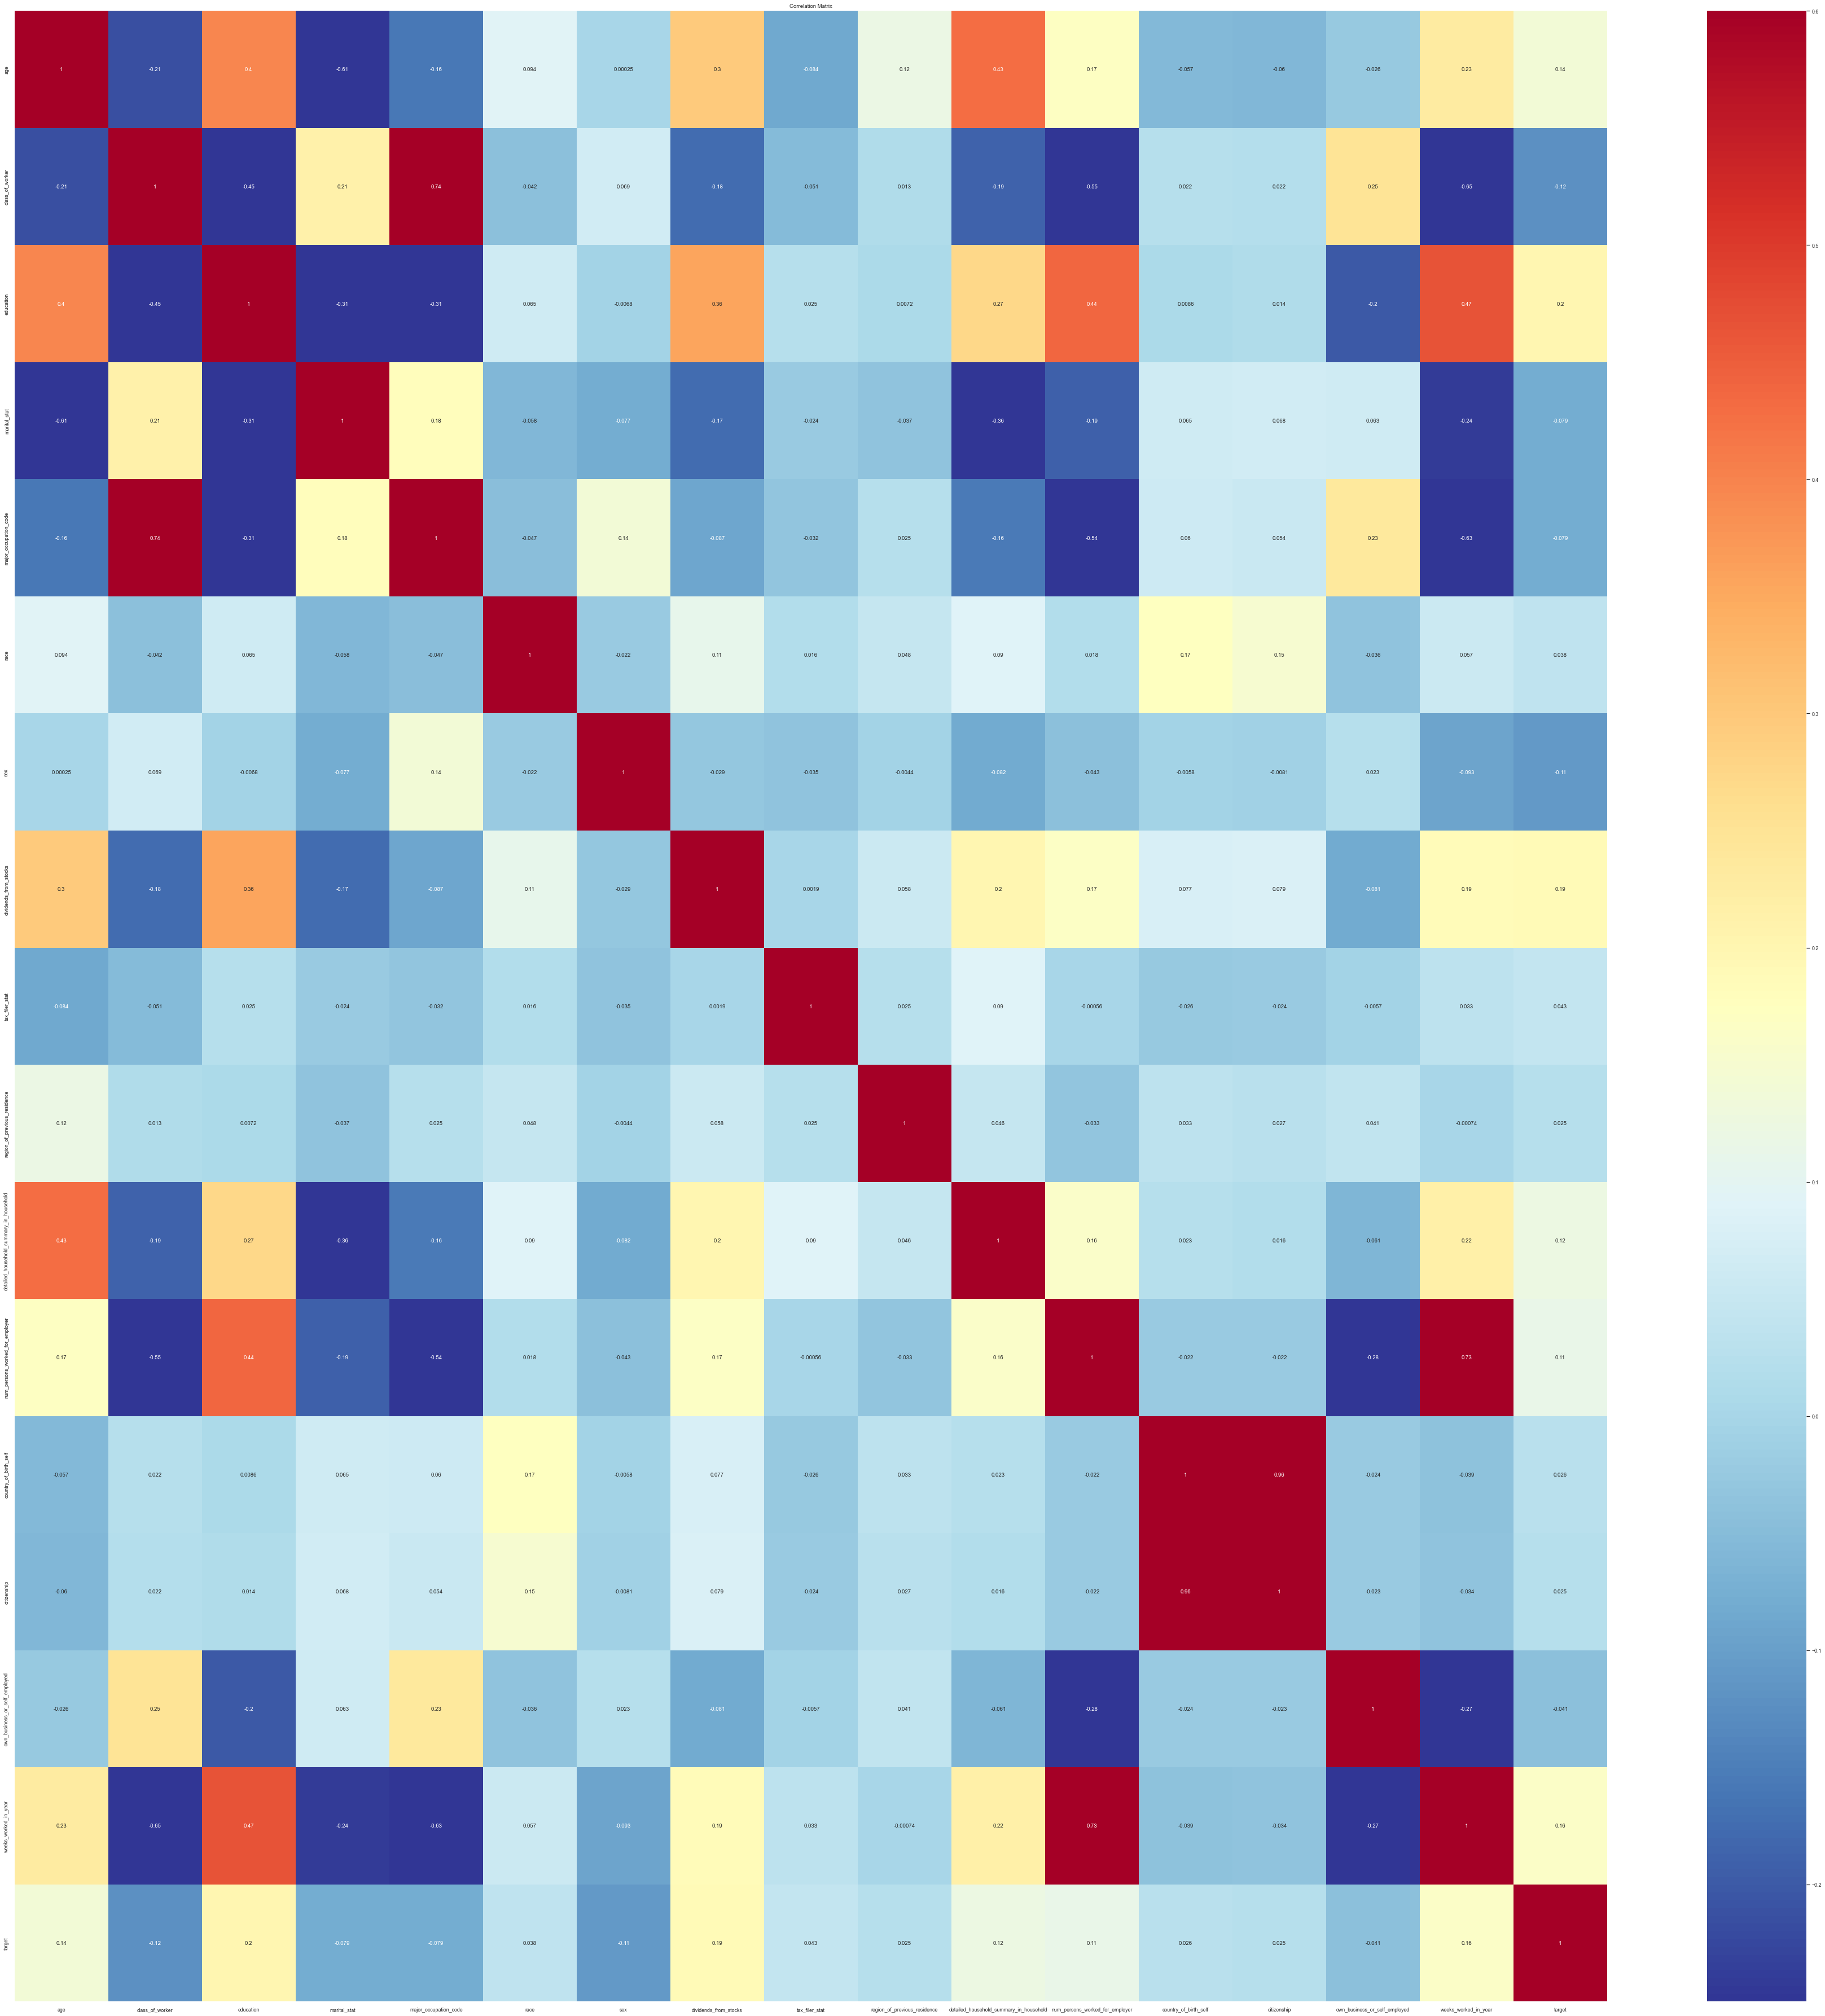

In [231]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [232]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.8:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 1
The number of features remaining: 15


In [233]:
del_features

array(['citizenship'], dtype='<U11')

In [234]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 15


In [235]:
sorted(count_features)

['age',
 'class_of_worker',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'major_occupation_code',
 'marital_stat',
 'num_persons_worked_for_employer',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

In [236]:
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic regression 

In [237]:
X_tr1 = X_tr[count_features]
X_te1 = X_te[count_features]
X_te_real1 = X_te_real[count_features]

X_tr2 = X_tr[real_model_features]
X_te2 = X_te[real_model_features]
X_te_real2 = X_te_real[real_model_features]


In [238]:
X_te2.isna().sum()

age                                         0
education                                  10
marital_stat                               10
race                                        4
sex                                         8
dividends_from_stocks                       0
tax_filer_stat                             13
region_of_previous_residence                8
detailed_household_summary_in_household    18
country_of_birth_self                      12
citizenship                                21
own_business_or_self_employed               3
weeks_worked_in_year                        0
dtype: int64

In [239]:
sorted(synt_data['country_of_birth_self'].unique()) 

['- 50000.',
 '0',
 'Abroad',
 'Asian or Pacific Islander',
 'Bachelors degree(BA AB BS)',
 'Cambodia',
 'Canada',
 'Child under 18 never married',
 'China',
 'China in universe',
 'Columbia',
 'Cuba',
 'Cuba)',
 'Dominican-Republic',
 'Dominican_Republic',
 'Ecuador',
 'El-Rico',
 'El-Salvador',
 'El-Salvador country_of_birth_self is?',
 'England',
 'Executive admin and managerial',
 'Foreign born- Not a citizen of U S',
 'France',
 'Germany',
 'Germany Germany',
 'Germany Japan Columbia',
 'Germany education',
 'Greece',
 'Guatemala',
 'Haiti',
 'Haitiadad&Tobago',
 'Holand-Netherlands',
 'Honduras',
 'Hong Kong',
 'Hungary',
 'India',
 'India Kong',
 'Iran',
 'Ireland',
 'Irelandobago',
 'Italy',
 'Jamaica',
 'Japan',
 'Japan Hong Kong',
 'Laos',
 'Mexico',
 'Midwest Korea',
 'Native- Born in the United States',
 'Nicaragua',
 'Northeast Korea',
 'Northeast Philippines',
 'Northeastadad&Tobago',
 'Not a citizen of U S',
 'Not in universe',
 'Outlying-U S ( Puerto-Rico)',
 'Outlying-

In [240]:
sorted(real_data['country_of_birth_self'].unique()) 

['?',
 'Cambodia',
 'Canada',
 'China',
 'Columbia',
 'Cuba',
 'Dominican-Republic',
 'Ecuador',
 'El-Salvador',
 'England',
 'France',
 'Germany',
 'Greece',
 'Guatemala',
 'Haiti',
 'Holand-Netherlands',
 'Honduras',
 'Hong Kong',
 'Hungary',
 'India',
 'Iran',
 'Ireland',
 'Italy',
 'Jamaica',
 'Japan',
 'Laos',
 'Mexico',
 'Nicaragua',
 'Outlying-U S (Guam USVI etc)',
 'Panama',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Puerto-Rico',
 'Scotland',
 'South Korea',
 'Taiwan',
 'Thailand',
 'Trinadad&Tobago',
 'United-States',
 'Vietnam',
 'Yugoslavia']

In [241]:
X_te1.fillna(0, inplace=True)
X_te_real1.fillna(0, inplace=True)
X_te2.fillna(0, inplace=True)
X_te_real2.fillna(0, inplace=True)
X_tr1.fillna(0, inplace=True)
X_tr2.fillna(0, inplace=True)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_7460\3402496439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_7460\3402496439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_7460\3402496439.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te2.fillna(0, i

In [242]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr1, y_tr)

CPU times: total: 312 ms
Wall time: 379 ms


In [243]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.715 total time=   0.2s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.708 total time=   0.2s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.702 total time=   0.2s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.705 total time=   0.2s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.730 total time=   0.2s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.719 total time=   0.4s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.718 total time=   0.4s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.706 total time=   0.3s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.720 total time=   0.3s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.742 total time=   0.4s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.719 total time=   0.5s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [244]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.7223353315498029
LogisticRegression(C=0.1, solver='saga')


In [245]:
y_pred_test1 = grid_pipe_log.best_estimator_.predict(X_te1)
y_pred_test_real1 = grid_pipe_log.best_estimator_.predict(X_te_real1)

In [246]:
res_test41 = pd.DataFrame([['LogRegression Phi1.5 synthetic features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test1),
                        recall_score(y_te, y_pred_test1),
                        precision_score(y_te, y_pred_test1),
                        roc_auc_score(y_te, y_pred_test1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real41 = pd.DataFrame([['LogRegression Phi1.5 synthetic features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real1),
                        recall_score(y_te_real, y_pred_test_real1),
                        precision_score(y_te_real, y_pred_test_real1),
                        roc_auc_score(y_te_real, y_pred_test_real1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test41, res_test_real41],axis=0)

In [247]:
res_test41

Model     Dataset  Balanced_accuracy  \
0  LogRegression Phi1.5 synthetic features  Synth test           0.718583   

     Recall  Precision   ROC_AUC  
0  0.763021   0.138012  0.718583

In [248]:
res_test_real41

Model    Dataset  Balanced_accuracy  \
0  LogRegression Phi1.5 synthetic features  Real test           0.811958   

     Recall  Precision   ROC_AUC  
0  0.965608   0.159668  0.811958

In [249]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr2, y_tr)

CPU times: total: 281 ms
Wall time: 299 ms


In [250]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.719 total time=   0.2s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.720 total time=   0.2s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.705 total time=   0.2s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.712 total time=   0.1s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.734 total time=   0.2s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.722 total time=   0.6s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.723 total time=   0.6s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.707 total time=   0.5s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.720 total time=   0.6s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.743 total time=   0.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.724 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .......LR__C=0.01, LR__solver=saga;, score=0.721 total time=   1.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .......LR__C=0.01, LR__solver=saga;, score=0.705 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .......LR__C=0.01, LR__solver=saga;, score=0.723 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .......LR__C=0.01, LR__solver=saga;, score=0.744 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.724 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.719 total time=   1.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.705 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.723 total time=   2.8s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.743 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.724 total time=   1.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.719 total time=   1.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.705 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.723 total time=   1.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.743 total time=   1.8s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.724 total time=   1.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.719 total time=   1.8s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.705 total time=   1.8s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.723 total time=   1.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.743 total time=   1.7s
CPU times: total: 47.8 s
Wall time: 49.8 s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [251]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.7235974774595386
LogisticRegression(C=0.01, solver='saga')


In [252]:
y_pred_test2 = grid_pipe_log.best_estimator_.predict(X_te2)
y_pred_test_real2 = grid_pipe_log.best_estimator_.predict(X_te_real2)

In [253]:
res_test42 = pd.DataFrame([['LogRegression Phi1.5 real features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test2),
                        recall_score(y_te, y_pred_test2),
                        precision_score(y_te, y_pred_test2),
                        roc_auc_score(y_te, y_pred_test2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real42 = pd.DataFrame([['LogRegression Phi1.5 real features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real2),
                        recall_score(y_te_real, y_pred_test_real2),
                        precision_score(y_te_real, y_pred_test_real2),
                        roc_auc_score(y_te_real, y_pred_test_real2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
model_results = pd.concat([model_results, res_test42, res_test_real42],axis=0)

In [254]:
res_test42

Model     Dataset  Balanced_accuracy  \
0  LogRegression Phi1.5 real features  Synth test           0.720186   

     Recall  Precision   ROC_AUC  
0  0.763021   0.139192  0.720186

In [255]:
res_test_real42

Model    Dataset  Balanced_accuracy    Recall  \
0  LogRegression Phi1.5 real features  Real test           0.807711  0.960317   

   Precision   ROC_AUC  
0   0.157689  0.807711

## Modelling result

In [256]:
model_results

Model     Dataset  Balanced_accuracy  \
0                      LogRegression Real data   Real test           0.845280   
0  LogRegression DistillGPT synthetic features  Synth test           0.566551   
0  LogRegression DistillGPT synthetic features   Real test           0.740727   
0       LogRegression DistillGPT real features  Synth test           0.575157   
0       LogRegression DistillGPT real features   Real test           0.742058   
0      LogRegression GPT2xl synthetic features  Synth test           0.739050   
0      LogRegression GPT2xl synthetic features   Real test           0.818296   
0           LogRegression GPT2xl real features  Synth test           0.738079   
0           LogRegression GPT2xl real features   Real test           0.811414   
0    LogRegression Cerebras synthetic features  Synth test           0.756237   
0    LogRegression Cerebras synthetic features   Real test           0.814449   
0         LogRegression Cerebras real features  Synth test           0.756083   
0         LogRegression Cerebras real features   Real test           0.808924   
0      LogRegression Phi1.5 synthetic features  Synth test           0.718583   
0      LogRegression Phi1.5 synthetic features   Real test           0.811958   
0           LogRegression Phi1.5 real features  Synth test           0.720186   
0           LogRegression Phi1.5 real features   Real test           0.807711   

     Recall  Precision   ROC_AUC  
0  0.888889   0.231564  0.845280  
0  0.592493   0.078760  0.566551  
0  0.859788   0.132545  0.740727  
0  0.619303   0.080488  0.575157  
0  0.902116   0.126719  0.742058  
0  0.760638   0.152533  0.739050  
0  0.939153   0.172665  0.818296  
0  0.755319   0.153182  0.738079  
0  0.947090   0.164145  0.811414  
0  0.796915   0.162644  0.756237  
0  0.944444   0.167527  0.814449  
0  0.804627   0.160184  0.756083  
0  0.947090   0.162064  0.808924  
0  0.763021   0.138012  0.718583  
0  0.965608   0.159668  0.811958  
0  0.763021   0.139192  0.720186  
0  0.960317   0.157689  0.807711

In [257]:
model_results.to_csv('model_results_shortincome_temp1.4.csv')

# Privacy metrics

In [258]:
from pandas import DataFrame, Series
from typing import List, Tuple, Dict, Callable
import scipy.stats as ss
from sklearn.neighbors import NearestNeighbors
from scipy.stats import mannwhitneyu, chisquare, ks_2samp



In [259]:
privacy_results = pd.DataFrame(columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median'])

In [260]:
# bound value to determine quantiles
dcr_quantile = 0.95
# how many bins should be created for privacy histograms
privacy_number_of_bins = 30
#to avoid devision by zero
smoothing_factor = 1e-8
#test sample ratio
ratio = 0.3
control_size = 9000

random_state = 12*13*99*17-1

In [261]:
tgt_train = real_dataset.copy()

In [262]:
tgt_test = control_dataset.copy()

In [263]:
def create_hamming (df, columns) :
    hamming = dict()
    for i,col in enumerate(columns) :
        hamming[col] = create_hamming_dic(df, col)
    return hamming

def create_hamming_dic (df, column):
    hamming_dic = dict()
    keys = sorted(df[column].unique())
    for i, key in enumerate(keys):
        code = i+1
        hamming_dic[key] = code
    return hamming_dic    

def map_column_humming(df, column, hamming) :
    df[column] = df[column].map(hamming[column])  
    return df[column]

def map_humming (df, hamming) :
    keys = hamming.keys()
    for col in df.columns :
        if col in keys:
            df[col] = map_column_humming(df, col, hamming)
    df.fillna(0) 
    return df
def normal_coeff (df, columns) :
    coeff = list()
    for col in columns :
        coeff.append(df[col].max())
    return coeff

In [264]:
for_hmm_columns = categs.copy()
for_hmm_columns.append('target')
for_norm_columns = numeric.copy()
hmm_train = tgt_train.copy()
hmm_train = hmm_train[for_norm_columns+for_hmm_columns]
hmm_test = tgt_test.copy()
hmm_test = hmm_test[for_norm_columns+for_hmm_columns]

In [265]:
hmm = create_hamming(hmm_train, for_hmm_columns)

In [266]:
hmm_train = map_humming(hmm_train,hmm)

In [267]:
norm_weights = normal_coeff(hmm_train, for_norm_columns)  

In [268]:
norm_weights

[90, 99999, 6, 52]

In [269]:
def get_mixed_distance (x,y, norm_weights) :
    distance = 0
    for i in range(len(norm_weights)) :  #first numeric fields  
        distance += abs(x[i]-y[i])/norm_weights[i]
    for i in range(len(norm_weights), len(x)) :  # next categorical fields
        if x[i] != y[i] :
            distance += 1
    return distance        

In [270]:
def get_2_neighbors_for_vector (vector, base, norm_weights) :
    k1 = -1 
    k2 = -1
    d1 = -1
    d2 = -1
    for i, basis in enumerate(base) :
        curr_distance = get_mixed_distance (vector, basis, norm_weights)
        if k1 < 0 :
            k1 = i
            d1 = curr_distance
        elif k2 < 0 :
            if curr_distance < d1 :
                k2 = k1*1
                d2 = d1*1
                k1 = i
                d1 = curr_distance
            else :
                k2 = i
                d2 = curr_distance
        else :
            if curr_distance < d1 :
                k2 = k1*1
                d2 = d1*1
                k1 = i
                d1 = curr_distance
            elif curr_distance < d2 :
                k2 = i
                d2 = curr_distance
    return np.array([[k1,k2],[d1,d2]])

In [271]:
def get_2_neighbors_mixed (vectors, base, norm_weights, trace = 0) :
    neighbors = list()
    if trace > 0 :
        print(len(vectors),':', end='')
    for i, vector in enumerate(vectors):
        neighbors.append(get_2_neighbors_for_vector (vector, base, norm_weights)) 
        if trace > 0 and i%trace == 0 :
            print(i, '-' , end='')
    print (len(vectors))
    return np.array(neighbors)

## Real data privacy

In [272]:
hmm_test = map_humming(hmm_test,hmm)

In [273]:
nbs = get_2_neighbors_mixed(vectors=hmm_test.to_numpy(),base=hmm_train.to_numpy(),norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [274]:
print('Stats : mean, std, max, min, amount')
dcr_real = np.array([d[0] for d in [x[1] for x in [i for i in nbs]]])
dcr2_real = np.array([d[1] for d in [x[1] for x in [i for i in nbs]]])
nndr_real = dcr_real / np.maximum(dcr2_real, smoothing_factor) 
print('NNDR stats', nndr_real.mean(), nndr_real.std(), nndr_real.max(), nndr_real.min(), len (nndr_real))
baseline_dcr = dcr_real
bound = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
dcr_real_norm = np.where(dcr_real <= bound, dcr_real / bound, 1)
print('nDCR stats', dcr_real_norm.mean(), dcr_real_norm.std(), dcr_real_norm.max(), dcr_real_norm.min(), len(dcr_real_norm))
print('DCR Bound',dcr_quantile,'% =',bound)

Stats : mean, std, max, min, amount
NNDR stats 0.48010248609410033 0.4123699359575158 1.0 0.0 9000
nDCR stats 0.22862066371959058 0.31746840509738666 1.0 0.0 9000
DCR Bound 0.95 % = 2.1444444444444444


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for RealData'}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for RealData'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for RealData'}>]],
      dtype=object)

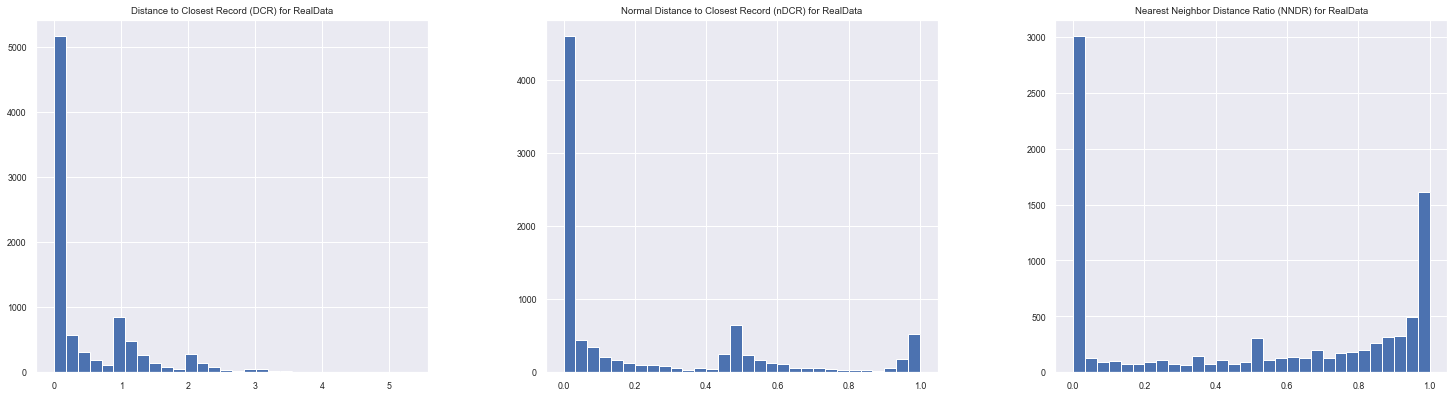

In [275]:
real_privacy = pd.DataFrame(zip(dcr_real,dcr_real_norm,nndr_real),columns=['Distance to Closest Record (DCR) for RealData','Normal Distance to Closest Record (nDCR) for RealData','Nearest Neighbor Distance Ratio (NNDR) for RealData'])
real_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

In [276]:
def calc_dcr_ratio(real_dcr:np.array, synt_dcr:np.array):
    med_real = np.median(real_dcr) 
    ordered_synt = np.sort(synt_dcr)
    middle = len(ordered_synt)//2
    if ordered_synt[middle] <= med_real :
        for i in range(middle) :
            if (i == middle) or (ordered_synt[middle+i+1] >= med_real) :
                break
        first_median_synt = middle + i
    else:
        for i in range(middle) :
            if (i == middle) or (ordered_synt[middle-i-1] < med_real) :
                break
        first_median_synt = middle - i
    return (len(ordered_synt)-first_median_synt)/max(first_median_synt,smoothing_factor)

In [277]:
def calc_nndr_ratio(real_nndr:np.array, synt_nndr:np.array):
    med_real = np.median(real_nndr) 
    ordered_synt = np.sort(synt_nndr)
    middle = len(ordered_synt)//2
    if ordered_synt[middle] <= med_real :
        for i in range(middle) :
            if (i == middle) or (ordered_synt[middle+i+1] >= med_real) :
                break
        first_median_synt = middle + i
    else:
        for i in range(middle) :
            if (i == middle) or (ordered_synt[middle-i-1] < med_real) :
                break
        first_median_synt = middle - i
    return (len(ordered_synt)-first_median_synt)/max(first_median_synt,smoothing_factor)

In [278]:
calc_dcr_ratio(dcr_real_norm,dcr_real_norm.copy())

1.0

In [279]:
calc_nndr_ratio(nndr_real,nndr_real.copy())

1.0

In [280]:
res_privacy = pd.DataFrame([['Real dataset', bound,
                        calc_dcr_ratio(dcr_real_norm,dcr_real_norm.copy()),
                        calc_nndr_ratio(nndr_real,nndr_real.copy()),
                        np.median(dcr_real_norm),
                        np.median(nndr_real),
                        dcr_real_norm.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_7460\106412619.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  privacy_results = pd.concat([privacy_results, res_privacy],axis=0)


## DistillGPT2 privacy

In [281]:
syn_test1 = synt_data_distilgpt2.sample(n=control_size) 

In [282]:
hmm_test1 = syn_test1.copy()
hmm_test1 = hmm_test1[for_norm_columns+for_hmm_columns]

In [283]:
hmm_test1 = map_humming(hmm_test1,hmm)

In [284]:
nbs1 = get_2_neighbors_mixed(vectors=hmm_test1.to_numpy()[:10000],base=hmm_train.to_numpy()[:10000],norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [285]:
print('Stats : mean, std, max, min, amount')
dcr_synt1 = np.array([d[0] for d in [x[1] for x in [i for i in nbs1]]])
dcr2_synt1 = np.array([d[1] for d in [x[1] for x in [i for i in nbs1]]])
nndr_synt1 = dcr_synt1 / np.maximum(dcr2_synt1, smoothing_factor) 
print('NNDR stats', nndr_synt1.mean(), nndr_synt1.std(), nndr_synt1.max(), nndr_synt1.min(), len (nndr_synt1))
dcr_synt_norm1 = np.where(dcr_synt1 <= bound, dcr_synt1 / bound, 1)
print('nDCR stats', dcr_synt_norm1.mean(), dcr_synt_norm1.std(), dcr_synt_norm1.max(), dcr_synt_norm1.min(), len(dcr_synt_norm1))

baseline_dcr = dcr_synt1
bound1 = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
print('DCR Bound',dcr_quantile,'% =',bound1)

Stats : mean, std, max, min, amount
NNDR stats 0.8235976765198604 0.27491613979118584 1.0 0.0 9000
nDCR stats 0.7451779857973949 0.34882033014831004 1.0 0.0 9000
DCR Bound 0.95 % = 5.0396873468734675


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for DistillGPT synthetics '}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for DistillGPT synthetics'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for DistillGPT synthetics'}>]],
      dtype=object)

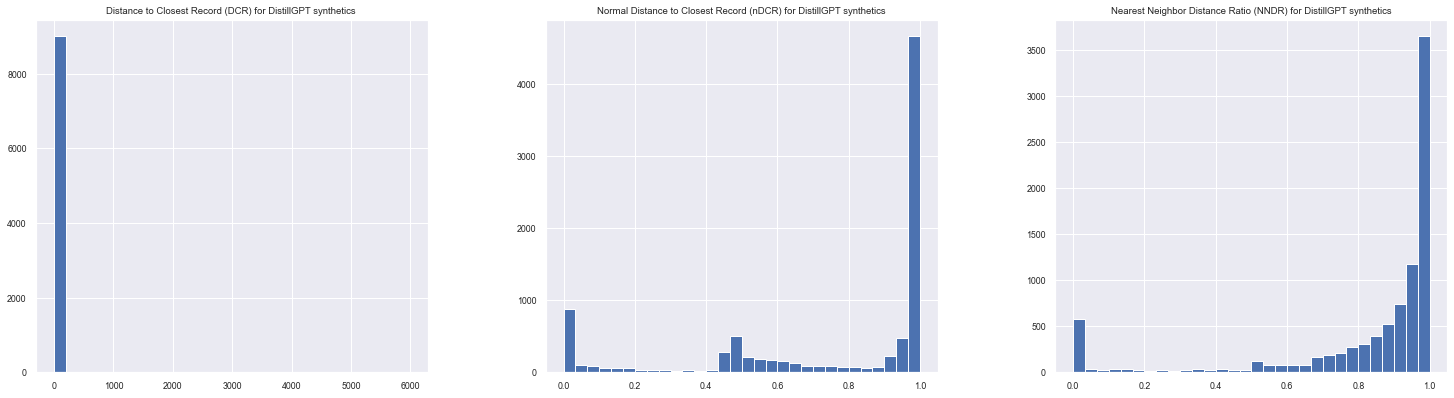

In [286]:
synt_privacy = pd.DataFrame(zip(dcr_synt1,dcr_synt_norm1,nndr_synt1),columns=['Distance to Closest Record (DCR) for DistillGPT synthetics ','Normal Distance to Closest Record (nDCR) for DistillGPT synthetics','Nearest Neighbor Distance Ratio (NNDR) for DistillGPT synthetics'])
synt_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

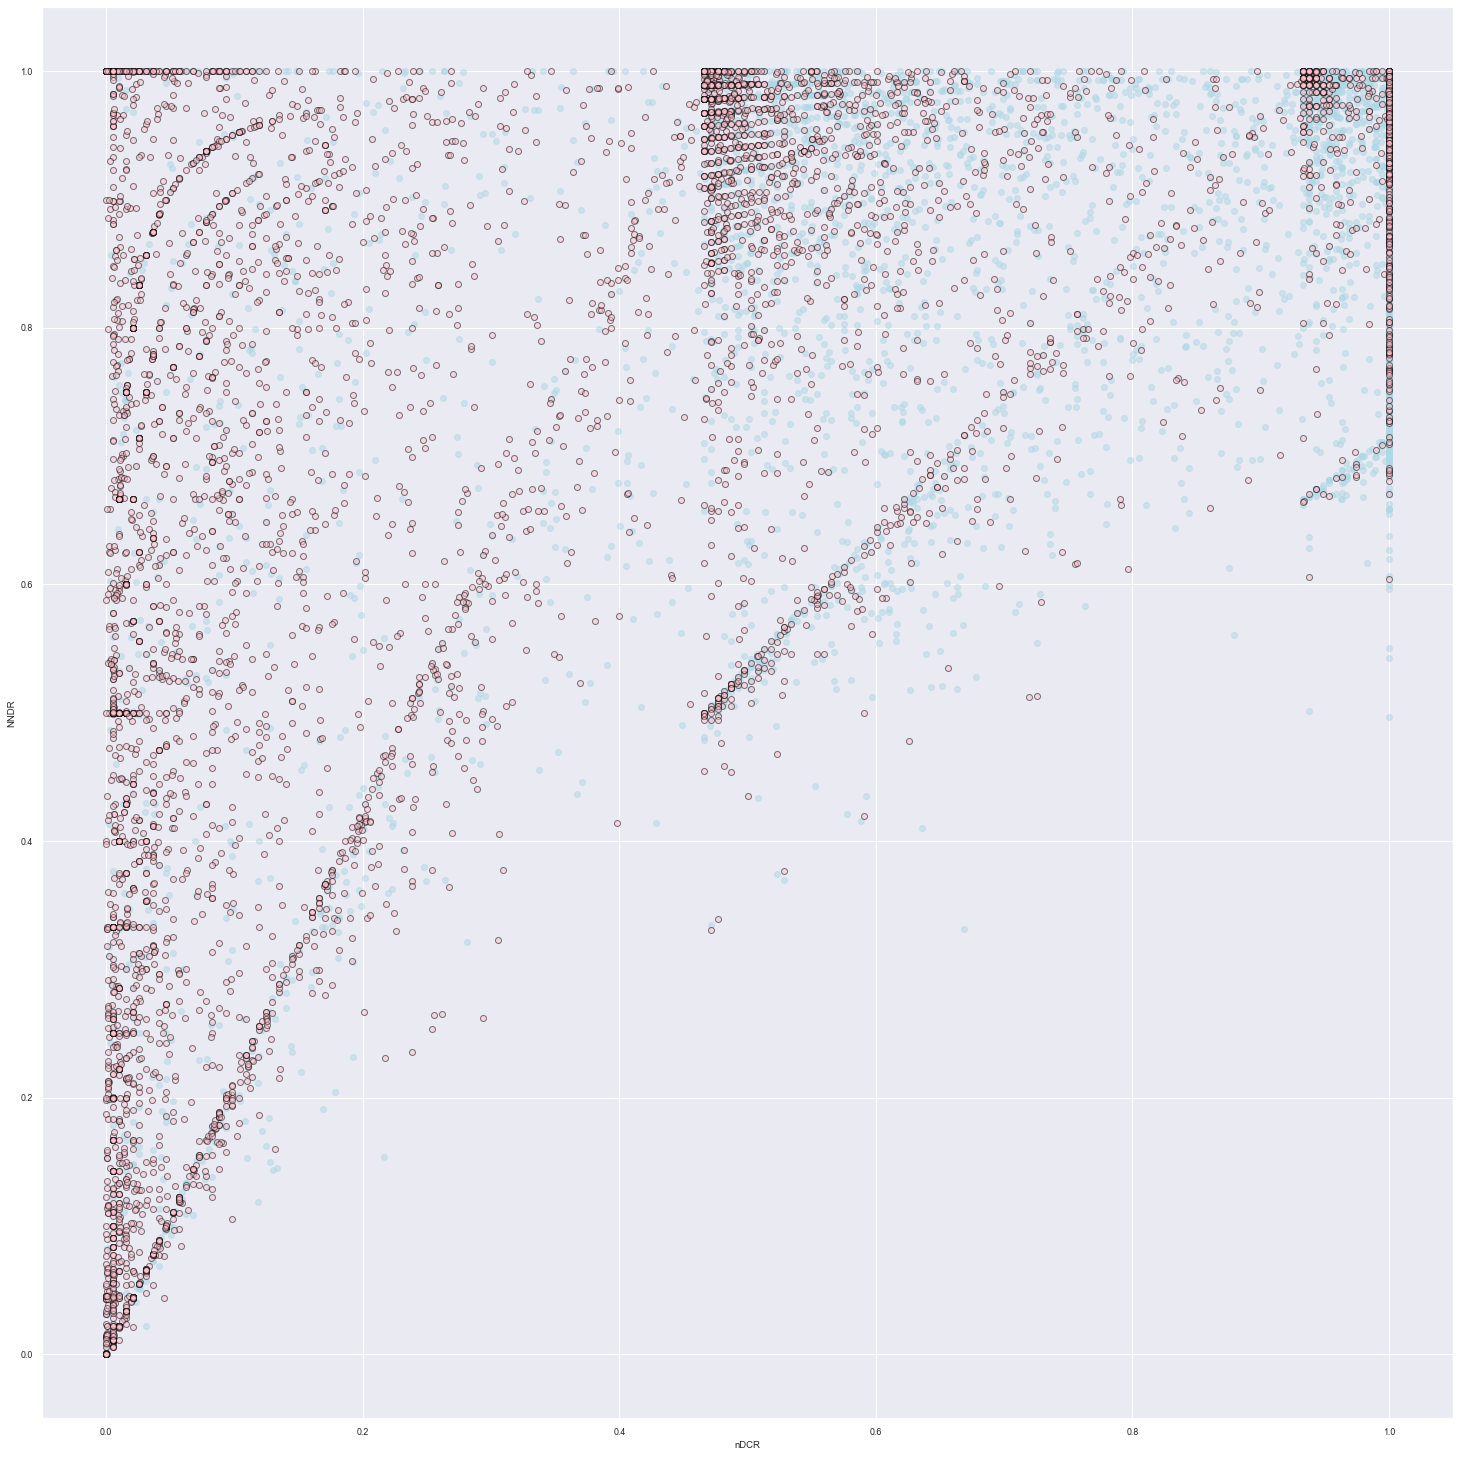

In [287]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
#ax.scatter(cols_compare['Longitude']['gpt2xl'], cols_compare['Latitude']['gpt2xl'],c='lightgreen', label='gpt2xl', alpha=0.1, edgecolors='lightgreen')
#ax.scatter(cols_compare['Longitude']['cerebras'], cols_compare['Latitude']['cerebras'],c='cyan', label='cerebras', alpha=0.5, edgecolors='cyan')
ax.scatter(dcr_synt_norm1, nndr_synt1, c='lightblue', label='DistilledGPT', alpha=0.5, edgecolors='lightblue')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [288]:
calc_dcr_ratio(dcr_real_norm,dcr_synt_norm1)

9.501750291715286

In [289]:
calc_nndr_ratio(nndr_real,nndr_synt1)

8.06344410876133

In [290]:
stat, p_value = mannwhitneyu(dcr_real_norm, dcr_synt_norm1)
print(f" Mann-Whitney U rank test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = mannwhitneyu(nndr_real, nndr_synt1)
print(f" Mann-Whitney U rank test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

stat, p_value = ks_2samp(dcr_real_norm, dcr_synt_norm1)
print(f" Kolmogorov-Smirnov Test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = ks_2samp(nndr_real, nndr_synt1)
print(f" Kolmogorov-Smirnov Test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

 Mann-Whitney U rank test for nDCR: statistic=12770534.50000000, p-value=0.00000000
 Mann-Whitney U rank test for NNDR: statistic=21623349.500000, p-value=0.000000
 Kolmogorov-Smirnov Test for nDCR: statistic=0.55988889, p-value=0.00000000
 Kolmogorov-Smirnov Test for NNDR: statistic=0.419556, p-value=0.000000


In [291]:
res_privacy = pd.DataFrame([['DistillGPT2', bound1,
                        calc_dcr_ratio(dcr_real_norm,dcr_synt_norm1),
                        calc_nndr_ratio(nndr_real,nndr_synt1),
                        np.median(dcr_synt_norm1),
                        np.median(nndr_synt1),
                        dcr_synt_norm1.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

## GPT2XL privacy

In [292]:
syn_test1 = synt_data_gpt2xl.sample(n=control_size) 

In [293]:
hmm_test1 = syn_test1.copy()
hmm_test1 = hmm_test1[for_norm_columns+for_hmm_columns]

In [294]:
hmm_test1 = map_humming(hmm_test1,hmm)

In [295]:
nbs2 = get_2_neighbors_mixed(vectors=hmm_test1.to_numpy(),base=hmm_train.to_numpy(),norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [296]:
print('Stats : mean, std, max, min, amount')
dcr_synt2 = np.array([d[0] for d in [x[1] for x in [i for i in nbs2]]])
dcr2_synt2 = np.array([d[1] for d in [x[1] for x in [i for i in nbs2]]])
nndr_synt2 = dcr_synt2 / np.maximum(dcr2_synt2, smoothing_factor) 
print('NNDR stats', nndr_synt2.mean(), nndr_synt2.std(), nndr_synt2.max(), nndr_synt2.min(), len (nndr_synt2))
dcr_synt_norm2 = np.where(dcr_synt2 <= bound, dcr_synt2 / bound, 1)
print('nDCR stats', dcr_synt_norm2.mean(), dcr_synt_norm2.std(), dcr_synt_norm2.max(), dcr_synt_norm2.min(), len (dcr_synt_norm2))

baseline_dcr = dcr_synt2
bound2 = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
print('DCR Bound',dcr_quantile,'% =',bound2)

Stats : mean, std, max, min, amount
NNDR stats 0.7345642037888677 0.34659654909377385 1.0 0.0 9000
nDCR stats 0.5894984304880914 0.39700082864156466 1.0 0.0 9000
DCR Bound 0.95 % = 4.138461538461538


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for GPTxl synthetics '}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for GPTxl synthetics'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for GPT2xl synthetics'}>]],
      dtype=object)

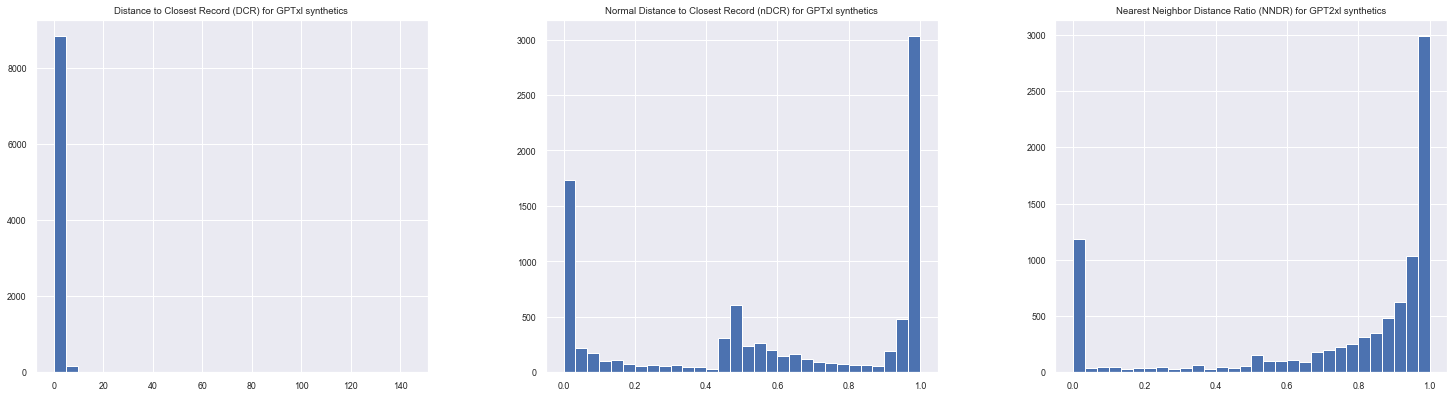

In [297]:
synt_privacy = pd.DataFrame(zip(dcr_synt2,dcr_synt_norm2,nndr_synt2),columns=['Distance to Closest Record (DCR) for GPTxl synthetics ','Normal Distance to Closest Record (nDCR) for GPTxl synthetics','Nearest Neighbor Distance Ratio (NNDR) for GPT2xl synthetics'])
synt_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

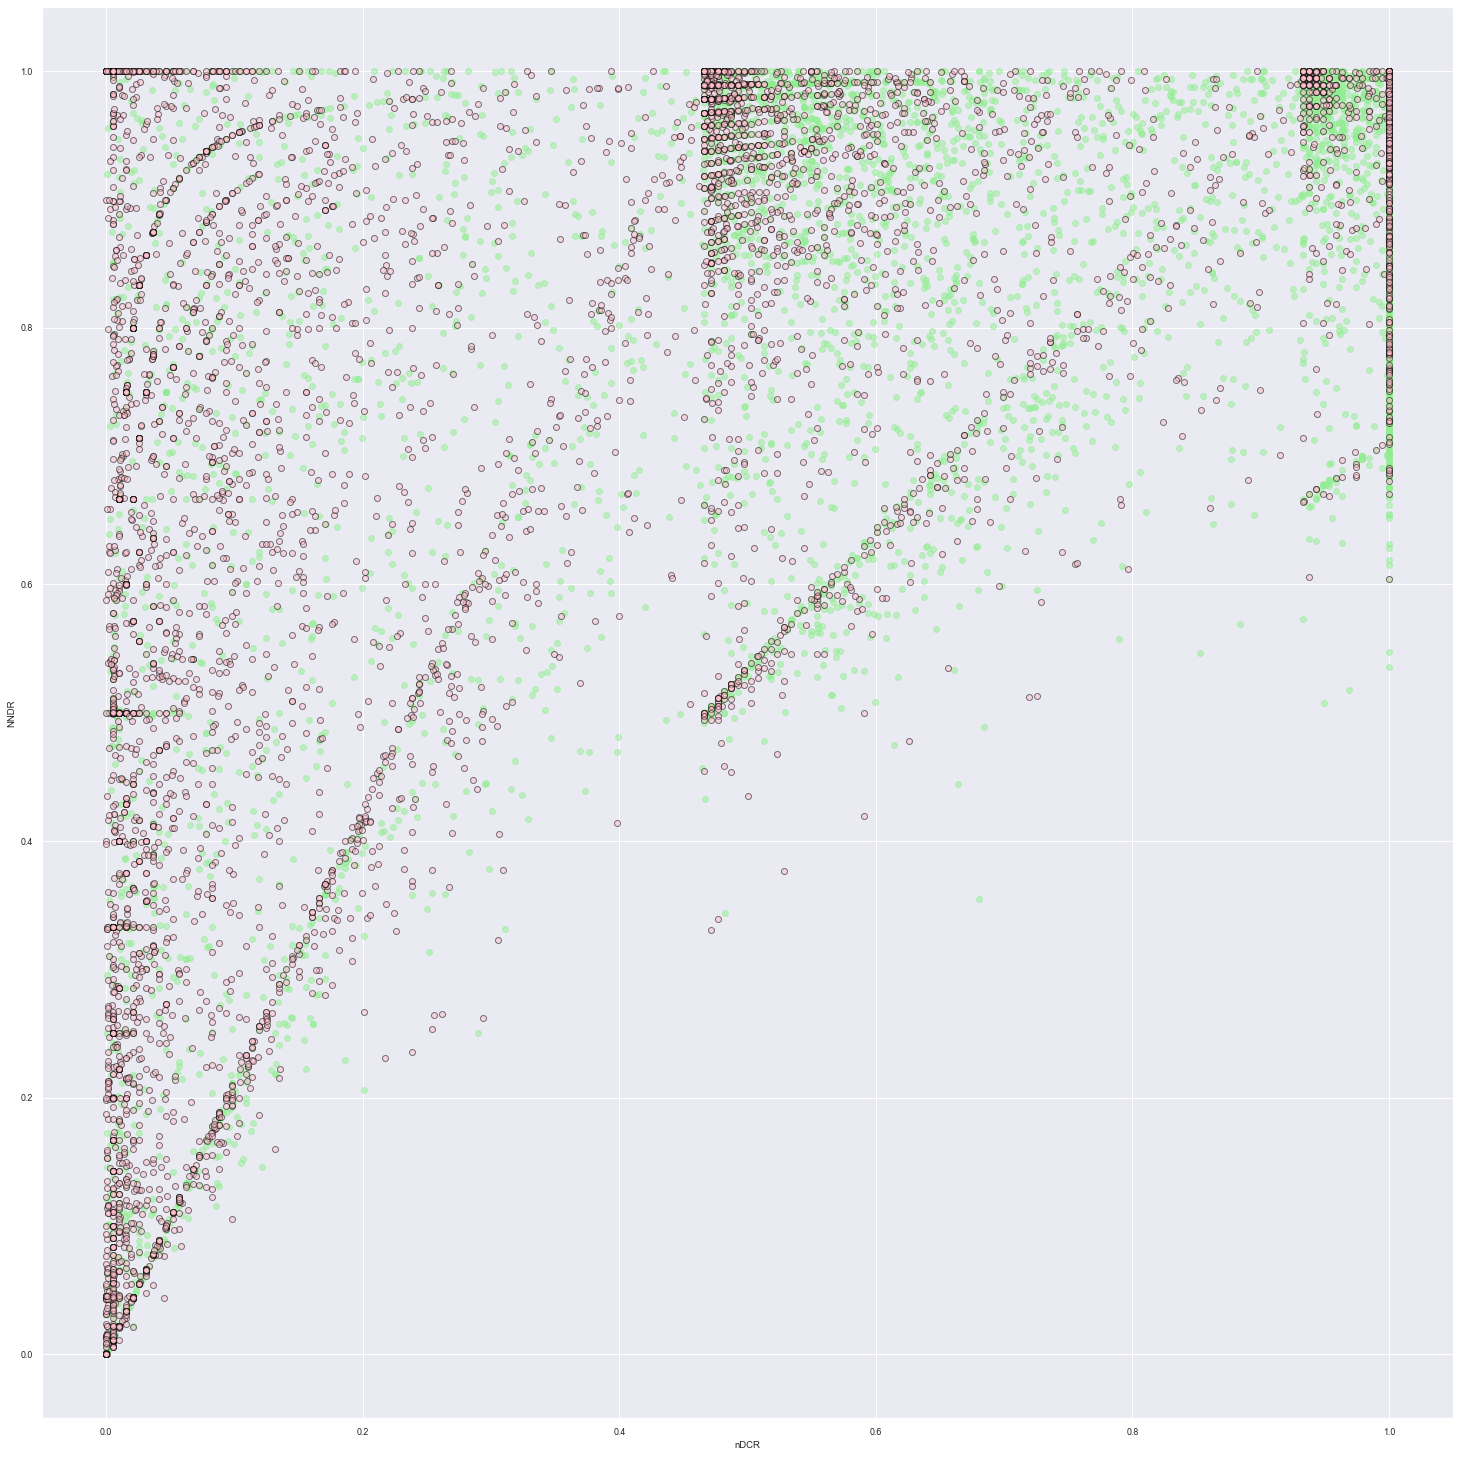

In [298]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
ax.scatter(dcr_synt_norm2, nndr_synt2, c='lightgreen', label='GPT2xl', alpha=0.5, edgecolors='lightgreen')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [299]:
calc_dcr_ratio(dcr_real_norm,dcr_synt_norm2)

4.328596802841918

In [300]:
calc_nndr_ratio(nndr_real,nndr_synt2)

3.8076923076923075

In [301]:
stat, p_value = mannwhitneyu(dcr_real_norm, dcr_synt_norm2)
print(f" Mann-Whitney U rank test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = mannwhitneyu(nndr_real, nndr_synt2)
print(f" Mann-Whitney U rank test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")
print ('')


print ('')
stat, p_value = ks_2samp(dcr_real_norm, dcr_synt_norm2)
print(f" Kolmogorov-Smirnov Test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = ks_2samp(nndr_real, nndr_synt2)
print(f" Kolmogorov-Smirnov Test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

 Mann-Whitney U rank test for nDCR: statistic=20389613.50000000, p-value=0.00000000
 Mann-Whitney U rank test for NNDR: statistic=26679028.500000, p-value=0.000000


 Kolmogorov-Smirnov Test for nDCR: statistic=0.39877778, p-value=0.00000000
 Kolmogorov-Smirnov Test for NNDR: statistic=0.312222, p-value=0.000000


In [302]:
res_privacy = pd.DataFrame([['GPT2xl', bound2,
                        calc_dcr_ratio(dcr_real_norm,dcr_synt_norm2),
                        calc_nndr_ratio(nndr_real,nndr_synt2),
                        np.median(dcr_synt_norm2),
                        np.median(nndr_synt2),
                        dcr_synt_norm2.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

## Cerebras privacy

In [303]:
syn_test1 = synt_data_cerebras.sample(n=control_size) 

In [304]:
hmm_test1 = syn_test1.copy()
hmm_test1 = hmm_test1[for_norm_columns+for_hmm_columns]

In [305]:
hmm_test1 = map_humming(hmm_test1,hmm)

In [306]:
nbs3 = get_2_neighbors_mixed(vectors=hmm_test1.to_numpy(),base=hmm_train.to_numpy(),norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [307]:
print('Stats : mean, std, max, min, amount')
dcr_synt3 = np.array([d[0] for d in [x[1] for x in [i for i in nbs3]]])
dcr2_synt3 = np.array([d[1] for d in [x[1] for x in [i for i in nbs3]]])
nndr_synt3 = dcr_synt3 / np.maximum(dcr2_synt3, smoothing_factor) 
print('NNDR stats', nndr_synt3.mean(), nndr_synt3.std(), nndr_synt3.max(), nndr_synt3.min(), len (nndr_synt3))
dcr_synt_norm3 = np.where(dcr_synt3 <= bound, dcr_synt3 / bound, 1)
print('nDCR stats', dcr_synt_norm3.mean(), dcr_synt_norm3.std(), dcr_synt_norm3.max(), dcr_synt_norm3.min(), len (dcr_synt_norm3))

baseline_dcr = dcr_synt3
bound3 = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
print('DCR Bound',dcr_quantile,'% =',bound3)

Stats : mean, std, max, min, amount
NNDR stats 0.7383577875597094 0.3434128050309707 1.0 0.0 9000
nDCR stats 0.5822342188527506 0.39666885474214586 1.0 0.0 9000
DCR Bound 0.95 % = 4.099145299145299


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for Cerebras synthetics '}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for Cerebras synthetics'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for Cerebras synthetics'}>]],
      dtype=object)

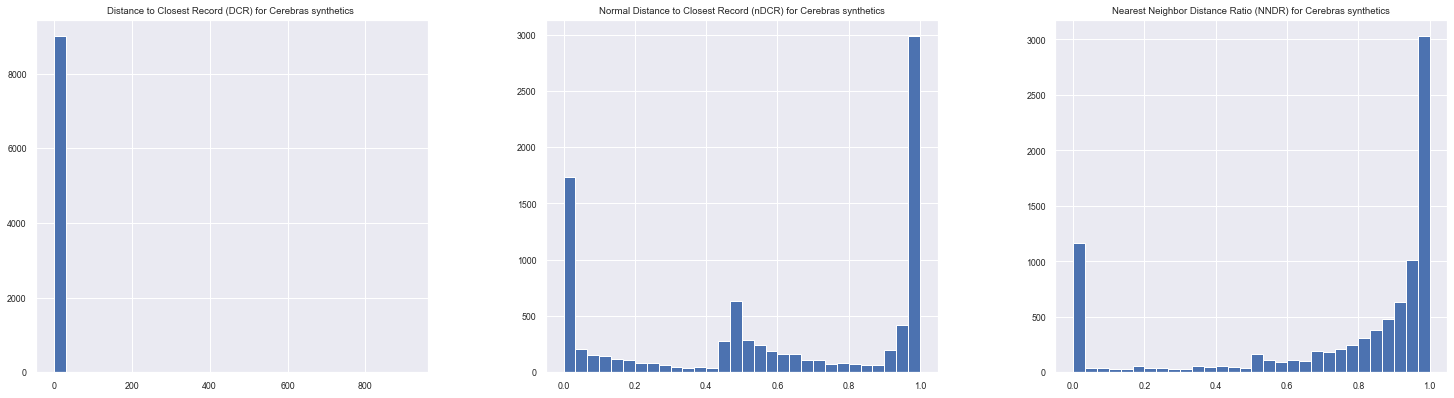

In [308]:
synt_privacy = pd.DataFrame(zip(dcr_synt3,dcr_synt_norm3,nndr_synt3),columns=['Distance to Closest Record (DCR) for Cerebras synthetics ','Normal Distance to Closest Record (nDCR) for Cerebras synthetics','Nearest Neighbor Distance Ratio (NNDR) for Cerebras synthetics'])
synt_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

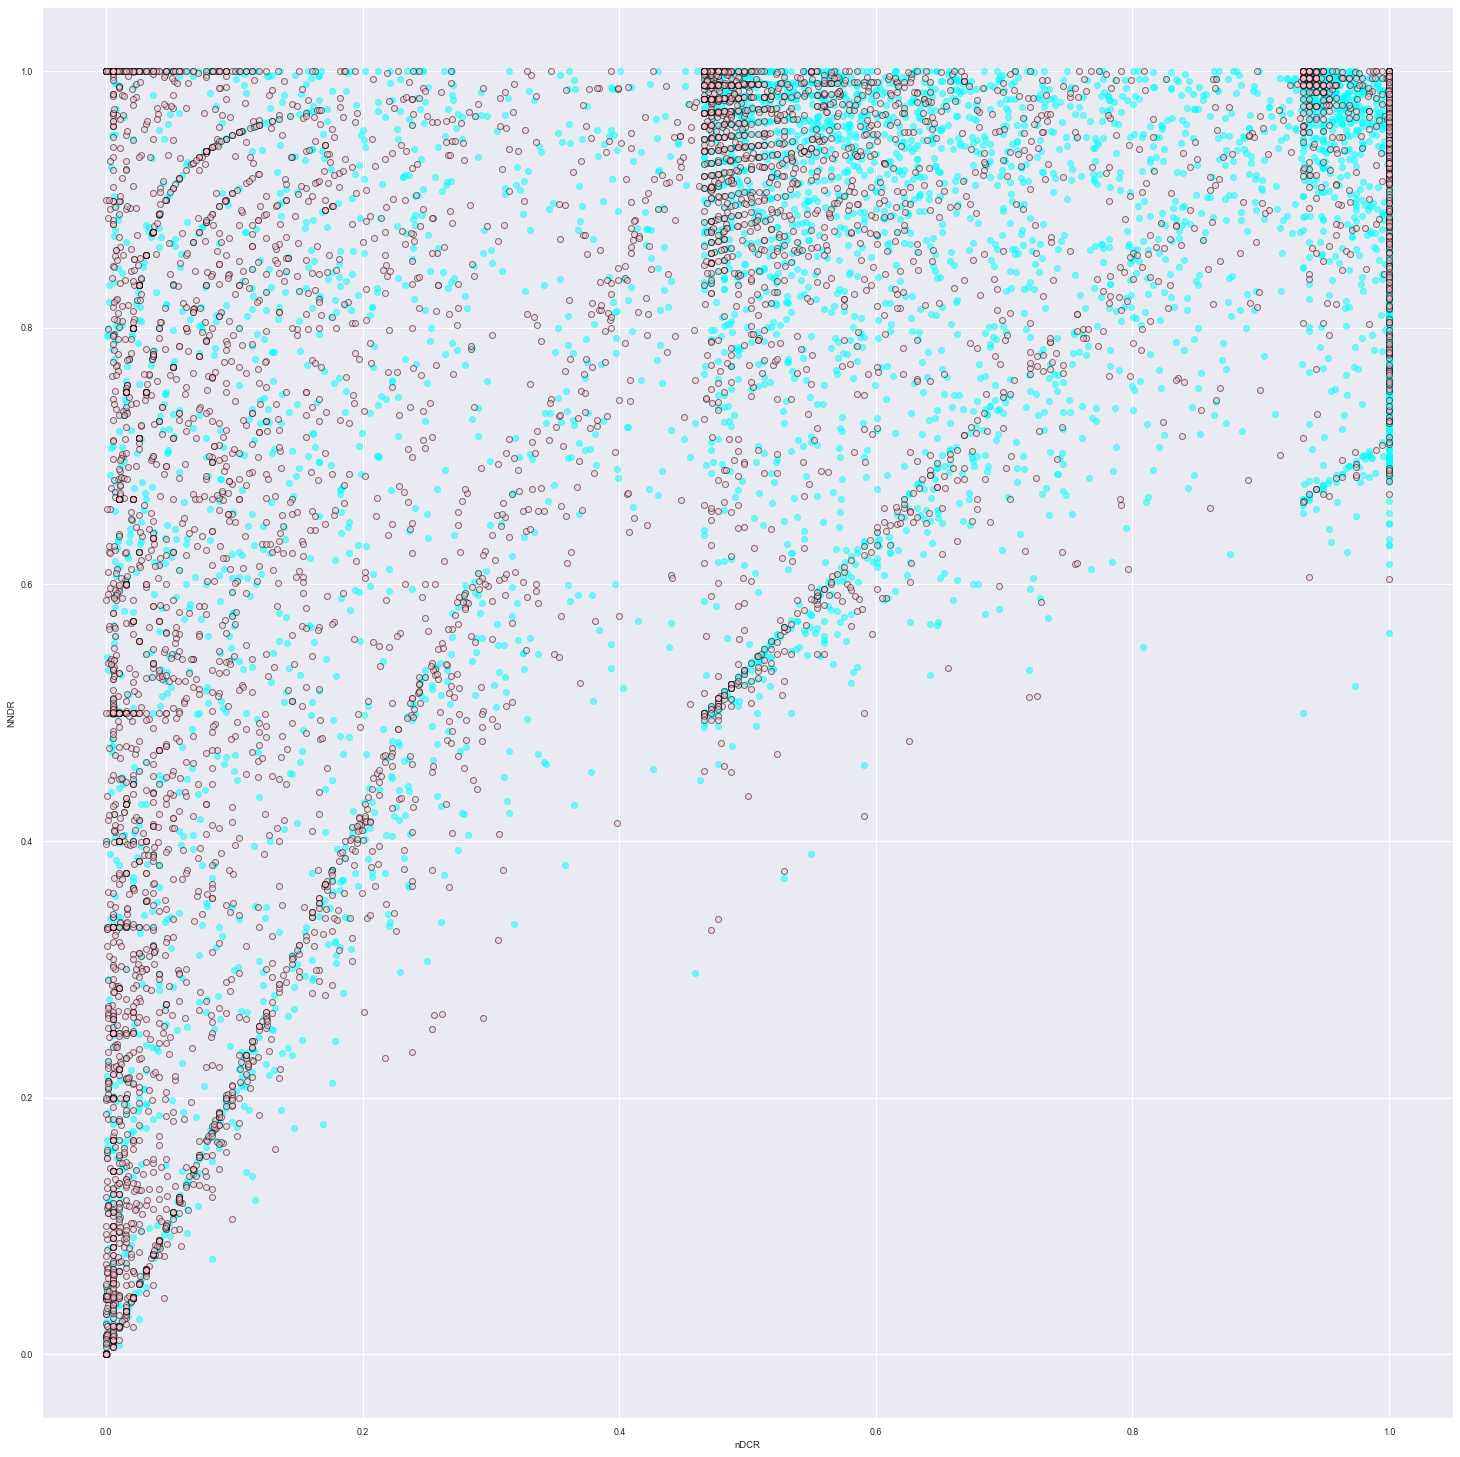

In [309]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
ax.scatter(dcr_synt_norm3, nndr_synt3, c='cyan', label='Cerebras', alpha=0.5, edgecolors='cyan')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [310]:
calc_dcr_ratio(dcr_real_norm,dcr_synt_norm3)

4.334914048606994

In [311]:
calc_nndr_ratio(nndr_real,nndr_synt3)

3.947773501924134

In [312]:
stat, p_value = mannwhitneyu(dcr_real_norm, dcr_synt_norm3)
print(f" Mann-Whitney U rank test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = mannwhitneyu(nndr_real, nndr_synt3)
print(f" Mann-Whitney U rank test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")
print ('')


print ('')
stat, p_value = ks_2samp(dcr_real_norm, dcr_synt_norm3)
print(f" Kolmogorov-Smirnov Test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = ks_2samp(nndr_real, nndr_synt3)
print(f" Kolmogorov-Smirnov Test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

 Mann-Whitney U rank test for nDCR: statistic=20544470.50000000, p-value=0.00000000
 Mann-Whitney U rank test for NNDR: statistic=26497156.000000, p-value=0.000000


 Kolmogorov-Smirnov Test for nDCR: statistic=0.39100000, p-value=0.00000000
 Kolmogorov-Smirnov Test for NNDR: statistic=0.314111, p-value=0.000000


In [313]:
res_privacy = pd.DataFrame([['Cerebras', bound3,
                        calc_dcr_ratio(dcr_real_norm,dcr_synt_norm3),
                        calc_nndr_ratio(nndr_real,nndr_synt3),
                        np.median(dcr_synt_norm3),
                        np.median(nndr_synt3),
                        dcr_synt_norm3.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

## Phi-1.5 privacy

In [314]:
syn_test1 = synt_data_phi.sample(n=control_size) 

In [315]:
hmm_test1 = syn_test1.copy()
hmm_test1 = hmm_test1[for_norm_columns+for_hmm_columns]

In [316]:
hmm_test1 = map_humming(hmm_test1,hmm)

In [317]:
nbs4 = get_2_neighbors_mixed(vectors=hmm_test1.to_numpy(),base=hmm_train.to_numpy(),norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [318]:
print('Stats : mean, std, max, min, amount')
dcr_synt4 = np.array([d[0] for d in [x[1] for x in [i for i in nbs4]]])
dcr2_synt4 = np.array([d[1] for d in [x[1] for x in [i for i in nbs4]]])
nndr_synt4 = dcr_synt4 / np.maximum(dcr2_synt4, smoothing_factor) 
print('NNDR stats', nndr_synt4.mean(), nndr_synt4.std(), nndr_synt4.max(), nndr_synt4.min(), len (nndr_synt4))
dcr_synt_norm4 = np.where(dcr_synt4 <= bound, dcr_synt4 / bound, 1)
print('nDCR stats', dcr_synt_norm4.mean(), dcr_synt_norm4.std(), dcr_synt_norm4.max(), dcr_synt_norm4.min(), len (dcr_synt_norm4))

baseline_dcr = dcr_synt4
bound4 = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
print('DCR Bound',dcr_quantile,'% =',bound4)

Stats : mean, std, max, min, amount
NNDR stats 0.7248719288513703 0.3500832666725086 1.0 0.0 9000
nDCR stats 0.5791797312413139 0.39882346129709434 1.0 0.0 9000
DCR Bound 0.95 % = 4.149806678836018


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for Phi1.5 synthetics '}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for Phi1.5 synthetics'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for Phi1.5 synthetics'}>]],
      dtype=object)

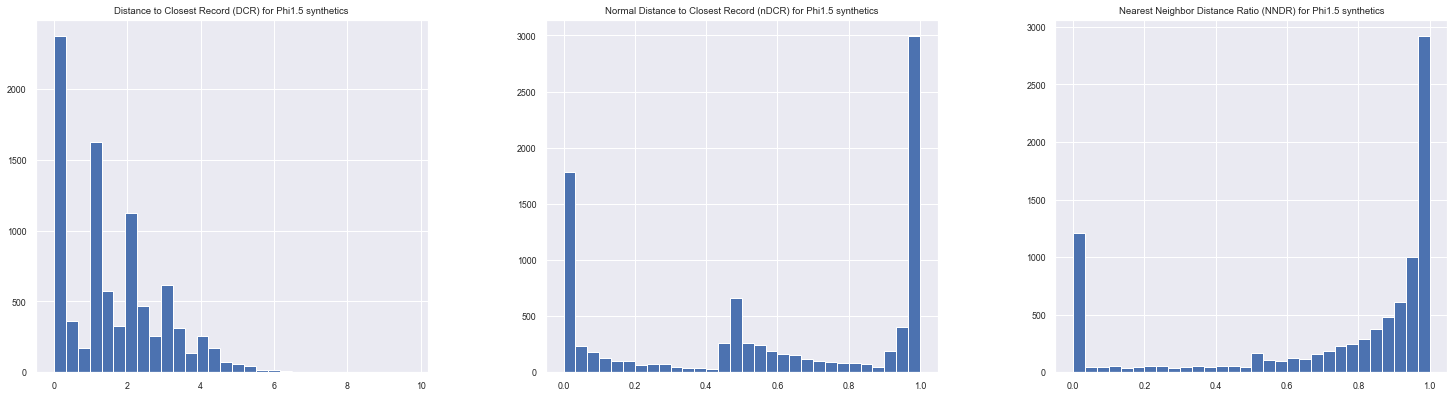

In [319]:
synt_privacy = pd.DataFrame(zip(dcr_synt4,dcr_synt_norm4,nndr_synt4),columns=['Distance to Closest Record (DCR) for Phi1.5 synthetics ','Normal Distance to Closest Record (nDCR) for Phi1.5 synthetics','Nearest Neighbor Distance Ratio (NNDR) for Phi1.5 synthetics'])
synt_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

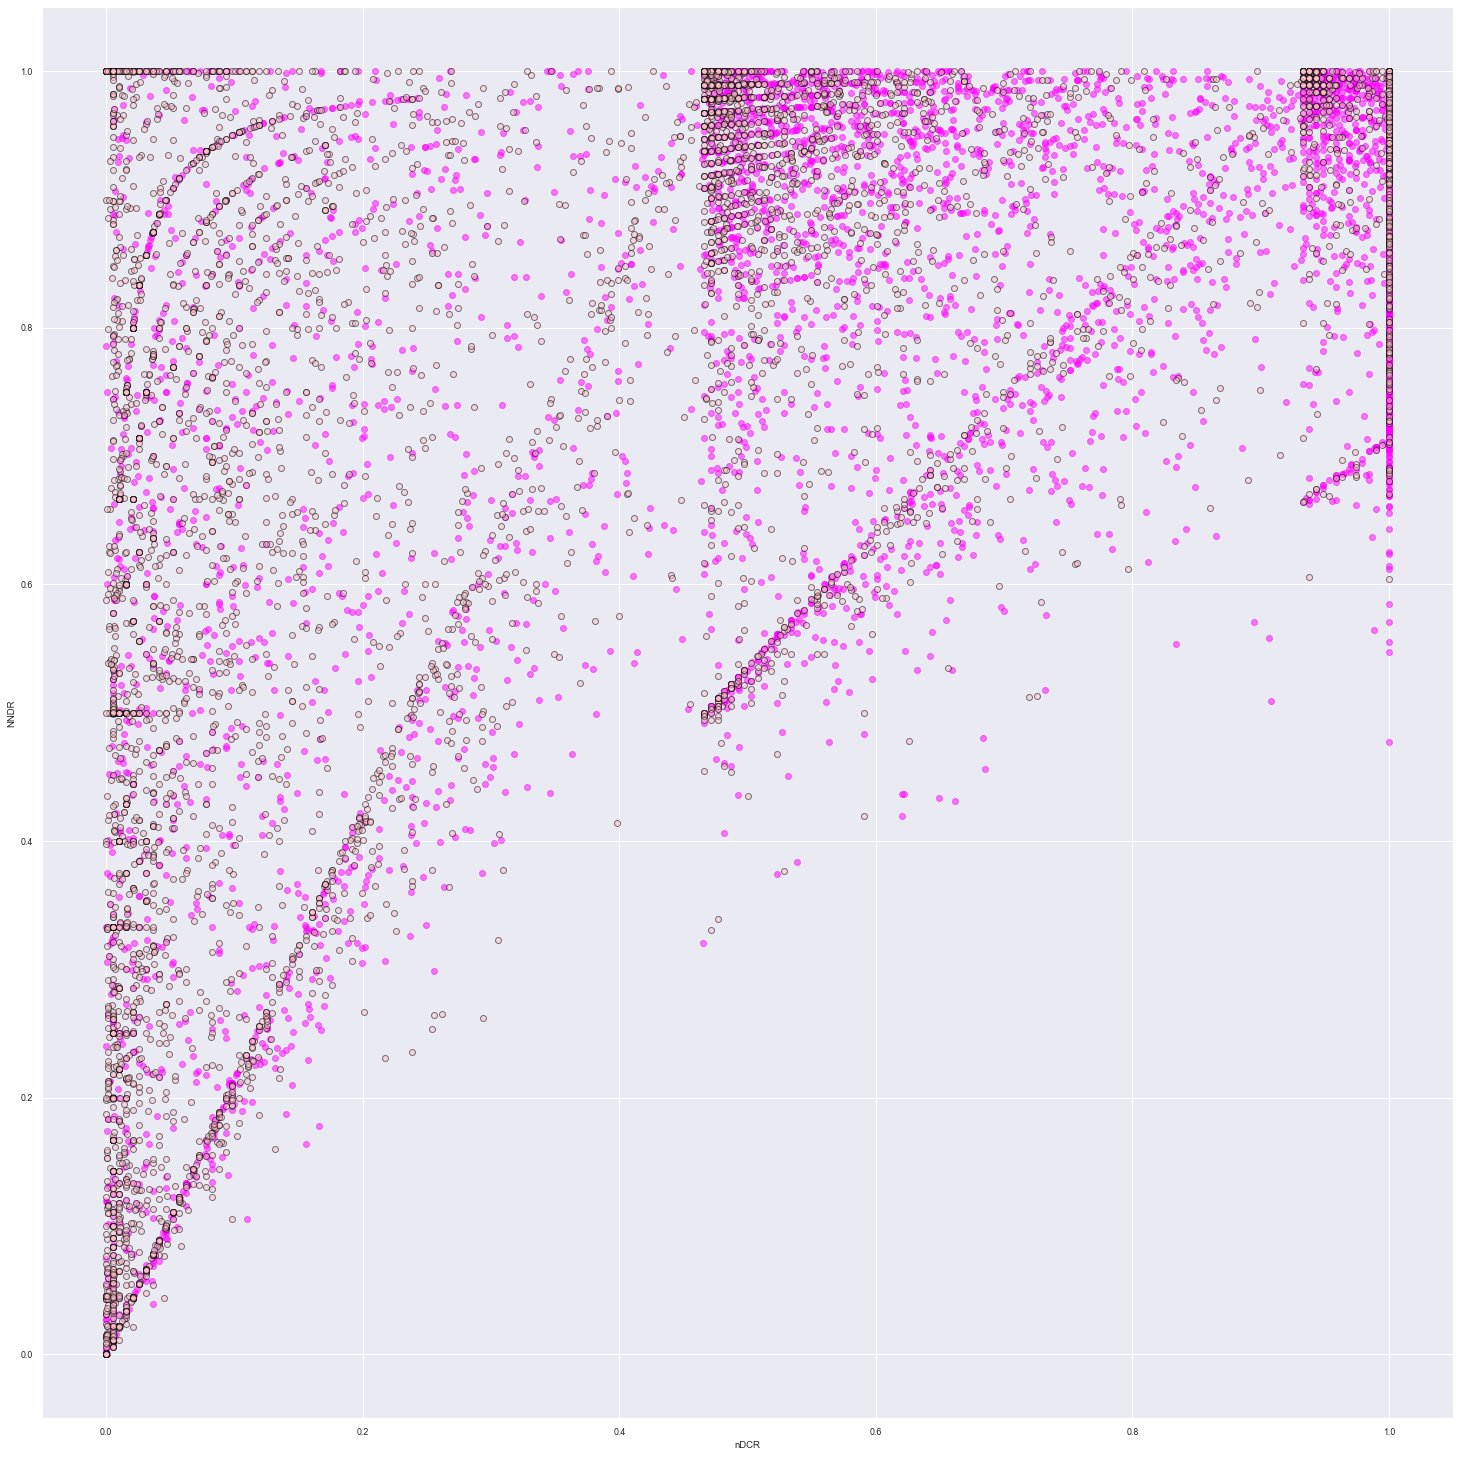

In [320]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
ax.scatter(dcr_synt_norm4, nndr_synt4, c='magenta', label='Phi1.5', alpha=0.5, edgecolors='magenta')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [321]:
calc_dcr_ratio(dcr_real_norm,dcr_synt_norm4)

4.196304849884527

In [322]:
calc_nndr_ratio(nndr_real,nndr_synt4)

3.570848146267141

In [323]:
stat, p_value = mannwhitneyu(dcr_real_norm, dcr_synt_norm4)
print(f" Mann-Whitney U rank test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = mannwhitneyu(nndr_real, nndr_synt4)
print(f" Mann-Whitney U rank test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")
print ('')


print ('')
stat, p_value = ks_2samp(dcr_real_norm, dcr_synt_norm4)
print(f" Kolmogorov-Smirnov Test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = ks_2samp(nndr_real, nndr_synt4)
print(f" Kolmogorov-Smirnov Test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

 Mann-Whitney U rank test for nDCR: statistic=20799940.00000000, p-value=0.00000000
 Mann-Whitney U rank test for NNDR: statistic=27229068.000000, p-value=0.000000


 Kolmogorov-Smirnov Test for nDCR: statistic=0.39066667, p-value=0.00000000
 Kolmogorov-Smirnov Test for NNDR: statistic=0.295333, p-value=0.000000


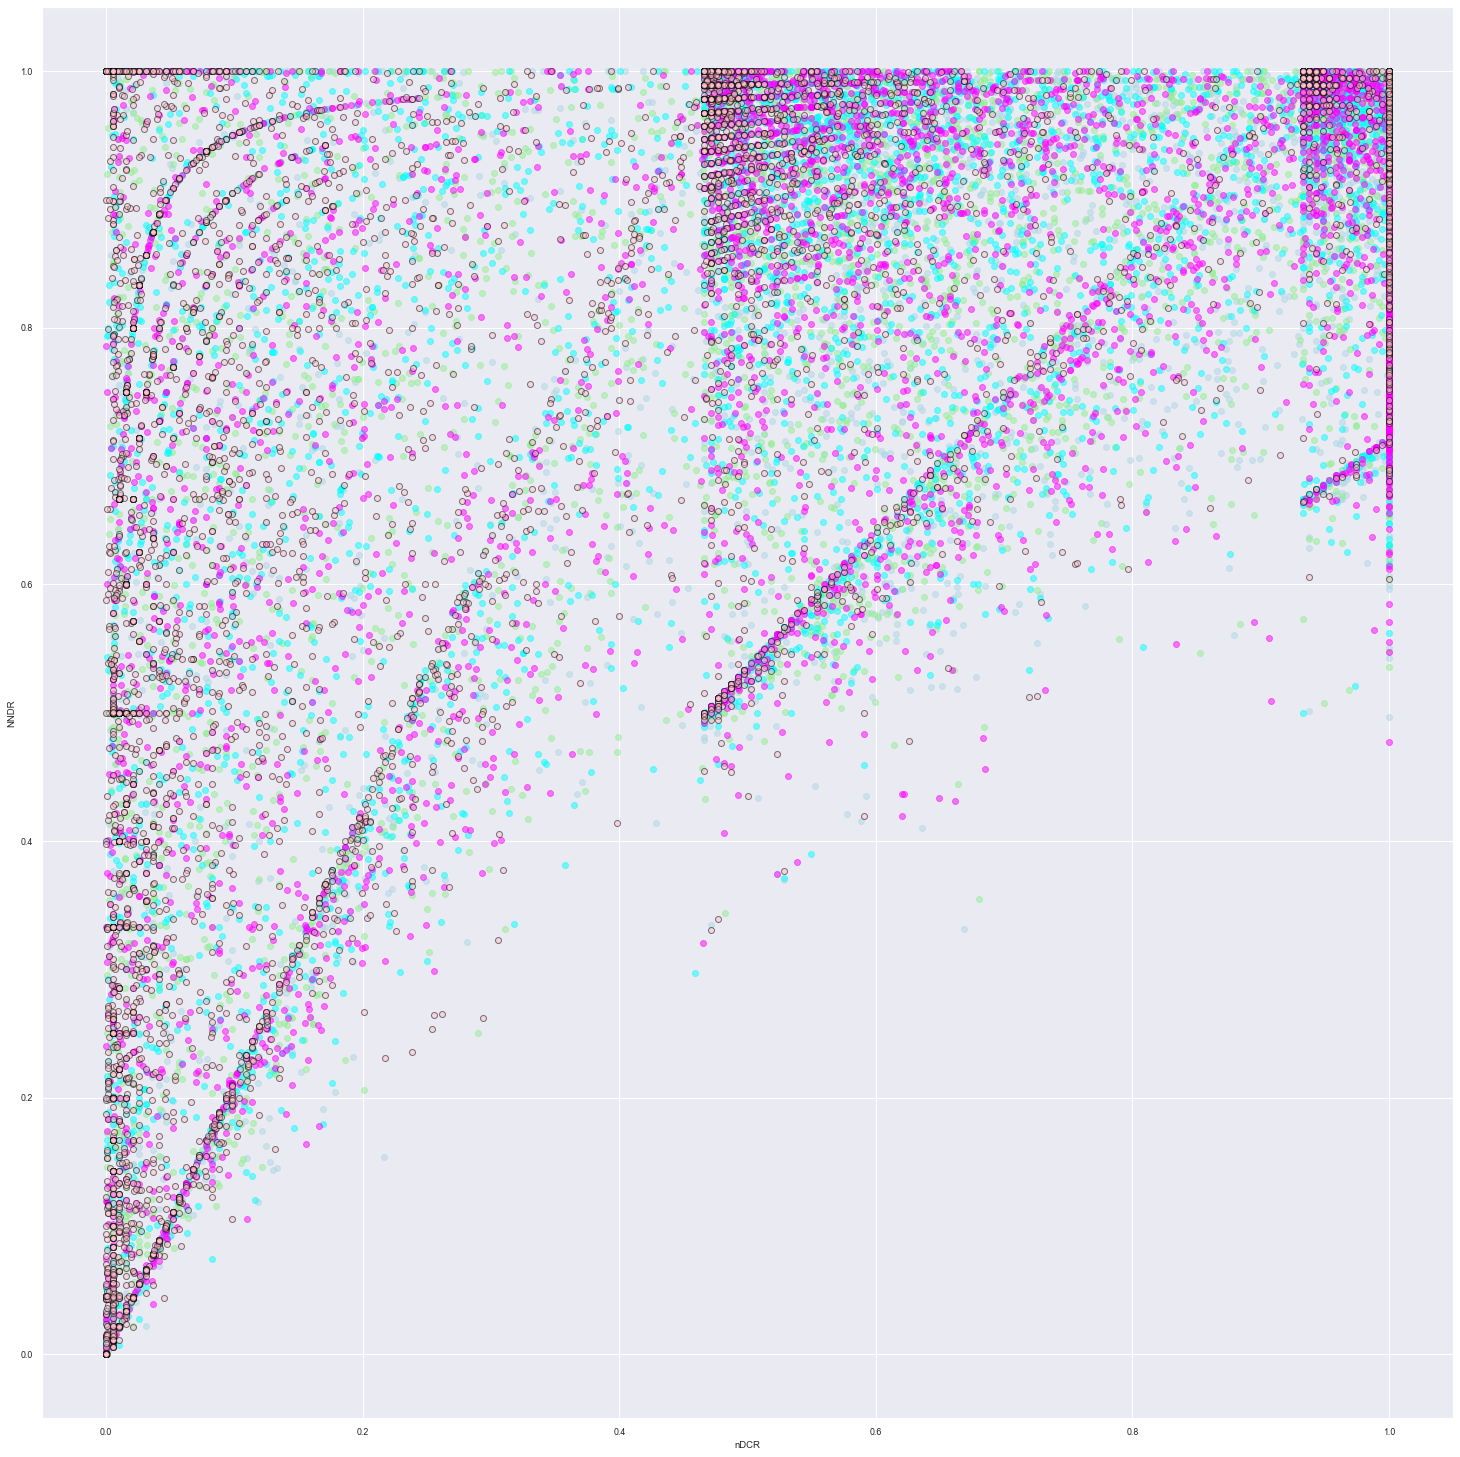

In [324]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
ax.scatter(dcr_synt_norm1, nndr_synt1, c='lightblue', label='DistilledGPT', alpha=0.5, edgecolors='lightblue')
ax.scatter(dcr_synt_norm2, nndr_synt2, c='lightgreen', label='GPT2xl', alpha=0.5, edgecolors='lightgreen')
ax.scatter(dcr_synt_norm3, nndr_synt3, c='cyan', label='Cerebras', alpha=0.5, edgecolors='cyan')
ax.scatter(dcr_synt_norm4, nndr_synt4, c='magenta', label='Phi-1.5', alpha=0.5, edgecolors='magenta')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [325]:
res_privacy = pd.DataFrame([['Phi1.5', bound4,
                        calc_dcr_ratio(dcr_real_norm,dcr_synt_norm4),
                        calc_nndr_ratio(nndr_real,nndr_synt4),
                        np.median(dcr_synt_norm4),
                        np.median(nndr_synt4),
                        dcr_synt_norm4.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

### Privacy calculation results 

In [326]:
privacy_results

Model  95% bound  DCRn ratio  NNDR ratio  DCRn median  NNDR median  \
0  Real dataset   2.144444    1.000000    1.000000     0.026871     0.507562   
0   DistillGPT2   5.039687    9.501750    8.063444     0.991411     0.944992   
0        GPT2xl   4.138462    4.328597    3.807692     0.616222     0.909041   
0      Cerebras   4.099145    4.334914    3.947774     0.600438     0.910265   
0        Phi1.5   4.149807    4.196305    3.570848     0.600169     0.901660   

   Minimal distance  
0               0.0  
0               0.0  
0               0.0  
0               0.0  
0               0.0

In [327]:
privacy_results.to_csv('privacy_results_shortincome_temp1.4.csv')